
# Contents

1. [Setup](#1)<br>
    1.1 [Create Spark Session](#1.1)<br>
2. [Loading the Data](#2)<br>
    2.1 [Utilities](#2.1)<br>
    2.2 [Loading Metadata and JSON](#2.2)<br>
    2.3 [Review JSON Schema](#2.3)<br>
3. [Discover and visualize the data to gain insight](#3)<br>
    3.1 [Utilities](#3.1)<br>
    3.2 [Anaysis of Year of publication](#3.2)<br>
    3.3 [Analysis of journals and authors](#3.3)<br>
    3.4 [Analysis of text columns](#3.4)<br>
    3.5 [Analysis of Abstract content](#3.5)<br>
    3.6 [Analysis of Language](#3.6)<br>
4. [Data Reduction](#4)<br>
    4.1 [Fetch Body Text with Scala](#4.1)<br>
    4.2 [Fetch Body Text with Python](#4.2)<br>
    4.3 [Datareduction](#4.3)<br>
5. [Pre-Processing](#5)<br>
    5.1 [Tokenization with Apache Spark MLlib](#5.1)<br>
    5.2 [Tokenization and Lemmatization with Stanford CoreNLP](#5.2)<br>
6. [TF-IDF](#6)<br>
    6.1 [Computing the TF-IDFs](#6.1)<br>
      6.1.1 [Computing TF with MLlib](#6.1.1)<br>
      6.1.2 [Computing IDF with MLlib](#6.1.2)<br>
7. [Singular Value Decomposition (SVD)](#7)<br>
8. [Documents clustering](#8)<br> 
9. [Export results (WordClouds)](#9)<br>


# <span style='color:Blue' id='1'> 1. Setup  </span>

## <span style='color:Blue' id='1.1'> 1.1. Create Spark Session 

<span style='color:denim' > In this project was used: <br>
    <pre>- spylon-kernel </pre>
    <pre>- scala 2.12.10 </pre>
    <pre>- spark 3.0.1 </pre>
    <pre>- java version "1.8.0_272" (OpenJDK 64-Bit Server VM)</pre>
    <pre>- Python 3.7.6</pre>
<br>
Technical specifications: 
  Model Name:	MacBook Pro
  Model Identifier:	MacBookPro15,2
  Processor Name:	Quad-Core Intel Core i5
  Processor Speed:	2,3 GHz
  Number of Processors:	1
  Total Number of Cores:	4
  L2 Cache (per Core):	256 KB
  L3 Cache:	6 MB
  Hyper-Threading Technology:	Enabled
  Memory:	8 GB


In [1]:
%%init_spark
launcher.jars = [
                "./jars/stanford-corenlp-3.9.1.jar",
                "./jars/stanford-corenlp-3.9.1-models.jar",
                "./jars/stanford-corenlp-3.9.1-sources.jar"]

launcher.driver_memory = '6g' 
launcher.conf.set("spark.sql.catalogImplementation", "hive")
launcher.conf.set("spark.sql.crossJoin.enabled", "true") 
launcher.conf.set("spark.app.name", "CORD-19")
launcher.conf.set("spark.driver.maxResultSize", "2g")
launcher.packages = [
                    "com.github.pemistahl:lingua:1.1.0",
                    ] 


In [2]:
spark

Intitializing Scala interpreter ...

Spark Web UI available at http://nataliias-mbp:4042
SparkContext available as 'sc' (version = 3.0.1, master = local[*], app id = local-1657897942518)
SparkSession available as 'spark'


res0: org.apache.spark.sql.SparkSession = org.apache.spark.sql.SparkSession@19360cd2


In [3]:
spark.version

res1: String = 3.0.1


In [4]:
val sqlContext = spark.sqlContext

sqlContext: org.apache.spark.sql.SQLContext = org.apache.spark.sql.SQLContext@14785464


Important imports:

In [5]:
import org.apache.spark.ml.feature
import org.apache.spark.ml.Pipeline

// For implicit conversions like converting RDDs to DataFrames
import sqlContext.implicits._

import org.apache.spark.ml.feature
import org.apache.spark.ml.Pipeline
import sqlContext.implicits._


**Data Overview**
CORD-19 is released weekly. Each version of the corpus is tagged with a datestamp. 
In this project we used Release from 2021-05-31.
The directories structures is:<br>
<pre>|- 2021-05-31:
        |-changelog
        |-cord_19_embeddings.tar.gz
        |-document_parses.tar.gz
        |-metadata.csv
|- 2021-06-07:
        |-changelog
        |-cord_19_embeddings.tar.gz
        |- ...

# <span style='color:Blue' id='2'> 2. Loading the Data

**'changelog'** -  A text file summarizing changes between this and the previous version. <br>
**'cord_19_embeddings.tar.gz'** - A collection of precomputed SPECTER document embeddings for each CORD-19 paper. <br>
**'document_parses.tar.gz'** - A collection of JSON files that contain full text parses of a subset of CORD-19 papers. <br>
**'metadata.csv'** - Metadata for all CORD-19 papers. <br>
<br>
When **document_parses.tar.gz** is uncompressed, it is a directory: <br>
<pre>|- document_parses:
        |- pdf_json:
                |- 80013c44d7d2d3949096511ad6fa424a2c740813.json
                |- bfe20b3580e7c539c16ce4b1e424caf917d3be39.json
                |- ...
        |- pmc_json:
                |- PMC7096781.xml.json
                |- PMC7118448.xml.json
                |- ...



## <span style='color:Blue' id='2.1'> 2.1. Utilities

In [6]:
//Constants
val METADATA_PATH = "datasets/2021-05-31/metadata.csv"
val METADATA_SMALL_PATH = "datasets/2021-05-31/metadata_small.csv"

val PMC_EXAMPLE_PATH = "datasets/2021-05-31/document_parses/pmc_json/PMC35282.xml.json"
val PDF_EXAMPLE_PATH = "datasets/2021-05-31/document_parses/pdf_json/0a0a7434df071b9842df9d65ed293b122b275227.json"

val ATTRIBUTES_METADATA = List ("cord_uid", "title", "abstract","authors","journal","publish_time", "pmc_json_files", "pdf_json_files")

val MED_STOP_WORDS_PATH = "stop_words/atire_ncbi.txt"

METADATA_PATH: String = datasets/2021-05-31/metadata.csv
METADATA_SMALL_PATH: String = datasets/2021-05-31/metadata_small.csv
PMC_EXAMPLE_PATH: String = datasets/2021-05-31/document_parses/pmc_json/PMC35282.xml.json
PDF_EXAMPLE_PATH: String = datasets/2021-05-31/document_parses/pdf_json/0a0a7434df071b9842df9d65ed293b122b275227.json
ATTRIBUTES_METADATA: List[String] = List(cord_uid, title, abstract, authors, journal, publish_time, pmc_json_files, pdf_json_files)
MED_STOP_WORDS_PATH: String = stop_words/atire_ncbi.txt


In [7]:
%%python 
import os
import urllib.request
import time
import tarfile


DATE= "2021-05-31" 
DOCUMENT_PARSES="document_parses.tar.gz"
METADATA="metadata.csv"

# URL to download cord-19 data
DOWNLOAD_ROOT = "https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/"
DOCUMENT_PARSES_URL = DOWNLOAD_ROOT + os.path.join(DATE, DOCUMENT_PARSES)
METADATA_URL = DOWNLOAD_ROOT + os.path.join(DATE, METADATA) 

# cord-19 data path
CORD_PATH = os.path.join("datasets", DATE)

#idea from https://github.com/allenai/cord19
def download_cord_data(cord_url=[DOCUMENT_PARSES_URL], cord_path=CORD_PATH, cord_names=[DOCUMENT_PARSES, METADATA]):
    if not os.path.isdir(cord_path):
        os.makedirs(cord_path)
        
    for url, name in zip(cord_url, cord_names):         
        #Download data
        tar_path = os.path.join(cord_path, name)
        print('Attempting to download: ' + name)
        start_time = time.time()
        urllib.request.urlretrieve(url, tar_path)
        end_time = time.time()
        print("Download complete in {:.2f} minutes!".format((end_time - start_time)/60))
        
        # Extract data from .tar.gz or .tar
        if name.endswith("tar.gz"):
            tar = tarfile.open(tar_path, "r:gz")
        elif name.endswith("tar"):
            tar = tarfile.open(tar_path, "r:")         
        print('Attempting to extract: ' + name)
        start_time = time.time()
        tar.extractall(path=cord_path)
        end_time = time.time()
        print("Extract complete in {:.2f} minutes!".format((end_time - start_time)/60))
        tar.close()


## <span style='color:Red'> To download all data, uncomment line 4 bellow (download_cord_data()). It takes 104.36 minutes and need 36 Gb free space.

In [9]:
import org.apache.spark.sql.DataFrame
import org.apache.spark.sql.types.{IntegerType, StringType, StructField, StructType, DataTypes}
import scala.collection.JavaConverters._

// Help function for loading the data (Metadata or JSON) to SPARK from a given directory.
// Arguments: att - List of Attributes; 
//            path - path to File; 
//.           format - format of file: csv or JSON.
// Return: Metadata as DataFrame

def loadData (att: List[String] = List[String](), path: String, format: String): DataFrame = {

    val schema = new StructType()
        .add("cord_uid",StringType,true)
        .add("sha",StringType,true)
        .add("source_x",StringType,true)
        .add("title",StringType,true)
        .add("doi",StringType,true)
        .add("pmcid",StringType,true)
        .add("pubmed_id",IntegerType,true)
        .add("license",StringType,true)
        .add("abstract",StringType,true)   
        .add("publish_time",DataTypes.DateType,true)
        .add("authors",StringType,true)
        .add("journal",StringType,true)
        .add("mag_id",IntegerType,true)
        .add("who_covidence_id",StringType,true)
        .add("arxiv_id",StringType,true)
        .add("pdf_json_files",StringType,true)
        .add("pmc_json_files",StringType,true)
        .add("url",StringType,true)
        .add("s2_id",StringType,true)

    val df = format match {
        case "csv" => spark.read.format(format)
                        .option("sep", ",")
                        .option("header", "true")
                        .option("dateFormat", "yyyy-MM-dd")
                        .schema(schema)
                        .load(path)
        case "json" => spark.read.json(spark.sparkContext.wholeTextFiles(path).values)
        case _ => throw new Error ("Loading failed. Format is unknown!")  
    }
   
    if (att.size == 0) df
    else df.select(att.map(col): _*)
  }


// Helf function, load and aggrege all body texts from different partitions/paragrafs of articls
// Arguments: df - DataFrame of JSON,
// Return: Full text of an article as String
def extractFullBodyText (df: DataFrame): String = df.select("body_text.text").as[Array[String]].collectAsList.asScala.flatten.mkString(" ")

// Help function, load body texts from different partitions/paragrafs of article.
// Arguments: df - DataFrame for which body text is to download.
// Return:  df with body_text column
def fetchTextForMetadata (metadata: DataFrame): DataFrame = {
    
    metadata.withColumn("body_text", {
        val path = "datasets/2021-05-31/" + metadata.select($"pdf_json_files").map(_.getString(0)).collect().head
        var body_text = ""        
        try {
            val json = spark.read.json(spark.sparkContext.wholeTextFiles(path).values)
            body_text = json.select("body_text.text").as[Array[String]].collectAsList.asScala.flatten.mkString(" ")
        } 
        catch { case _: Throwable => lit(body_text)} 
        lit(body_text)
    })
}


import org.apache.spark.sql.DataFrame
import org.apache.spark.sql.types.{IntegerType, StringType, StructField, StructType, DataTypes}
import scala.collection.JavaConverters._
loadData: (att: List[String], path: String, format: String)org.apache.spark.sql.DataFrame
extractFullBodyText: (df: org.apache.spark.sql.DataFrame)String
fetchTextForMetadata: (metadata: org.apache.spark.sql.DataFrame)org.apache.spark.sql.DataFrame


## <span style='color:Blue' id='2.2'> 2.2. Loading Metadata and JSON 

In [10]:
%%time
// Load metadata of the dateset
val metadataOriginalDF = loadData(path = METADATA_SMALL_PATH, format = "csv")
metadataOriginalDF.printSchema()

root
 |-- cord_uid: string (nullable = true)
 |-- sha: string (nullable = true)
 |-- source_x: string (nullable = true)
 |-- title: string (nullable = true)
 |-- doi: string (nullable = true)
 |-- pmcid: string (nullable = true)
 |-- pubmed_id: integer (nullable = true)
 |-- license: string (nullable = true)
 |-- abstract: string (nullable = true)
 |-- publish_time: date (nullable = true)
 |-- authors: string (nullable = true)
 |-- journal: string (nullable = true)
 |-- mag_id: integer (nullable = true)
 |-- who_covidence_id: string (nullable = true)
 |-- arxiv_id: string (nullable = true)
 |-- pdf_json_files: string (nullable = true)
 |-- pmc_json_files: string (nullable = true)
 |-- url: string (nullable = true)
 |-- s2_id: string (nullable = true)

Time: 1.9945900440216064 seconds.



metadataOriginalDF: org.apache.spark.sql.DataFrame = [cord_uid: string, sha: string ... 17 more fields]


#### Useful attributes: 
 
**'cord_uid'** - A str-valued field that assigns a unique identifier to each CORD-19 paper. Important for matching metadata values with body_text in JSON files. <br>
**'title'** - A str-valued field for the paper title. <br>
**'abstract'** / **'abstract_text'**- A str-valued field for the paper's abstract. <br>
**'publish_time'** - A str-valued field for the published date of the paper. This is in yyyy-mm-dd format. Not always accurate as some publishers will denote unknown dates with future dates like yyyy-12-31. <br>
**'authors'** - A List[str]-valued field for the authors of the paper. Each author name is in Last, First Middle format and semicolon-separated.
<br>
**'pdf_json_files'**: A List[str]-valued field containing paths from the root of the current data dump version to the parses of the paper PDFs into JSON format. Multiple paths are semicolon-separated. <br>
**'pmc_json_files'**: A List[str]-valued field. Same as above, but corresponding to the full text XML files downloaded from PMC, parsed into the same JSON format as above.<br>
**journal** - A str-valued field for the paper journal. Strings are not normalized (e.g. BMJ and British Medical Journal can both exist). Empty string if unknown.

In [11]:
// Using Python and Pandas Library for better visibility of tables.
metadataOriginalDF.limit(5).toDF.createOrReplaceTempView("metadataOriginal_Df")

In [12]:
%%time
%%python
metadata_original_Py = spark.sql("select * from metadataOriginal_Df")
metadata_original_Py.toPandas().head()

Time: 4.794540166854858 seconds.



,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,None,None,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,None
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,None,None,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,None
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,None,None,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,None
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,NaN,None,None,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,None
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,NaN,None,None,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,None


## <span style='color:Blue' id='2.3'> 2.3. Review JSON Schema

In [13]:
val examplePmcJson = loadData(path = PMC_EXAMPLE_PATH, format = "json")
examplePmcJson.printSchema()

root
 |-- back_matter: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- bib_entries: struct (nullable = true)
 |    |-- BIBREF0: struct (nullable = true)
 |    |    |-- authors: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- first: string (nullable = true)
 |    |    |    |    |-- last: string (nullable = true)
 |    |    |    |    |-- middle: array (nullable = true)
 |    |    |    |    |    |-- element: string (containsNull = true)
 |    |    |    |    |-- suffix: string (nullable = true)
 |    |    |-- issn: string (nullable = true)
 |    |    |-- other_ids: struct (nullable = true)
 |    |    |    |-- DOI: array (nullable = true)
 |    |    |    |    |-- element: string (containsNull = true)
 |    |    |-- pages: string (nullable = true)
 |    |    |-- title: string (nullable = true)
 |    |    |-- venue: string (nullable = true)
 |    |    |-- volume: string (nullable = true)
 |    |    |-- yea

 |    |    |    |    |-- mention: string (nullable = true)
 |    |    |    |    |-- ref_id: string (nullable = true)
 |    |    |    |    |-- start: long (nullable = true)
 |    |    |-- ref_spans: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- end: long (nullable = true)
 |    |    |    |    |-- mention: string (nullable = true)
 |    |    |    |    |-- ref_id: string (nullable = true)
 |    |    |    |    |-- start: long (nullable = true)
 |    |    |-- section: string (nullable = true)
 |    |    |-- text: string (nullable = true)
 |-- metadata: struct (nullable = true)
 |    |-- authors: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- email: string (nullable = true)
 |    |    |    |-- first: string (nullable = true)
 |    |    |    |-- last: string (nullable = true)
 |    |    |    |-- middle: array (nullable = true)
 |    |    |    |    |-- element: string (containsNull = 

examplePmcJson: org.apache.spark.sql.DataFrame = [back_matter: array<string>, bib_entries: struct<BIBREF0: struct<authors: array<struct<first:string,last:string,middle:array<string>,suffix:string>>, issn: string ... 6 more fields>, BIBREF1: struct<authors: array<struct<first:string,last:string,middle:array<string>,suffix:string>>, issn: string ... 6 more fields> ... 16 more fields> ... 4 more fields]


In [14]:
val examplePdfJson = loadData(path = PDF_EXAMPLE_PATH, format = "json")
examplePdfJson.printSchema()


root
 |-- abstract: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- cite_spans: array (nullable = true)
 |    |    |    |-- element: string (containsNull = true)
 |    |    |-- ref_spans: array (nullable = true)
 |    |    |    |-- element: string (containsNull = true)
 |    |    |-- section: string (nullable = true)
 |    |    |-- text: string (nullable = true)
 |-- back_matter: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- bib_entries: struct (nullable = true)
 |    |-- BIBREF0: struct (nullable = true)
 |    |    |-- authors: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- first: string (nullable = true)
 |    |    |    |    |-- last: string (nullable = true)
 |    |    |    |    |-- middle: array (nullable = true)
 |    |    |    |    |    |-- element: string (containsNull = true)
 |    |    |    |    |-- suffix: string (nullable = true)
 |    |    |-- is

 |    |    |-- venue: string (nullable = true)
 |    |    |-- volume: string (nullable = true)
 |    |    |-- year: long (nullable = true)
 |    |-- BIBREF31: struct (nullable = true)
 |    |    |-- authors: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- first: string (nullable = true)
 |    |    |    |    |-- last: string (nullable = true)
 |    |    |    |    |-- middle: array (nullable = true)
 |    |    |    |    |    |-- element: string (containsNull = true)
 |    |    |    |    |-- suffix: string (nullable = true)
 |    |    |-- issn: string (nullable = true)
 |    |    |-- pages: string (nullable = true)
 |    |    |-- ref_id: string (nullable = true)
 |    |    |-- title: string (nullable = true)
 |    |    |-- venue: string (nullable = true)
 |    |    |-- volume: string (nullable = true)
 |    |    |-- year: long (nullable = true)
 |    |-- BIBREF32: struct (nullable = true)
 |    |    |-- authors: array (nullable = 

 |    |    |    |    |    |-- element: string (containsNull = true)
 |    |    |    |    |-- suffix: string (nullable = true)
 |    |    |-- issn: string (nullable = true)
 |    |    |-- pages: string (nullable = true)
 |    |    |-- ref_id: string (nullable = true)
 |    |    |-- title: string (nullable = true)
 |    |    |-- venue: string (nullable = true)
 |    |    |-- volume: string (nullable = true)
 |    |    |-- year: long (nullable = true)
 |    |-- BIBREF43: struct (nullable = true)
 |    |    |-- authors: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- first: string (nullable = true)
 |    |    |    |    |-- last: string (nullable = true)
 |    |    |    |    |-- middle: array (nullable = true)
 |    |    |    |    |    |-- element: string (containsNull = true)
 |    |    |    |    |-- suffix: string (nullable = true)
 |    |    |-- issn: string (nullable = true)
 |    |    |-- pages: string (nullable = true)
 |    |

 |    |    |-- section: string (nullable = true)
 |    |    |-- text: string (nullable = true)
 |-- metadata: struct (nullable = true)
 |    |-- authors: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- title: string (nullable = true)
 |-- paper_id: string (nullable = true)
 |-- ref_entries: struct (nullable = true)
 |    |-- FIGREF0: struct (nullable = true)
 |    |    |-- latex: string (nullable = true)
 |    |    |-- text: string (nullable = true)
 |    |    |-- type: string (nullable = true)
 |    |-- TABREF0: struct (nullable = true)
 |    |    |-- latex: string (nullable = true)
 |    |    |-- text: string (nullable = true)
 |    |    |-- type: string (nullable = true)
 |    |-- TABREF1: struct (nullable = true)
 |    |    |-- latex: string (nullable = true)
 |    |    |-- text: string (nullable = true)
 |    |    |-- type: string (nullable = true)
 |    |-- TABREF2: struct (nullable = true)
 |    |    |-- latex: string (nullable = true)
 |  

examplePdfJson: org.apache.spark.sql.DataFrame = [abstract: array<struct<cite_spans:array<string>,ref_spans:array<string>,section:string,text:string>>, back_matter: array<string> ... 5 more fields]


# <span style='color:Blue' id='3'> 3. Discover and visualize the data to gain insights

For Data Visualisation were used **Python**, **Matplotlib** and **Seaborn**, **wordcloud**.<br>

*Important*: 
To use all the new features of the library Seaborn, it is important to update it to the newest version with: **pip install -U seaborn**<br>

To install library in Jupiter Notebook use command in cell:   
<pre>!pip install -U seaborn</pre>
<pre>!pip install wordcloud</pre>

In [5]:
//!pip install -U seaborn

In [6]:
//!pip install wordcloud

## <span style='color:Blue' id='3.1'> 3.1. Utilities

The next function **save_fig(fig_id, tight_layout, fig_extension, resolution)** saves the figures from matplotlib (written by Aurélien Geron in Python).<br>
Aurélien Geron, author of the book <i>Hands-On Machine Learning with Scikit-Learn and TensorFlow <i>. <br>
Link: <a href="https://github.com/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb"><i> 
Chapter 2 – End-to-end Machine Learning project<i> </a>

In [17]:
%%python 
import os
# Path to image folder
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    '''
    saves the figures into project folder
    Args:
        fig_id: (String) name of image 
    '''
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

The next function **plot_figure(...)** plot all figures in this work.<br>

In [18]:
%%python
import matplotlib
matplotlib.use("agg") # AGG - raster graphics – high quality images using the Anti-Grain Geometry engine. plot.show() kills the spylon-kernel
from IPython.display import Image
import tempfile
import seaborn as sns # create and view data
import matplotlib.pyplot as plt
import matplotlib.ticker as tick

#Constants colors / fonts
COLOR_WARM = 'husl' 
COLOR_COLD = 'black'
colors = ["#029386", "#EF4026"] #red and green color
customPalette = sns.set_palette(sns.color_palette(colors))


PALETTE_WARM = 'husl' 
PALETTE_COLD = 'cool'
FONT_TITEL = 14
FONT_LABEL = 10
FONT_TICKS = 8

def plot_figure(dataDF, x_name, y_name, title, x_label, y_label, image_id, figures, alpha_1=[0.9], alpha_2=[0.5], y_rotation = [90]):
    '''
    plots two figures of coun_value data
    
    Args:
        dataDF: (DataFrame) data to plot
        x_name, y_name: Names of columns in dataDF 
        title, x_label, y_label: signatures for figure
        image_id: name to save image 
        figures: Array of figurs to plots ['catplot', 'lineplot', 'catplot_group', 'barplot', 'pie','steck']
    '''
    plt.rcParams['figure.dpi'] = 300
    plt.clf()
    sns.color_palette("viridis", as_cmap=True)
    sns.set(style='whitegrid', color_codes=True)
    sns.set_context(rc={'lines.linewidth': 1.0, 
                        'grid.linewidth': 0.5,
                        'axes.titlesize': FONT_TITEL,
                        'axes.labelsize': FONT_LABEL,
                        'legend.fontsize': FONT_LABEL,
                        'xtick.labelsize': FONT_TICKS,
                        'ytick.labelsize': FONT_TICKS,
                       })

    if 'barplot' in figures: 
        plot_1 = sns.barplot(x=x_name,
                             y=y_name,
                            data=dataDF,
                            palette=PALETTE_WARM)  


    
    if 'pie' in figures:
        plot_1 = dataDF.plot.pie(y=y_name,  
                        labels = ['Stop Words', 'Not Stop Words'], 
                        startangle=90,
                        autopct='%1.1f%%',
                        colors=sns.color_palette(palette=colors) # sns.color_palette(palette='cool', n_colors=2)
                       )
        plt.legend(loc='upper left')
    
    if 'catplot' in figures:    
        plot_1 = sns.catplot(x = x_name, 
                         y = y_name, 
                         data=dataDF,
                         palette=sns.color_palette(palette=PALETTE_WARM, n_colors=len(dataDF)), 
                         kind='bar',
                         alpha =alpha_1,
                         aspect=16/10)
        
    if 'catplot_group' in figures:
        plot_1 = sns.catplot(x=x_name,  
                     y=y_name,          
                     hue="group", 
                     kind="bar", 
                     data=dataDF,
                     palette=sns.color_palette(palette=colors),#sns.color_palette(palette=PALETTE_WARM, n_colors=2),
                     legend_out=False, 
                     aspect=16/10,
                     alpha=alpha_1)
        
    if 'steck' in figures or 'steck_text' in figures:
        plot_1 = sns.displot(dataDF, 
                             x = x_name, 
                             hue= y_name, 
                             multiple='stack',
                             palette=sns.color_palette(palette=colors),#sns.color_palette(palette=PALETTE_COLD, n_colors=2),
                             legend = False,
                             aspect=16/12,
                             alpha=alpha_1,
                             log_scale=False,
                             label=['Articles with text', 'Articles without text']
                            )
        plt.legend(loc='upper left', labels=['Articles without text', 'Articles with text']) 
        
    if 'lineplot' in figures:
        plot_2 = sns.lineplot(x = x_name,
                          y = y_name,
                          data=dataDF,
                          color=COLOR_COLD,
                          alpha=alpha_2)
    
    if 'pie' not in figures and 'barplot' not in figures and 'steck_text' not in figures:
        ax = plot_1.facet_axis(0,0)
        
        # set frame settings 
        for _, spine in ax.spines.items():
            spine.set_linewidth(0.5)
            spine.set_visible(True)
            
        # add value on bar        
        i=0
        add = 2500.
        for p in ax.patches:
            if 'steck' in figures:
                if i == 0: h0 = p.get_height()
                elif i == 1: add = -1. * p.get_height()/2; h1 = p.get_height()
                elif i == 2: add = h0 + 2500
                elif i ==3: add = h1 - p.get_height()/2                
            ax.text(p.get_x() + p.get_width()/2, 
                    p.get_height() + add , 
                    '{:,}'.format((int(p.get_height()))), 
                    color='black',  
                    ha="center",
                    size=FONT_TICKS)
            i = i + 1
            
        # formats yticks
        for a in plot_1.axes.flat:    
            a.yaxis.set_major_formatter(tick.FuncFormatter(lambda x, p: format(int(x), ',')))
            
        if 'steck' not in figures and 'steck_text' not in figures:
            plt.ylim(-5000, max(dataDF[y_name]) + 15000.)
            
    # Common commangs for all figures        
    plt.title(title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.xticks(rotation=y_rotation)
    
    save_fig(image_id)


In [19]:
%%python
import matplotlib
matplotlib.use("agg") # AGG - raster graphics – high quality images using the Anti-Grain Geometry engine. plot.show() kills the spylon-kernel
from IPython.display import Image
import tempfile
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
from wordcloud import WordCloud
import seaborn as sns # create and view data

def wordsCloudOne (cluster, titel, image_id, palette, background):
    sns.color_palette(palette='cool', n_colors=2)
    plt.rcParams['figure.dpi'] = 300
    plt.clf()
    wordcloud = WordCloud(width=1500,height=750,relative_scaling=1,
                    normalize_plurals=False, colormap=palette,
                    background_color = background).generate_from_frequencies(cluster)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.tight_layout()
    plt.title(titel)
    plt.axis("off")
    
    save_fig(image_id)
    
    
def wordsCloudFour (arr, titel, image_id, palette, background):
    plt.rcParams['figure.dpi'] = 600
    plt.clf()
    
    fig, axs = plt.subplots(2,2, figsize=(10,8))
    k=0
    for i in range(len(axs)):
        for j in range(len(axs[i])):
            wc=WordCloud(colormap=palette, background_color = background)
            im = wc.generate_from_frequencies(arr[k])
            #axs[i][j].imshow(wc, interpolation='bilinear')
            axs[i][j].axis("off")
            axs[i][j].set_title('Cluster #' + str(k))
            k += 1
            
    plt.tight_layout()
    
    
    save_fig(image_id)

In [20]:
// print information about a DataFrame including the column-name and non-null values
 
def describeDF (df: DataFrame) = {
    val size = df.count
    val columns = df.columns.toArray
    for (att <- columns) {
        val isNull = df.filter(df(att).isNull || df(att) === "" || df(att).isNaN).count()
        println("Column: " + att)
        println("\tNot-null: " + (size - isNull))
        println("\tNull:  " + isNull)
   }  
}


describeDF: (df: org.apache.spark.sql.DataFrame)Unit


In [21]:
// function to transpose dataframe

def transposeDataFrame(df: DataFrame, columns: Seq[String], pivotCol: String): DataFrame = {
    val columnStack = columns.map(x => "'" + x + "', " + x).mkString(",")
    val helpDF = df.selectExpr(pivotCol, "stack(" + columns.size + "," + columnStack + ")")
      .select(pivotCol, "col0", "col1")

    val result = helpDF.groupBy(col("col0")).pivot(pivotCol).agg(concat_ws("", collect_list(col("col1"))))
      .withColumnRenamed("col0", pivotCol)
    
    result
  }




transposeDataFrame: (df: org.apache.spark.sql.DataFrame, columns: Seq[String], pivotCol: String)org.apache.spark.sql.DataFrame


## <span style='color:Blue' id='3.2'> 3.2. Analysis of Year of publication

In [22]:
%%time

var metadataDF = loadData(att = ATTRIBUTES_METADATA, path = METADATA_PATH, format = "csv")
                .withColumn("publish_time", year(col("publish_time")).cast("Integer"))

var metadataSize = metadataDF.count
println("Loaded articles: " + metadataSize)
metadataDF.printSchema()

//Show how many columns have null
describeDF (metadataDF)



Loaded articles: 599616
root
 |-- cord_uid: string (nullable = true)
 |-- title: string (nullable = true)
 |-- abstract: string (nullable = true)
 |-- authors: string (nullable = true)
 |-- journal: string (nullable = true)
 |-- publish_time: integer (nullable = true)
 |-- pmc_json_files: string (nullable = true)
 |-- pdf_json_files: string (nullable = true)

Column: cord_uid
	Not-null: 599616
	Null:  0
Column: title
	Not-null: 599314
	Null:  302
Column: abstract
	Not-null: 439506
	Null:  160110
Column: authors
	Not-null: 583918
	Null:  15698
Column: journal
	Not-null: 561924
	Null:  37692
Column: publish_time
	Not-null: 583577
	Null:  16039
Column: pmc_json_files
	Not-null: 172370
	Null:  427246
Column: pdf_json_files
	Not-null: 210709
	Null:  388907
Time: 25.4437038898468 seconds.



metadataDF: org.apache.spark.sql.DataFrame = [cord_uid: string, title: string ... 6 more fields]
metadataSize: Long = 599616


In [23]:
%%time
import org.apache.spark.ml.feature.Imputer

// Complete missing values in a column publish_time, using the mean of the columns in which the missing values are located
val imputer = new Imputer()
  .setInputCols(Array("publish_time"))
  .setOutputCols(Array("publish_time"))
  .setStrategy("mean")
  
metadataDF = imputer.fit(metadataDF).transform(metadataDF)

Time: 3.863727331161499 seconds.



import org.apache.spark.ml.feature.Imputer
imputer: org.apache.spark.ml.feature.Imputer = imputer_b6d1721a8b29
metadataDF: org.apache.spark.sql.DataFrame = [cord_uid: string, title: string ... 6 more fields]


In [24]:
%%time
metadataDF.describe("publish_time").show()

println("Articels in a year")
var articlesLast11YearsDF = metadataDF.groupBy($"publish_time")
                               .count.orderBy($"publish_time".desc).limit(11)
                               .orderBy($"publish_time".asc)
                               .withColumn("publish_time", col("publish_time").cast("String"))
articlesLast11YearsDF.show()

+-------+------------------+
|summary|      publish_time|
+-------+------------------+
|  count|            599616|
|   mean|2018.8435482041841|
| stddev| 4.660896162490344|
|    min|              1452|
|    max|              2022|
+-------+------------------+

Articels in a year
+------------+------+
|publish_time| count|
+------------+------+
|        2012|  4995|
|        2013|  6055|
|        2014|  6743|
|        2015|  7328|
|        2016|  7712|
|        2017|  7324|
|        2018| 23202|
|        2019|  8574|
|        2020|336508|
|        2021|153913|
|        2022|     4|
+------------+------+

Time: 9.022875308990479 seconds.



articlesLast11YearsDF: org.apache.spark.sql.DataFrame = [publish_time: string, count: bigint]


In [25]:
// Using Python and Pandas Library for better visibility of tables. metadata of the dateset.
metadataDF.toDF.createOrReplaceTempView("metadataDf_Py")
articlesLast11YearsDF.toDF.createOrReplaceTempView("yearsDf_Py")

In [26]:
%%time
%%python

import numpy as np

# Count the number of articles in period 1960 - 2021
metadataDF_Py = spark.sql("select * from metadataDf_Py")
min_year = 1960
max_year = metadataDF_Py.toPandas()["publish_time"].max()#articles_in_year_Py.toPandas()["publish_time"].max()
periods_labels = ['1960-1965','1966-1970', '1971-1975', '1976-1980', '1981-1985', '1986-1990', '1991-1995', '1996-2000','2001-2005', '2006-2010', '2011-2015', '2016-2020','2021']
periods = np.arange(min_year, max_year + 5, 5)

articles_in_period = metadataDF_Py.toPandas()["publish_time"].value_counts(bins=periods, dropna=False).sort_index()
articles_in_period = articles_in_period.reset_index(name='count').drop(columns=['index'])
articles_in_period['period']=periods_labels

# Count the number of articles in 2012 - 2021
articles_last_ten_years = spark.sql("select * from yearsDf_Py").toPandas()


Time: 49.97021198272705 seconds.



In [27]:
%%python
metadataDF_Py.toPandas().head(5)

,cord_uid,title,abstract,authors,journal,publish_time,pmc_json_files,pdf_json_files
0,ug7v899j,Clinical features of culture-proven Mycoplasma...,OBJECTIVE: This retrospective chart review des...,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,2001,document_parses/pmc_json/PMC35282.xml.json,document_parses/pdf_json/d1aafb70c066a2068b027...
1,02tnwd4m,Nitric oxide: a pro-inflammatory mediator in l...,Inflammatory diseases of the respiratory tract...,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,2000,document_parses/pmc_json/PMC59543.xml.json,document_parses/pdf_json/6b0567729c2143a66d737...
2,ejv2xln0,Surfactant protein-D and pulmonary host defense,Surfactant protein-D (SP-D) participates in th...,"Crouch, Erika C",Respir Res,2000,document_parses/pmc_json/PMC59549.xml.json,document_parses/pdf_json/06ced00a5fc04215949aa...
3,2b73a28n,Role of endothelin-1 in lung disease,Endothelin-1 (ET-1) is a 21 amino acid peptide...,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,2001,document_parses/pmc_json/PMC59574.xml.json,document_parses/pdf_json/348055649b6b8cf2b9a37...
4,9785vg6d,Gene expression in epithelial cells in respons...,Respiratory syncytial virus (RSV) and pneumoni...,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,2001,document_parses/pmc_json/PMC59580.xml.json,document_parses/pdf_json/5f48792a5fa08bed9f560...


Saving figure Articles_in_1960-2021


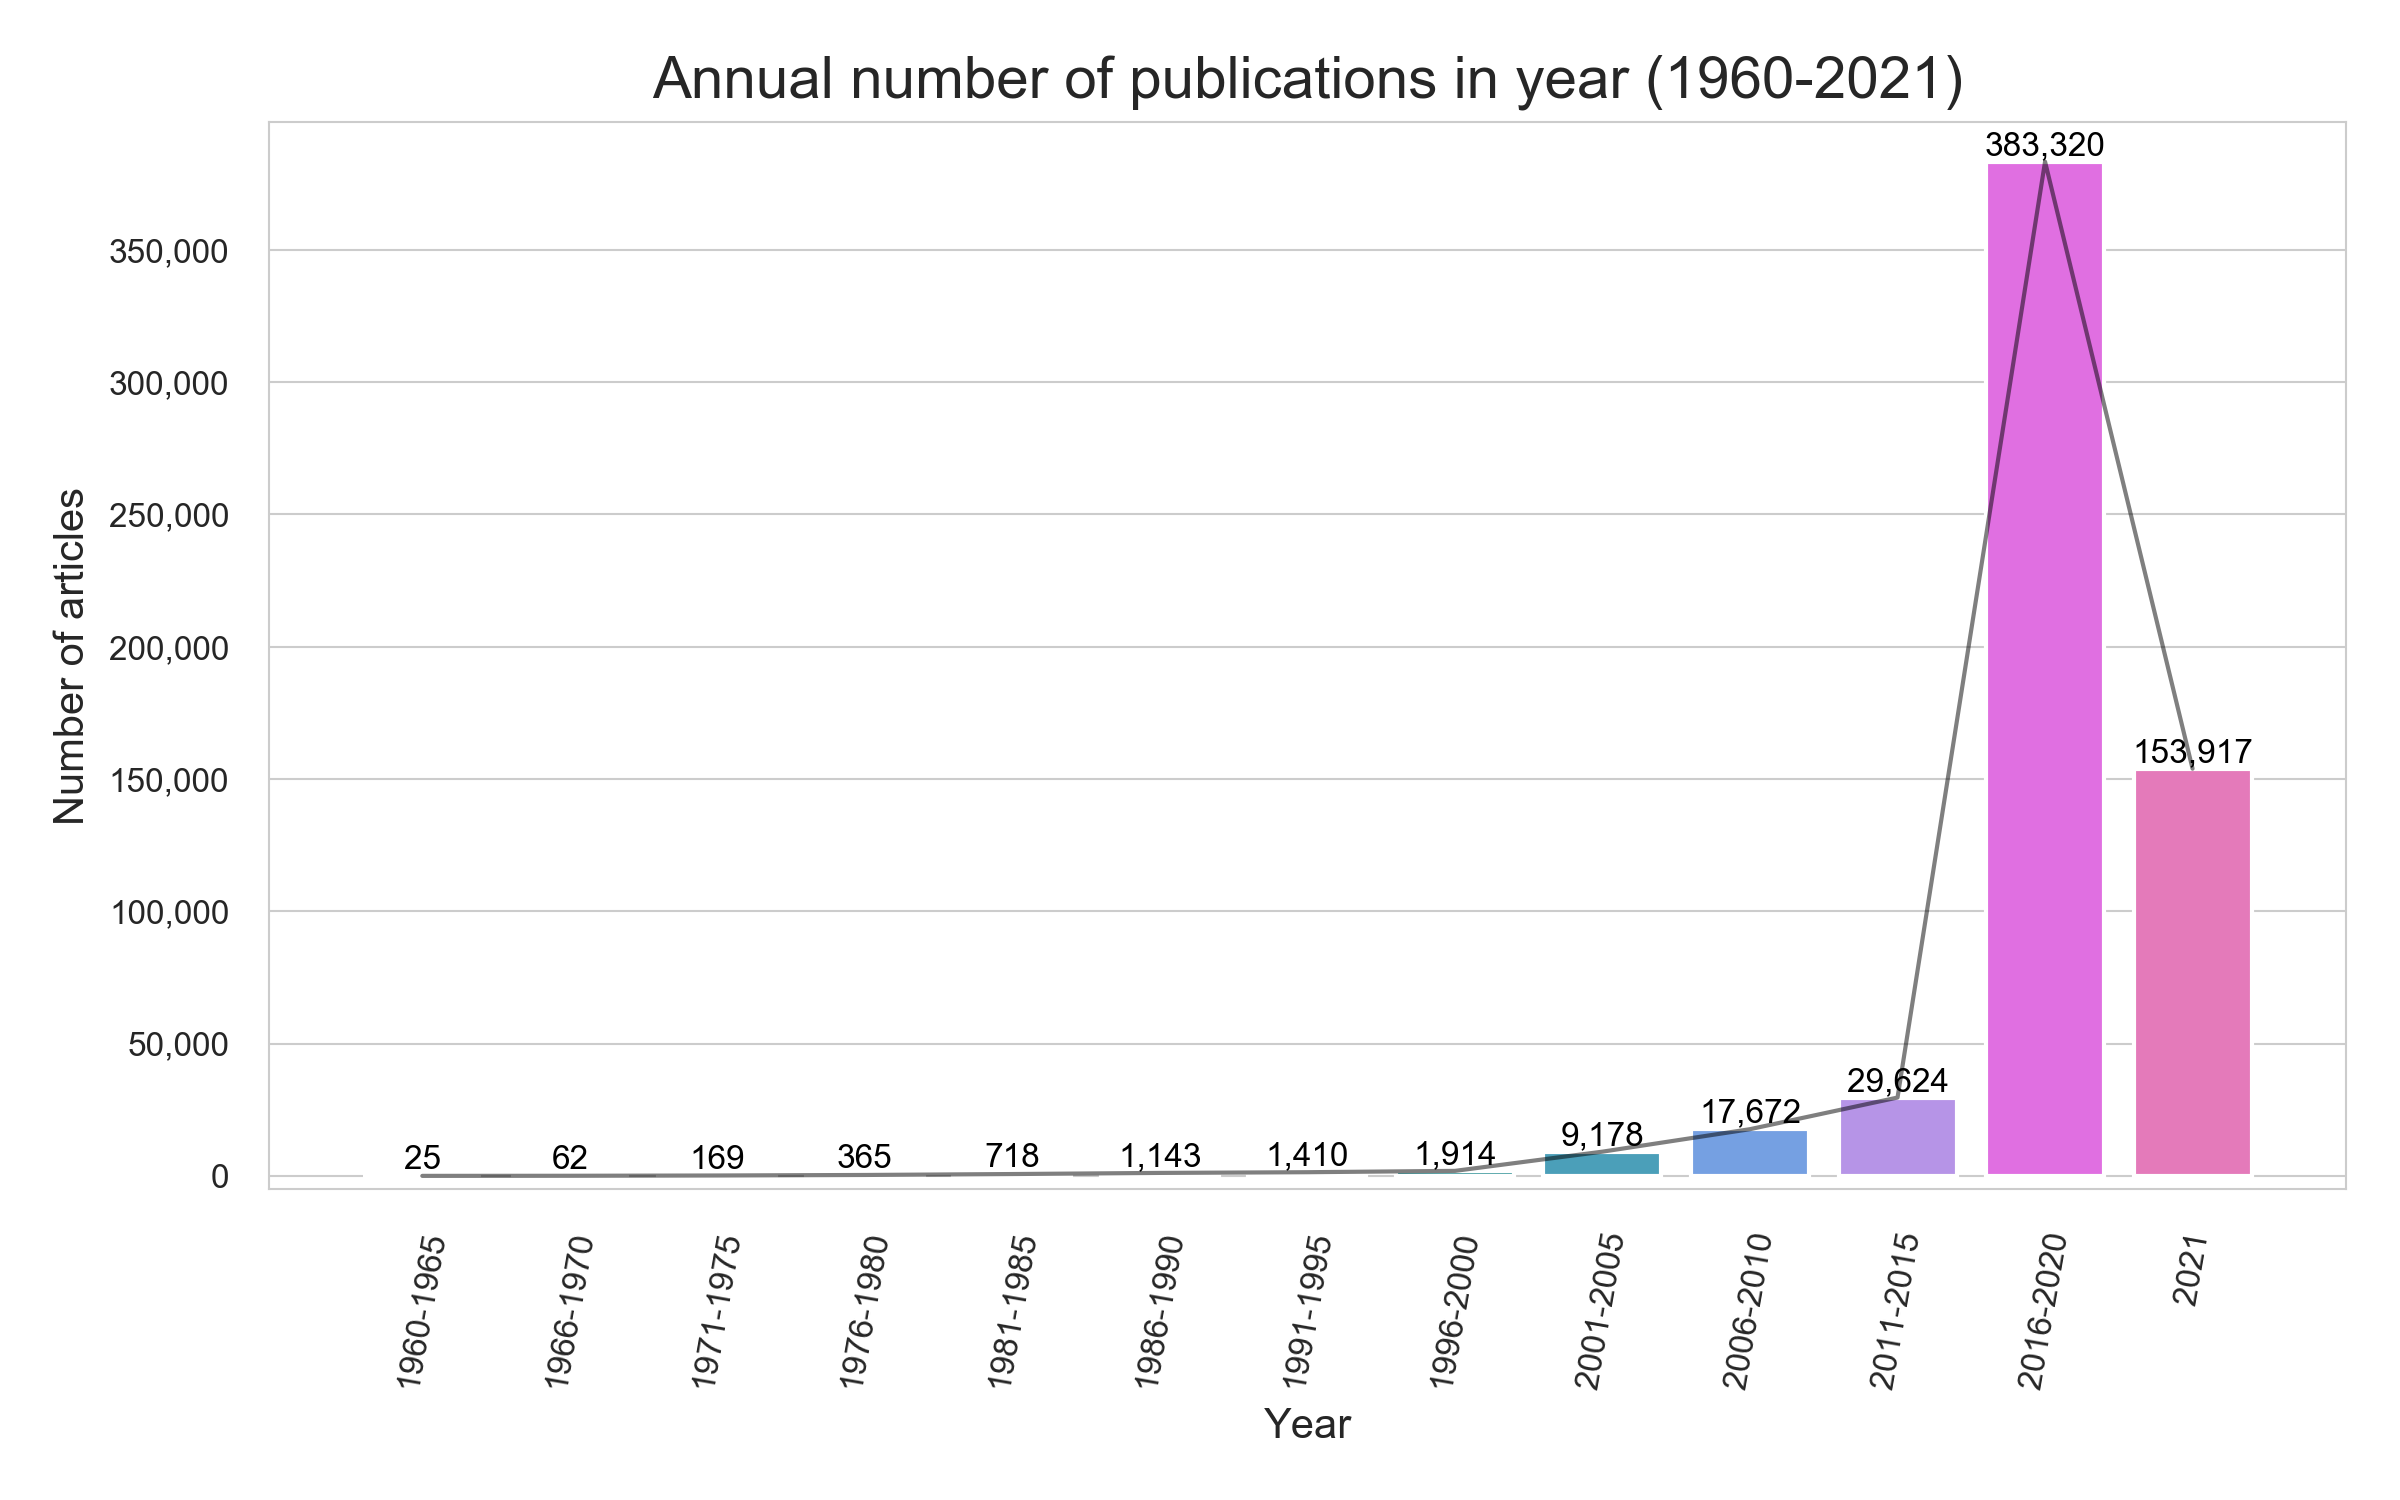

In [28]:
%%python
plot_figure(articles_in_period, 
            'period', 
            'count',
            'Annual number of publications in year (1960-2021)',
            'Year',
            'Number of articles',
            'Articles_in_1960-2021', 
            ['catplot', 'lineplot'], 
            1., 0.5, 80)

with tempfile.NamedTemporaryFile(suffix=".png") as tempImage:
        plt.savefig(tempImage.name)
        retval = Image(filename=tempImage.name)

Saving figure Articles_in_2012-2021


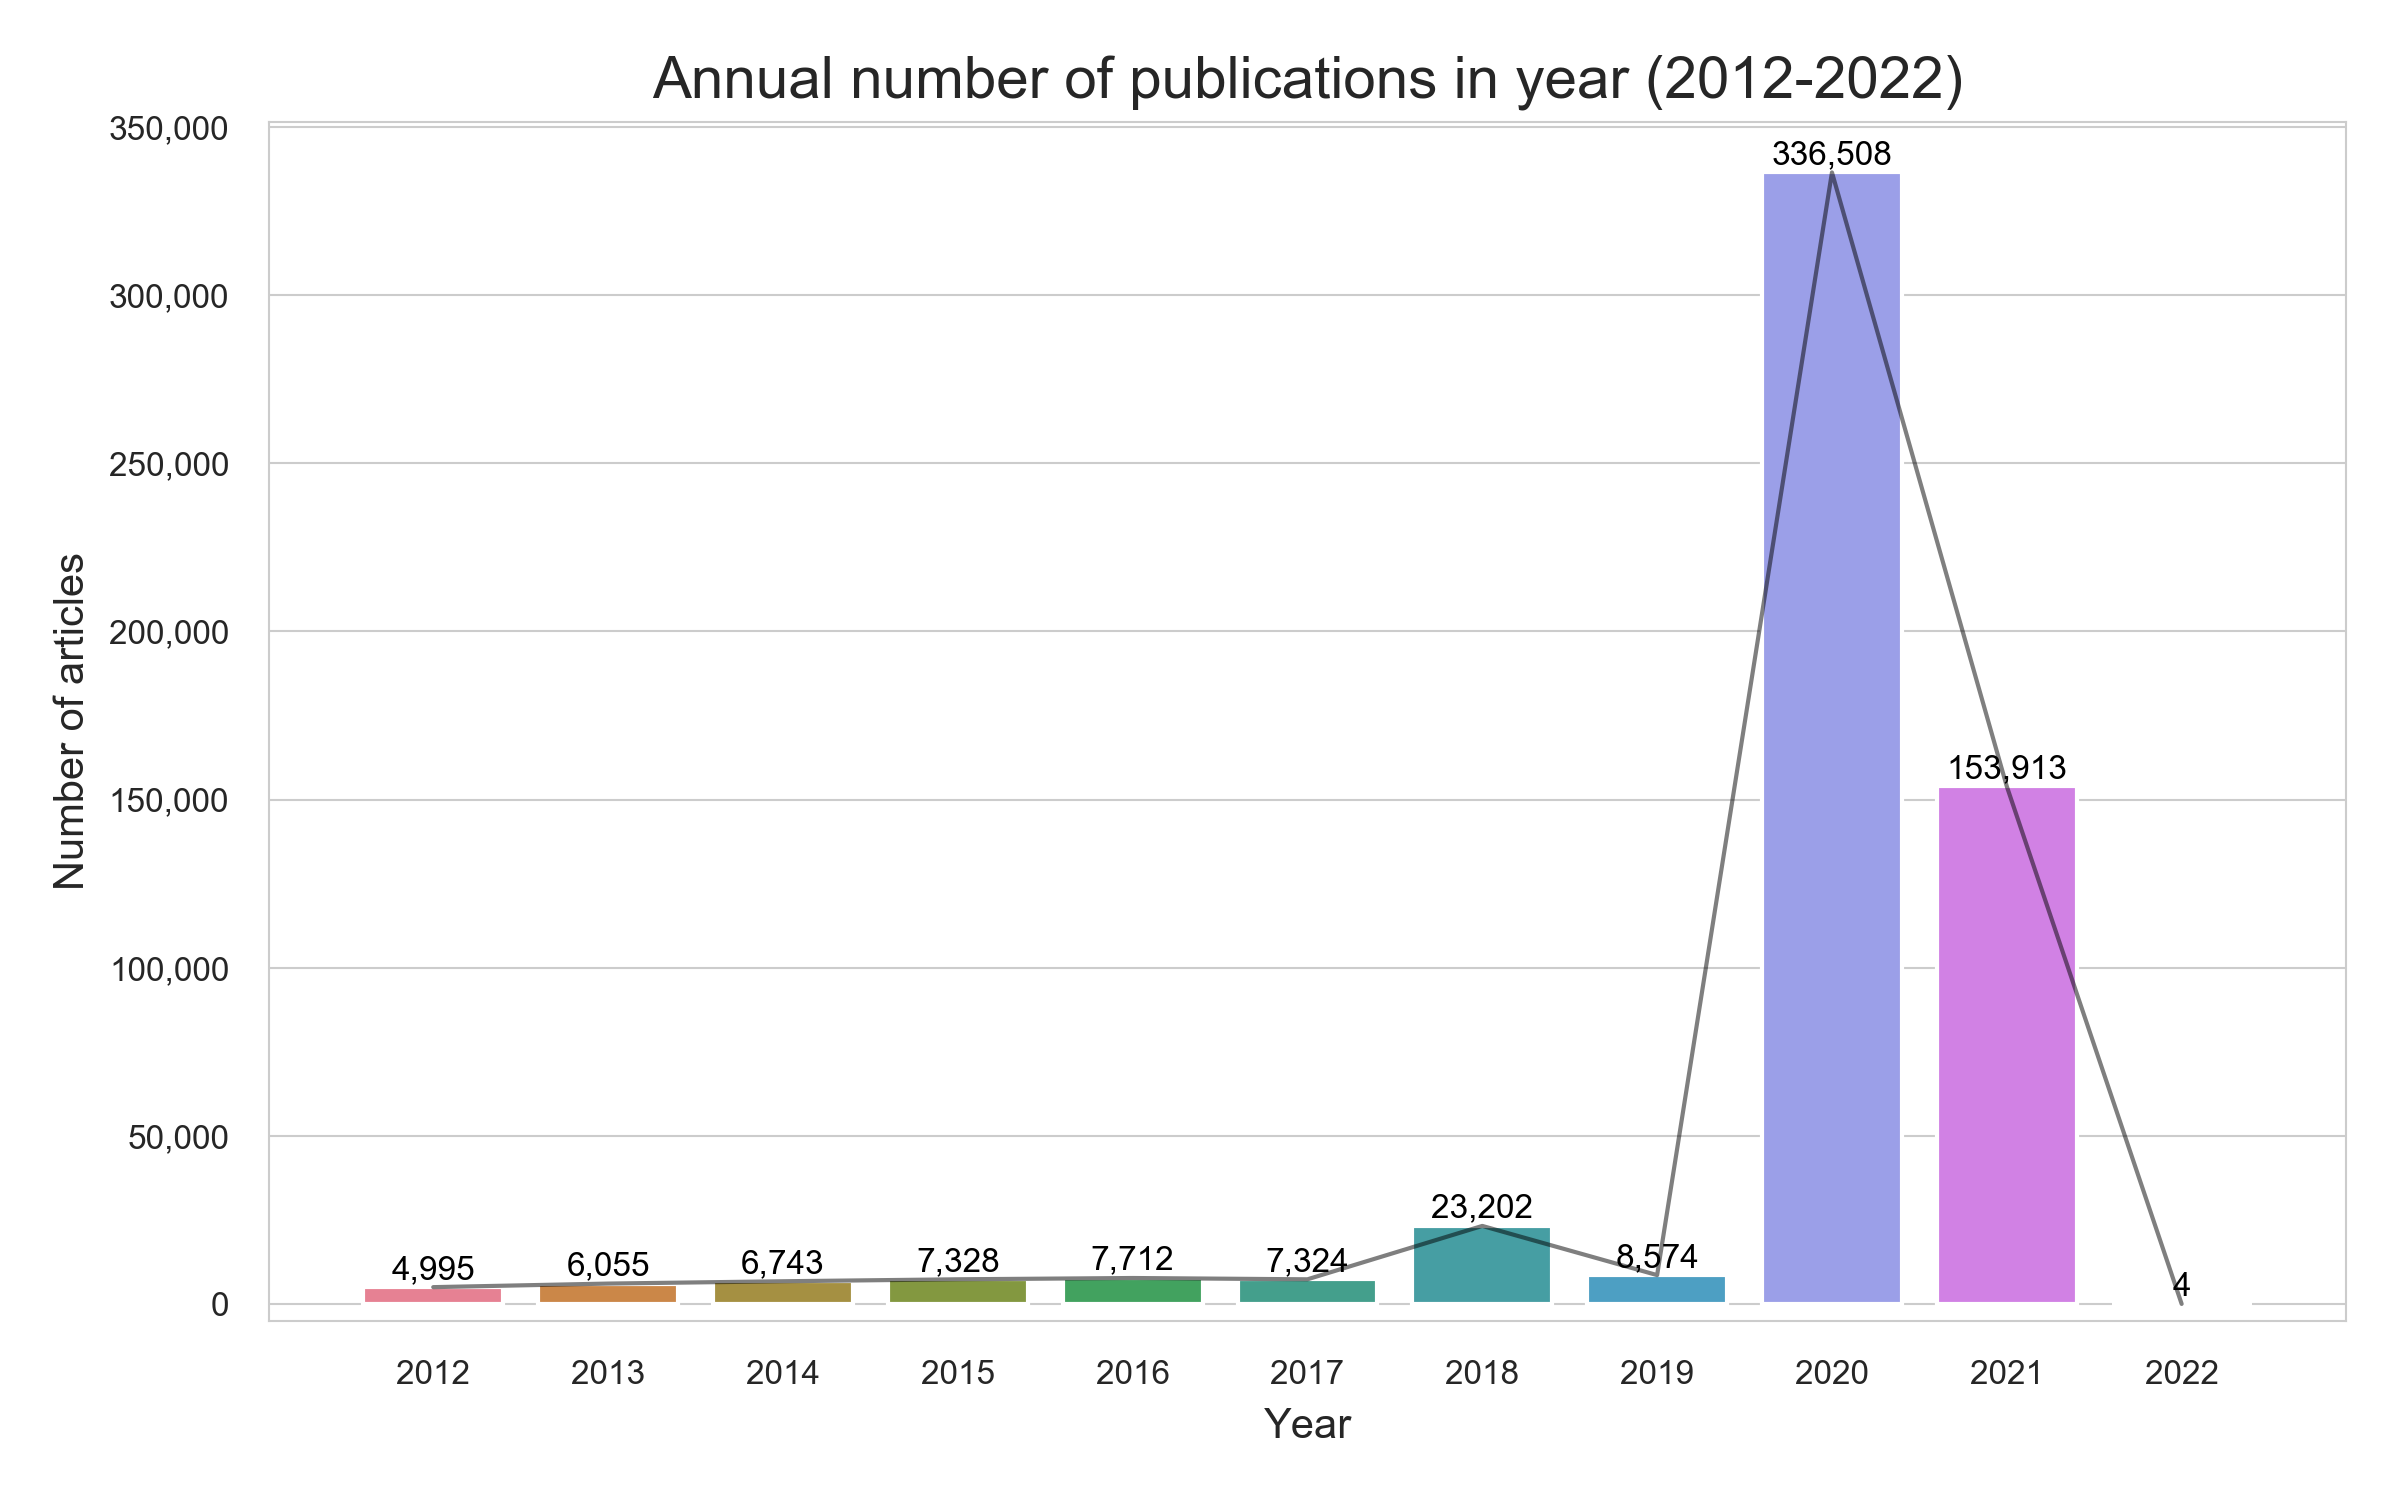

In [29]:
%%python
plot_figure(articles_last_ten_years, 
            'publish_time', 
            'count',
            'Annual number of publications in year (2012-2022)',
            'Year',
            'Number of articles',
            'Articles_in_2012-2021',
            ['catplot', 'lineplot'], 
            1., 0.5, 0)

with tempfile.NamedTemporaryFile(suffix=".png") as tempImage:
        plt.savefig(tempImage.name)
        retval = Image(filename=tempImage.name)

## <span style='color:Blue' id='3.3'> 3.3. Analysis of journals and autors

In [30]:
var journalDF = metadataDF.filter($"journal".isNotNull)
                          .groupBy($"journal")
                          .count
                          .orderBy($"count".desc)

                                                          

journalDF.show(3)

+--------+-----+
| journal|count|
+--------+-----+
| bioRxiv| 5578|
|PLoS One| 5422|
|     BMJ| 4942|
+--------+-----+
only showing top 3 rows



journalDF: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [journal: string, count: bigint]


In [31]:
// Using Python and pandas Library for better visibility of tables. metadata of the dateset.
journalDF.toDF.createOrReplaceTempView("journalDF_Py")

Saving figure Journals


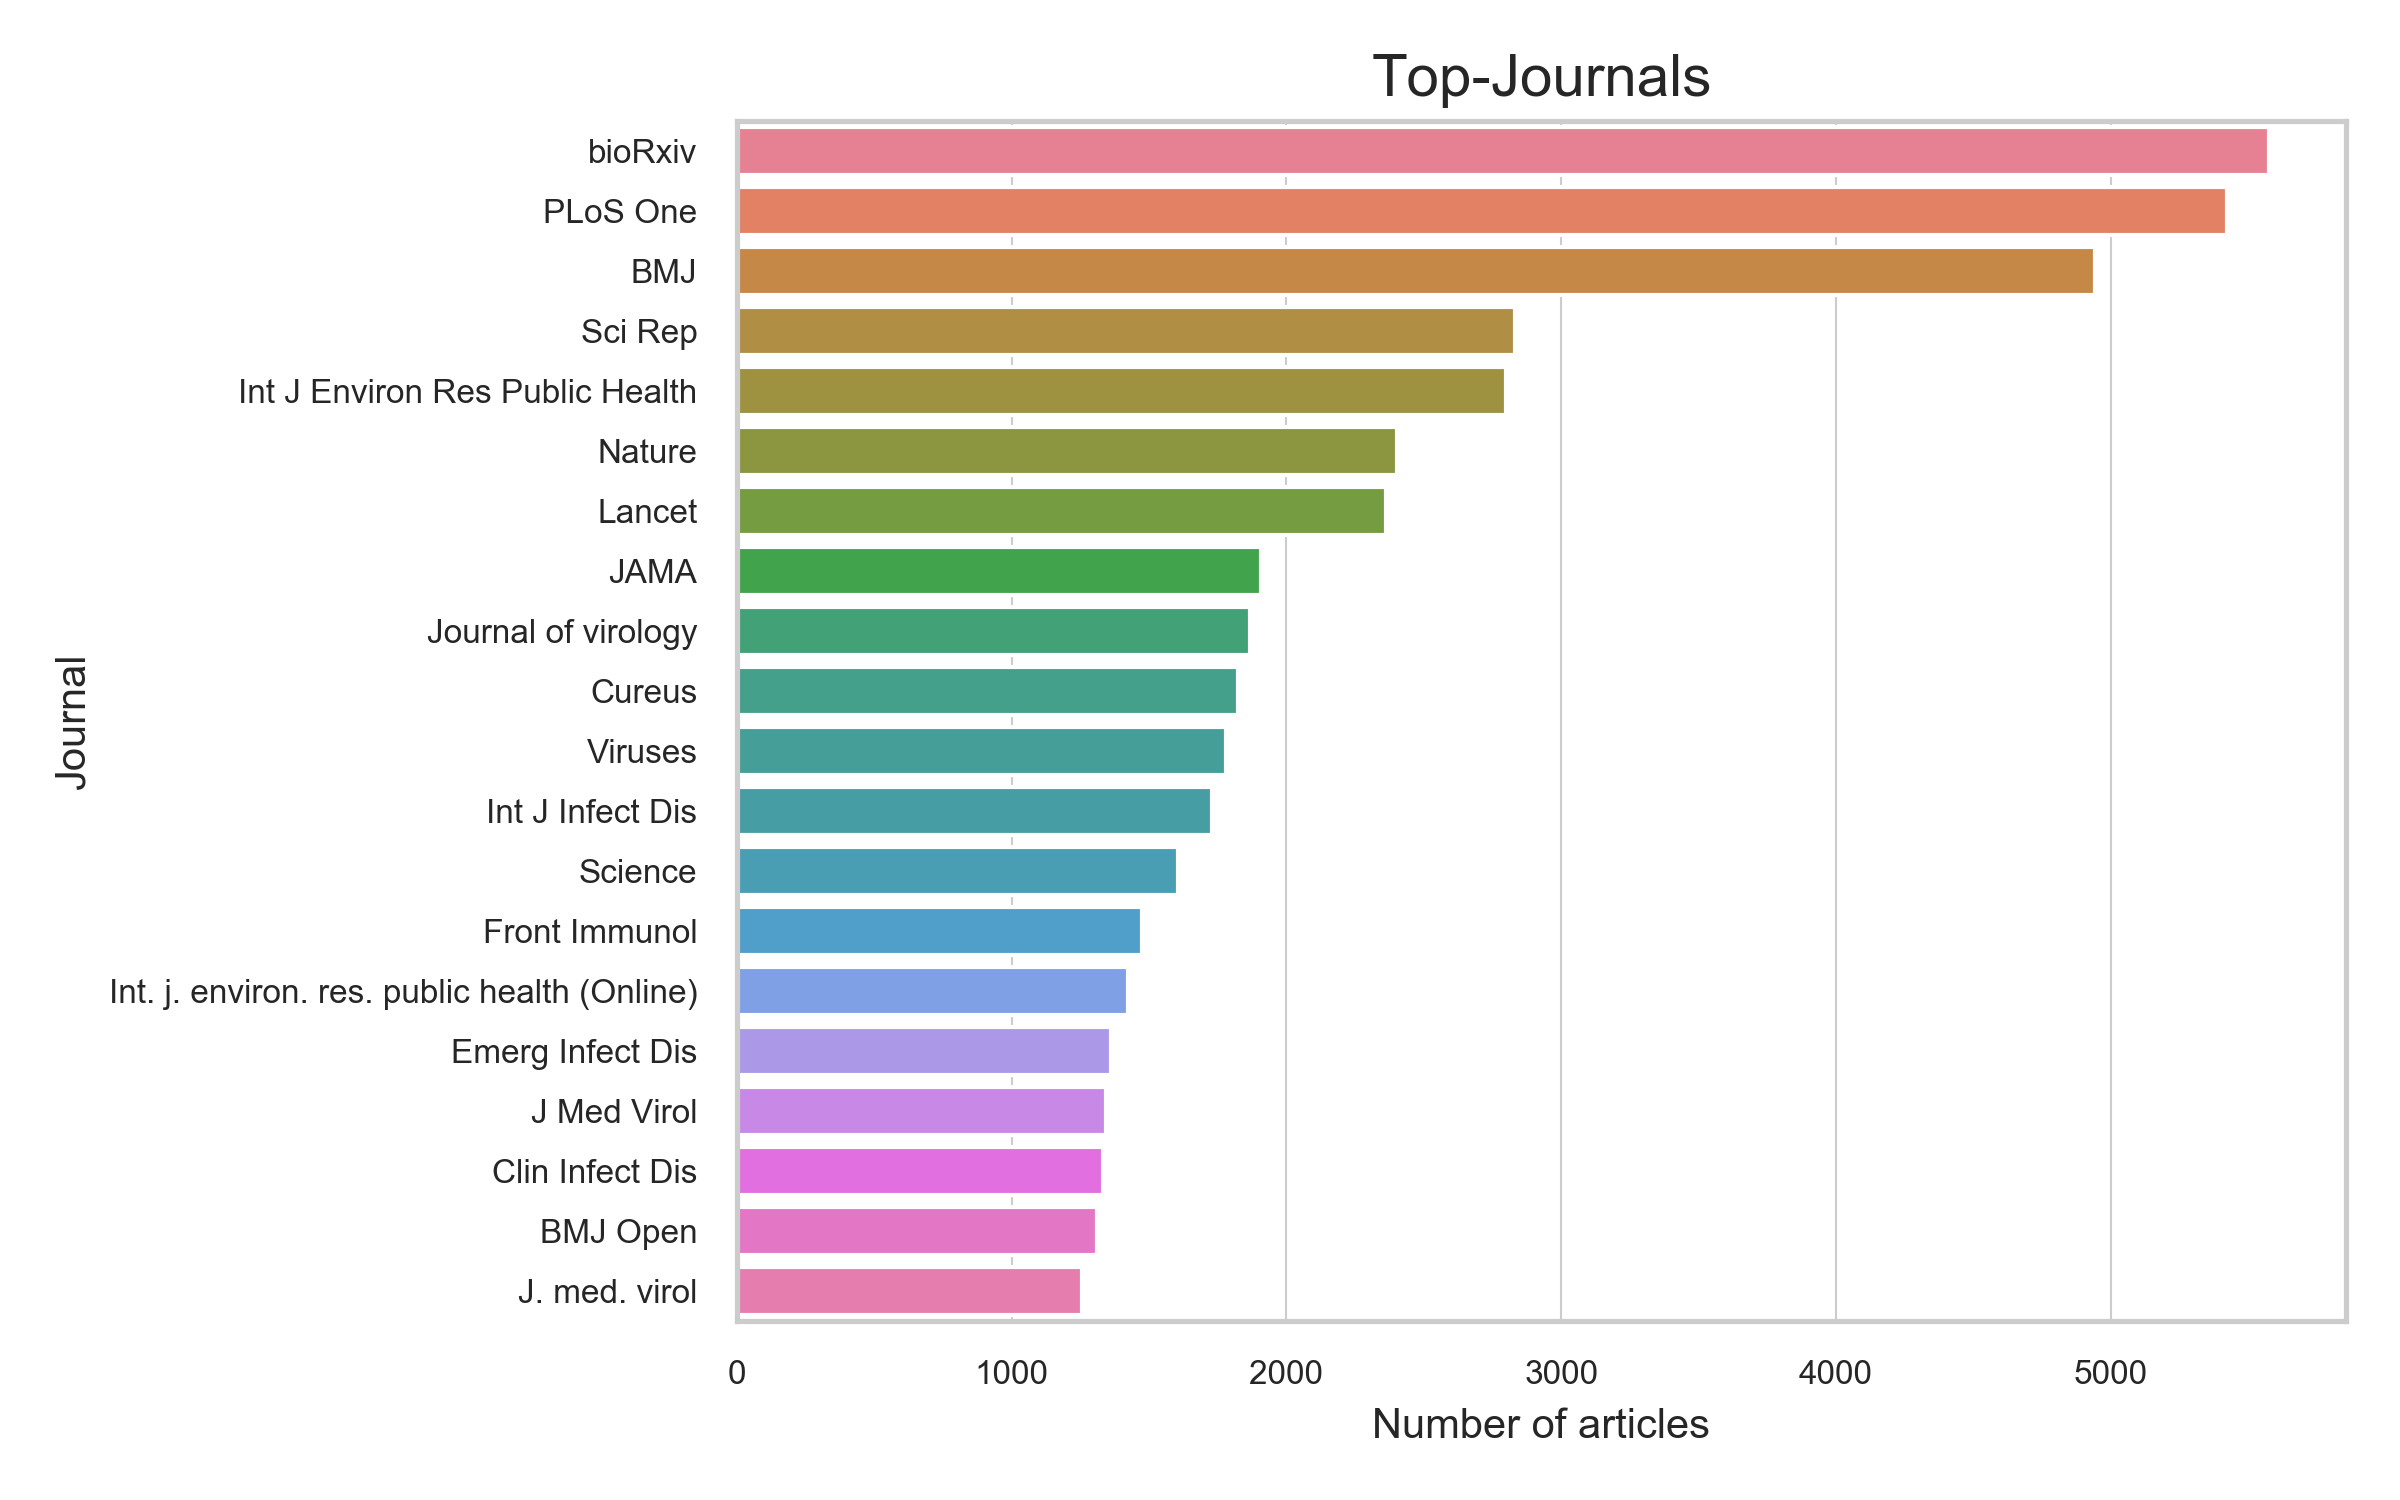

In [32]:
%%python
journalDF_Py = spark.sql("select * from journalDF_Py").toPandas()[:20]


plot_figure(journalDF_Py, 
            'count',
            'journal',
            'Top-Journals',
            'Number of articles',
            'Journal',
            'Journals',
            'barplot', 
            0.9, 0, 0)

with tempfile.NamedTemporaryFile(suffix=".png") as tempImage:
        plt.savefig(tempImage.name)
        retval = Image(filename=tempImage.name)

In [33]:
var authorsDF = metadataDF.filter($"authors".isNotNull 
                                 && $"authors".contains(",") 
                                 && !($"authors".contains("Anonymous")))
                          .groupBy($"authors")
                          .count
                          .orderBy($"count".desc)

                                                          

authorsDF.show(3, false)

+-----------------+-----+
|authors          |count|
+-----------------+-----+
|Mahase, Elisabeth|439  |
|Iacobucci, Gareth|340  |
|Rimmer, Abi      |264  |
+-----------------+-----+
only showing top 3 rows



authorsDF: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [authors: string, count: bigint]


In [34]:
// Using Python and pandas Library for better visibility of tables. metadata of the dateset.
authorsDF.toDF.createOrReplaceTempView("authorsDF_Py")

Saving figure Authors


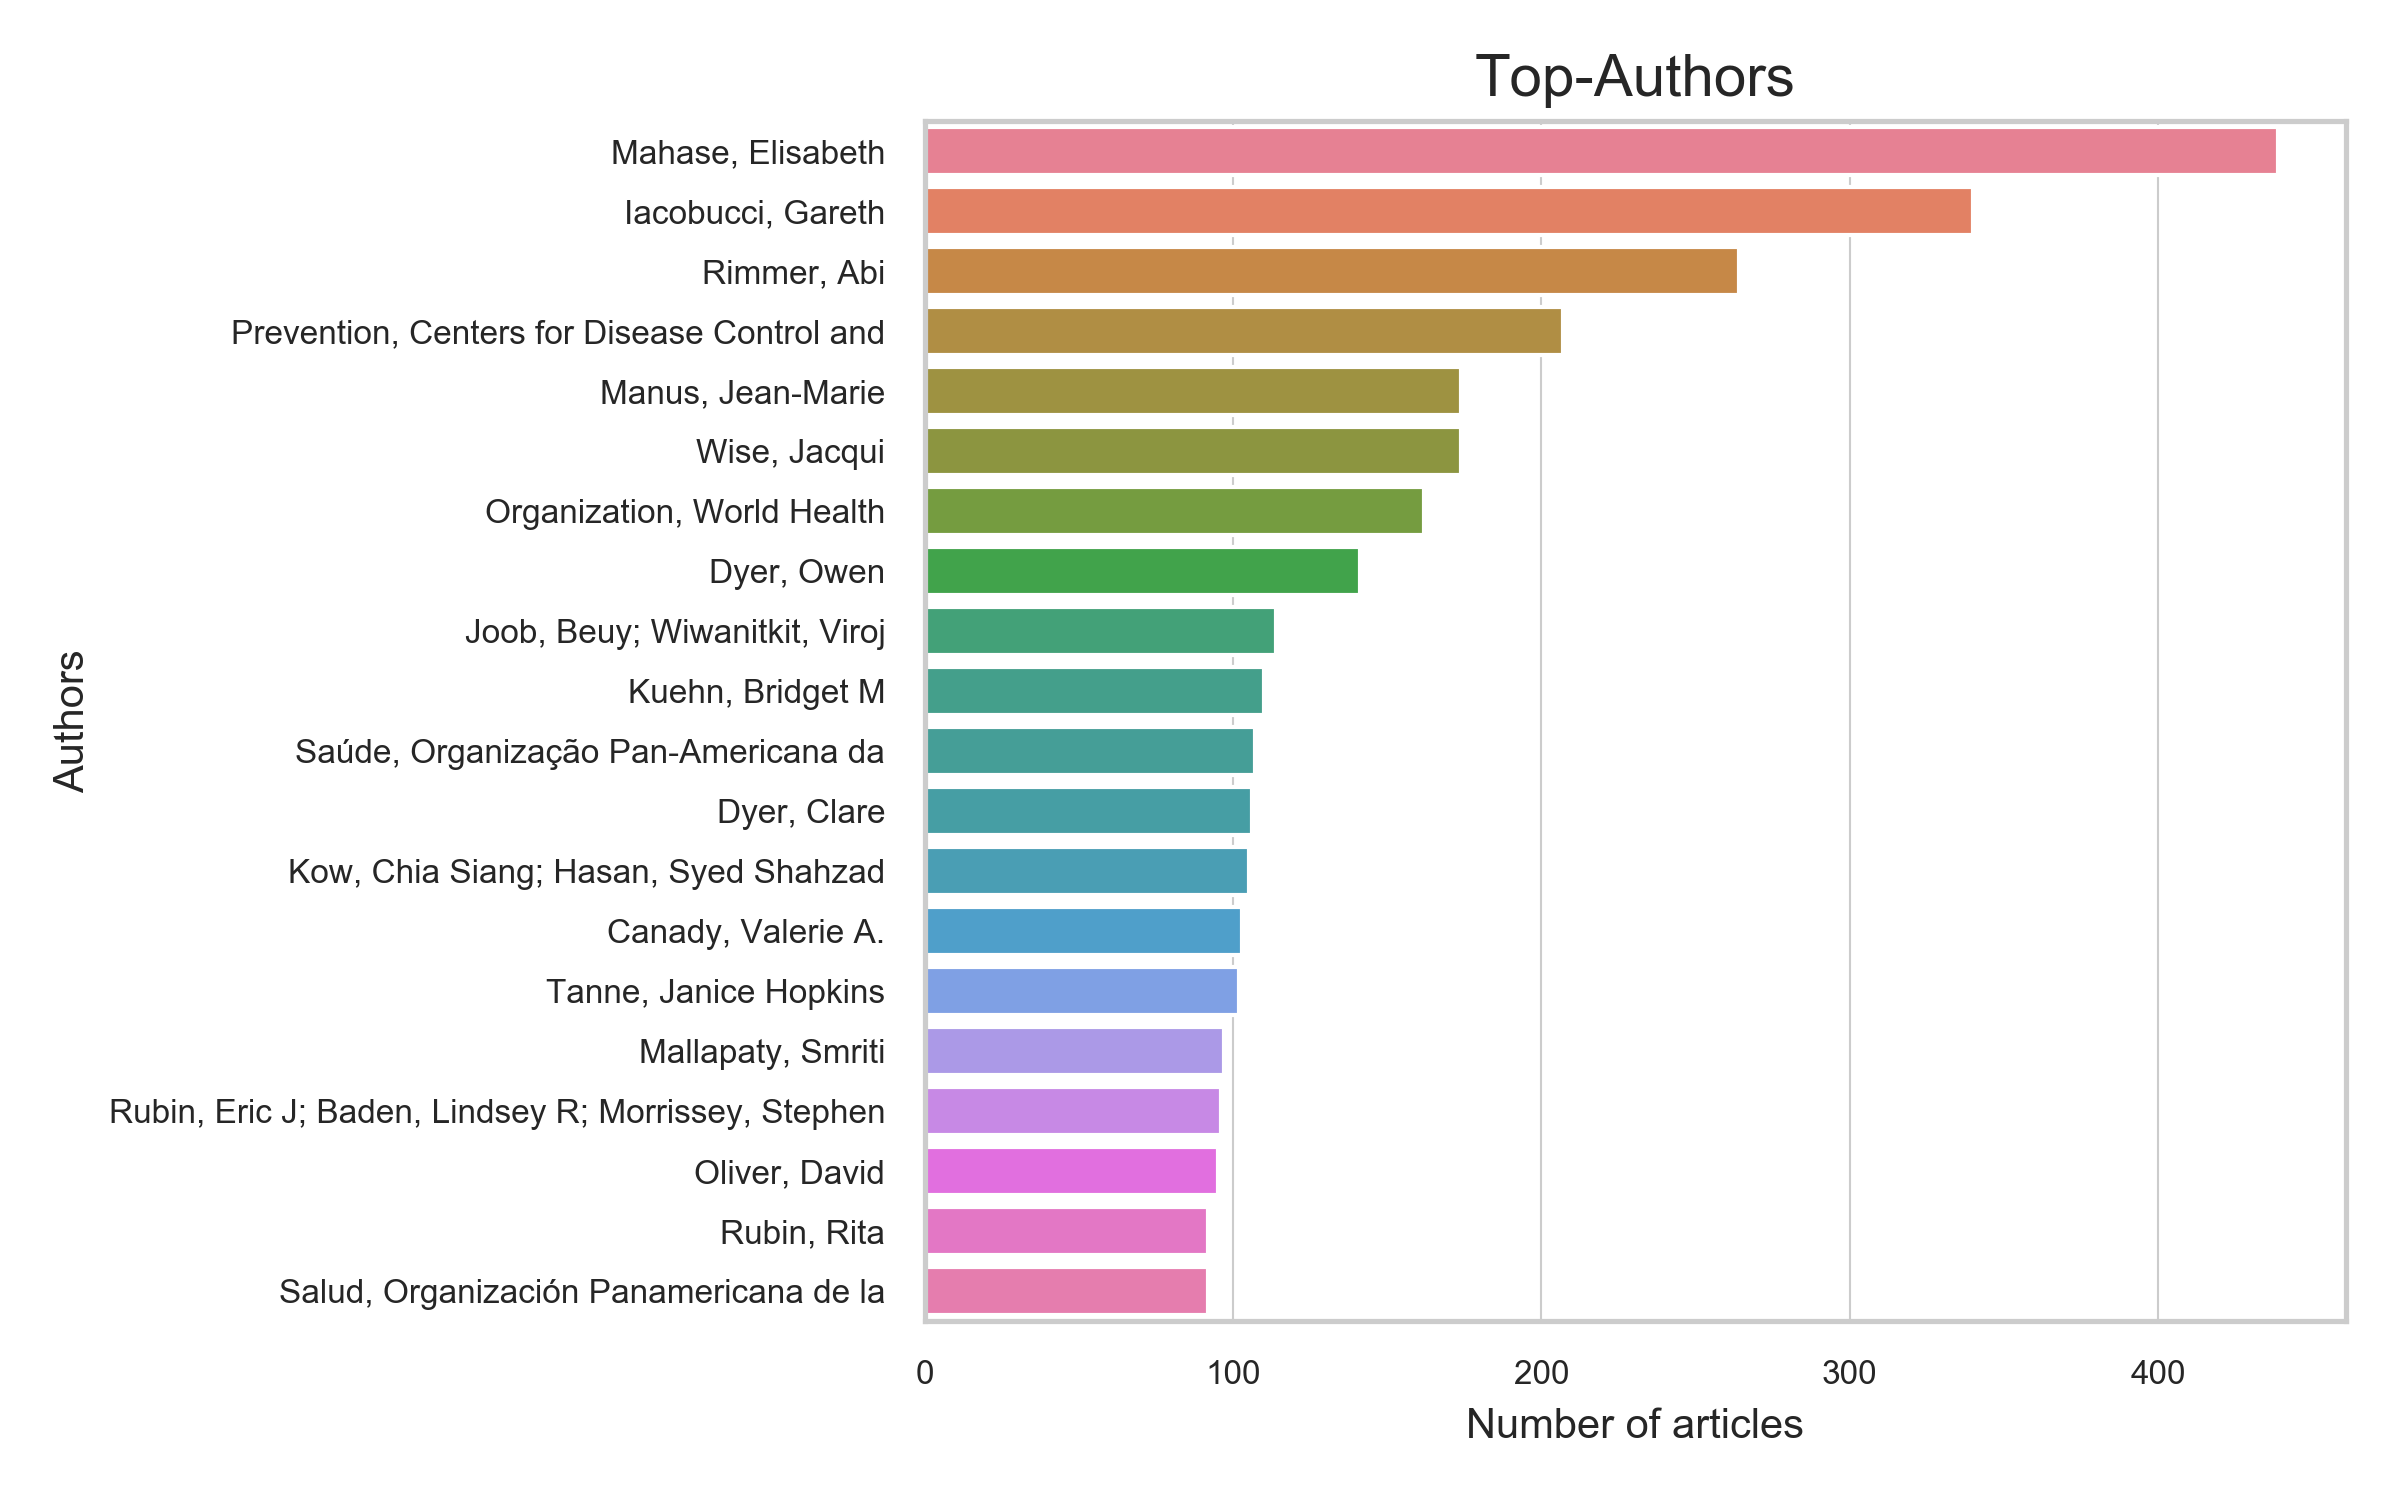

In [35]:
%%python
authorsDF_Py = spark.sql("select * from authorsDF_Py").toPandas()[:20]


plot_figure(authorsDF_Py, 
            'count',
            'authors',
            'Top-Authors',
            'Number of articles',
            'Authors',
            'Authors',
            'barplot', 
            0.9, 0, 0)

with tempfile.NamedTemporaryFile(suffix=".png") as tempImage:
        plt.savefig(tempImage.name)
        retval = Image(filename=tempImage.name)

## <span style='color:Blue' id='3.4'> 3.4. Analysis of text columns

In [36]:
%%time

//Count of null and missing values of text columns dataframe
var textColumnsDF = metadataDF
                        .withColumn("pdf_json_files", when(col("pdf_json_files").isNull || col("pdf_json_files") === "" || col("pdf_json_files").isNaN, 0)                            
                                                    .otherwise(1))
                        .withColumn("pmc_json_files", when(col("pmc_json_files").isNull || col("pmc_json_files") === "" || col("pmc_json_files").isNaN, 0)                            
                                                    .otherwise(1))
                        .withColumn("abstract", when(col("abstract").isNull || col("abstract") === "" || col("abstract").isNaN, 0)                            
                                                    .otherwise(1))                        
                        .agg(sum("pdf_json_files").as("pdf_files"),
                             sum("abstract").as("abstract_text"),
                             sum("pmc_json_files").as("pmc_files"))


                        
                        
textColumnsDF = textColumnsDF.withColumn("columns_text", lit("count"))
                .select("columns_text",  "pdf_files","abstract_text","pmc_files")
textColumnsDF.show()

textColumnsDF = transposeDataFrame(textColumnsDF, Seq("pdf_files", "abstract_text", "pmc_files"), "columns_text")
                .withColumn("count", col("count").cast("Integer"))
textColumnsDF.show(false)

+------------+---------+-------------+---------+
|columns_text|pdf_files|abstract_text|pmc_files|
+------------+---------+-------------+---------+
|       count|   210709|       439506|   172370|
+------------+---------+-------------+---------+

+-------------+------+
|columns_text |count |
+-------------+------+
|pdf_files    |210709|
|abstract_text|439506|
|pmc_files    |172370|
+-------------+------+

Time: 11.041172981262207 seconds.



textColumnsDF: org.apache.spark.sql.DataFrame = [columns_text: string, count: int]
textColumnsDF: org.apache.spark.sql.DataFrame = [columns_text: string, count: int]
textColumnsDF: org.apache.spark.sql.DataFrame = [columns_text: string, count: int]


In [37]:
// Using Python and Pandas Library for better visibility of tables. metadata of the dateset.
textColumnsDF.toDF.createOrReplaceTempView("textColumnsDf_Py")

Saving figure Columns_with_text


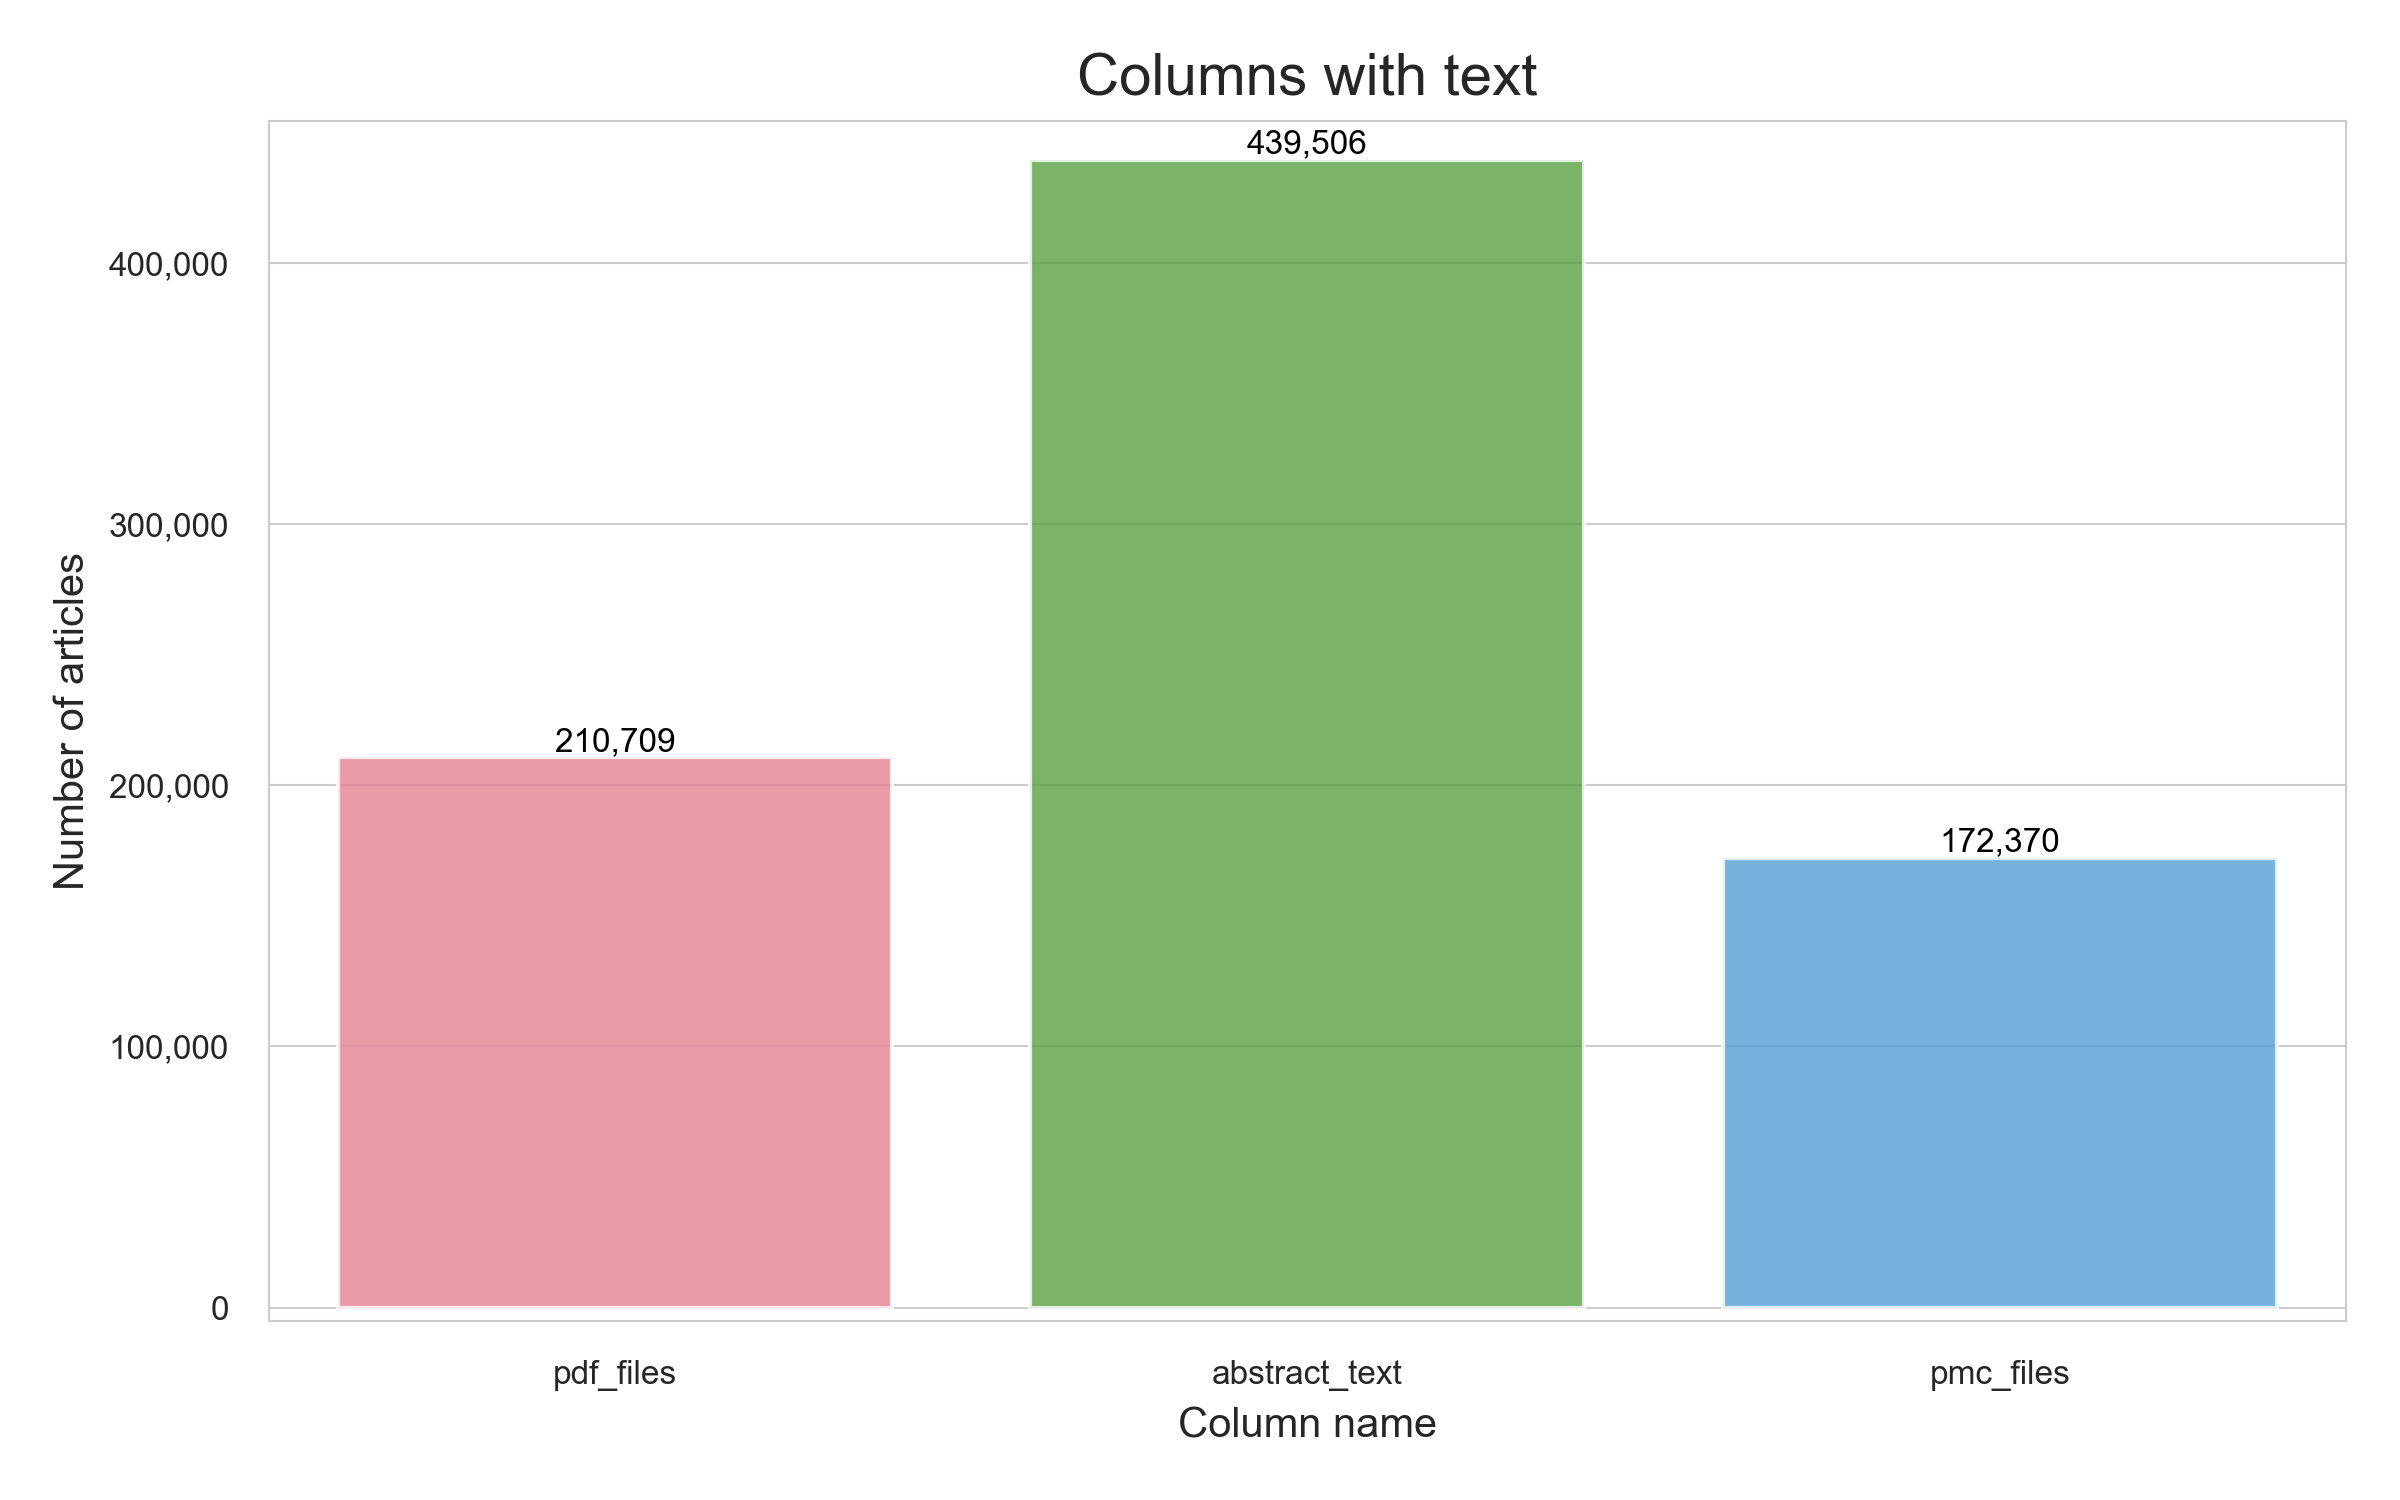

In [38]:
%%python

textColumnsDf_Py = spark.sql("select * from textColumnsDf_Py").toPandas()

plot_figure(textColumnsDf_Py,
            'columns_text',
            'count',
            'Columns with text',
            'Column name',
            'Number of articles',
            'Columns_with_text', 
            ['catplot'], 
            0.8, 0.0, 0)

with tempfile.NamedTemporaryFile(suffix=".png") as tempImage:
        plt.savefig(tempImage.name)
        retval = Image(filename=tempImage.name)

In [39]:
%%time

//Analyse with body_text withot body text
var bodyTextDF = metadataDF
                        .filter(col("publish_time")>1959)
                        .withColumn("has_body_text", when((col("pdf_json_files").isNull || col("pdf_json_files") === "" || col("pdf_json_files").isNaN) &&
                                                          (col("pmc_json_files").isNull || col("pmc_json_files") === "" || col("pmc_json_files").isNaN), "No")                            
                                                    .otherwise("Yes"))
val bodyTextDF_1960_2017 = bodyTextDF.filter(col("publish_time")<2018) 
val bodyTextDF_2018_2021 = bodyTextDF.filter(col("publish_time")>2017 && col("publish_time")<2022)

                       

Time: 0.19472002983093262 seconds.



bodyTextDF: org.apache.spark.sql.DataFrame = [cord_uid: string, title: string ... 7 more fields]
bodyTextDF_1960_2017: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [cord_uid: string, title: string ... 7 more fields]
bodyTextDF_2018_2021: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [cord_uid: string, title: string ... 7 more fields]


In [40]:
bodyTextDF_2018_2021.groupBy("has_body_text", "publish_time")
                       .pivot("publish_time")
                       .count()
                       .groupBy("has_body_text")
                       .agg(sum("2018").as("2018"),
                           sum("2019").as("2019"),
                           sum("2020").as("2020"),                           
                           sum("2021").as("2021")).show()

+-------------+-----+----+------+-----+
|has_body_text| 2018|2019|  2020| 2021|
+-------------+-----+----+------+-----+
|           No| 6562|3950|228274|97880|
|          Yes|16640|4624|108234|56033|
+-------------+-----+----+------+-----+



In [41]:
// Using Python and Pandas Library for better visibility of tables. metadata of the dateset.
bodyTextDF_1960_2017.toDF.createOrReplaceTempView("bodyTextDF_1960_2017_PY")
bodyTextDF_2018_2021.toDF.createOrReplaceTempView("bodyTextDF_2018_2021_PY")

Saving figure Availability_of_the_body_text_1960-2017
Time: 9.21487021446228 seconds.



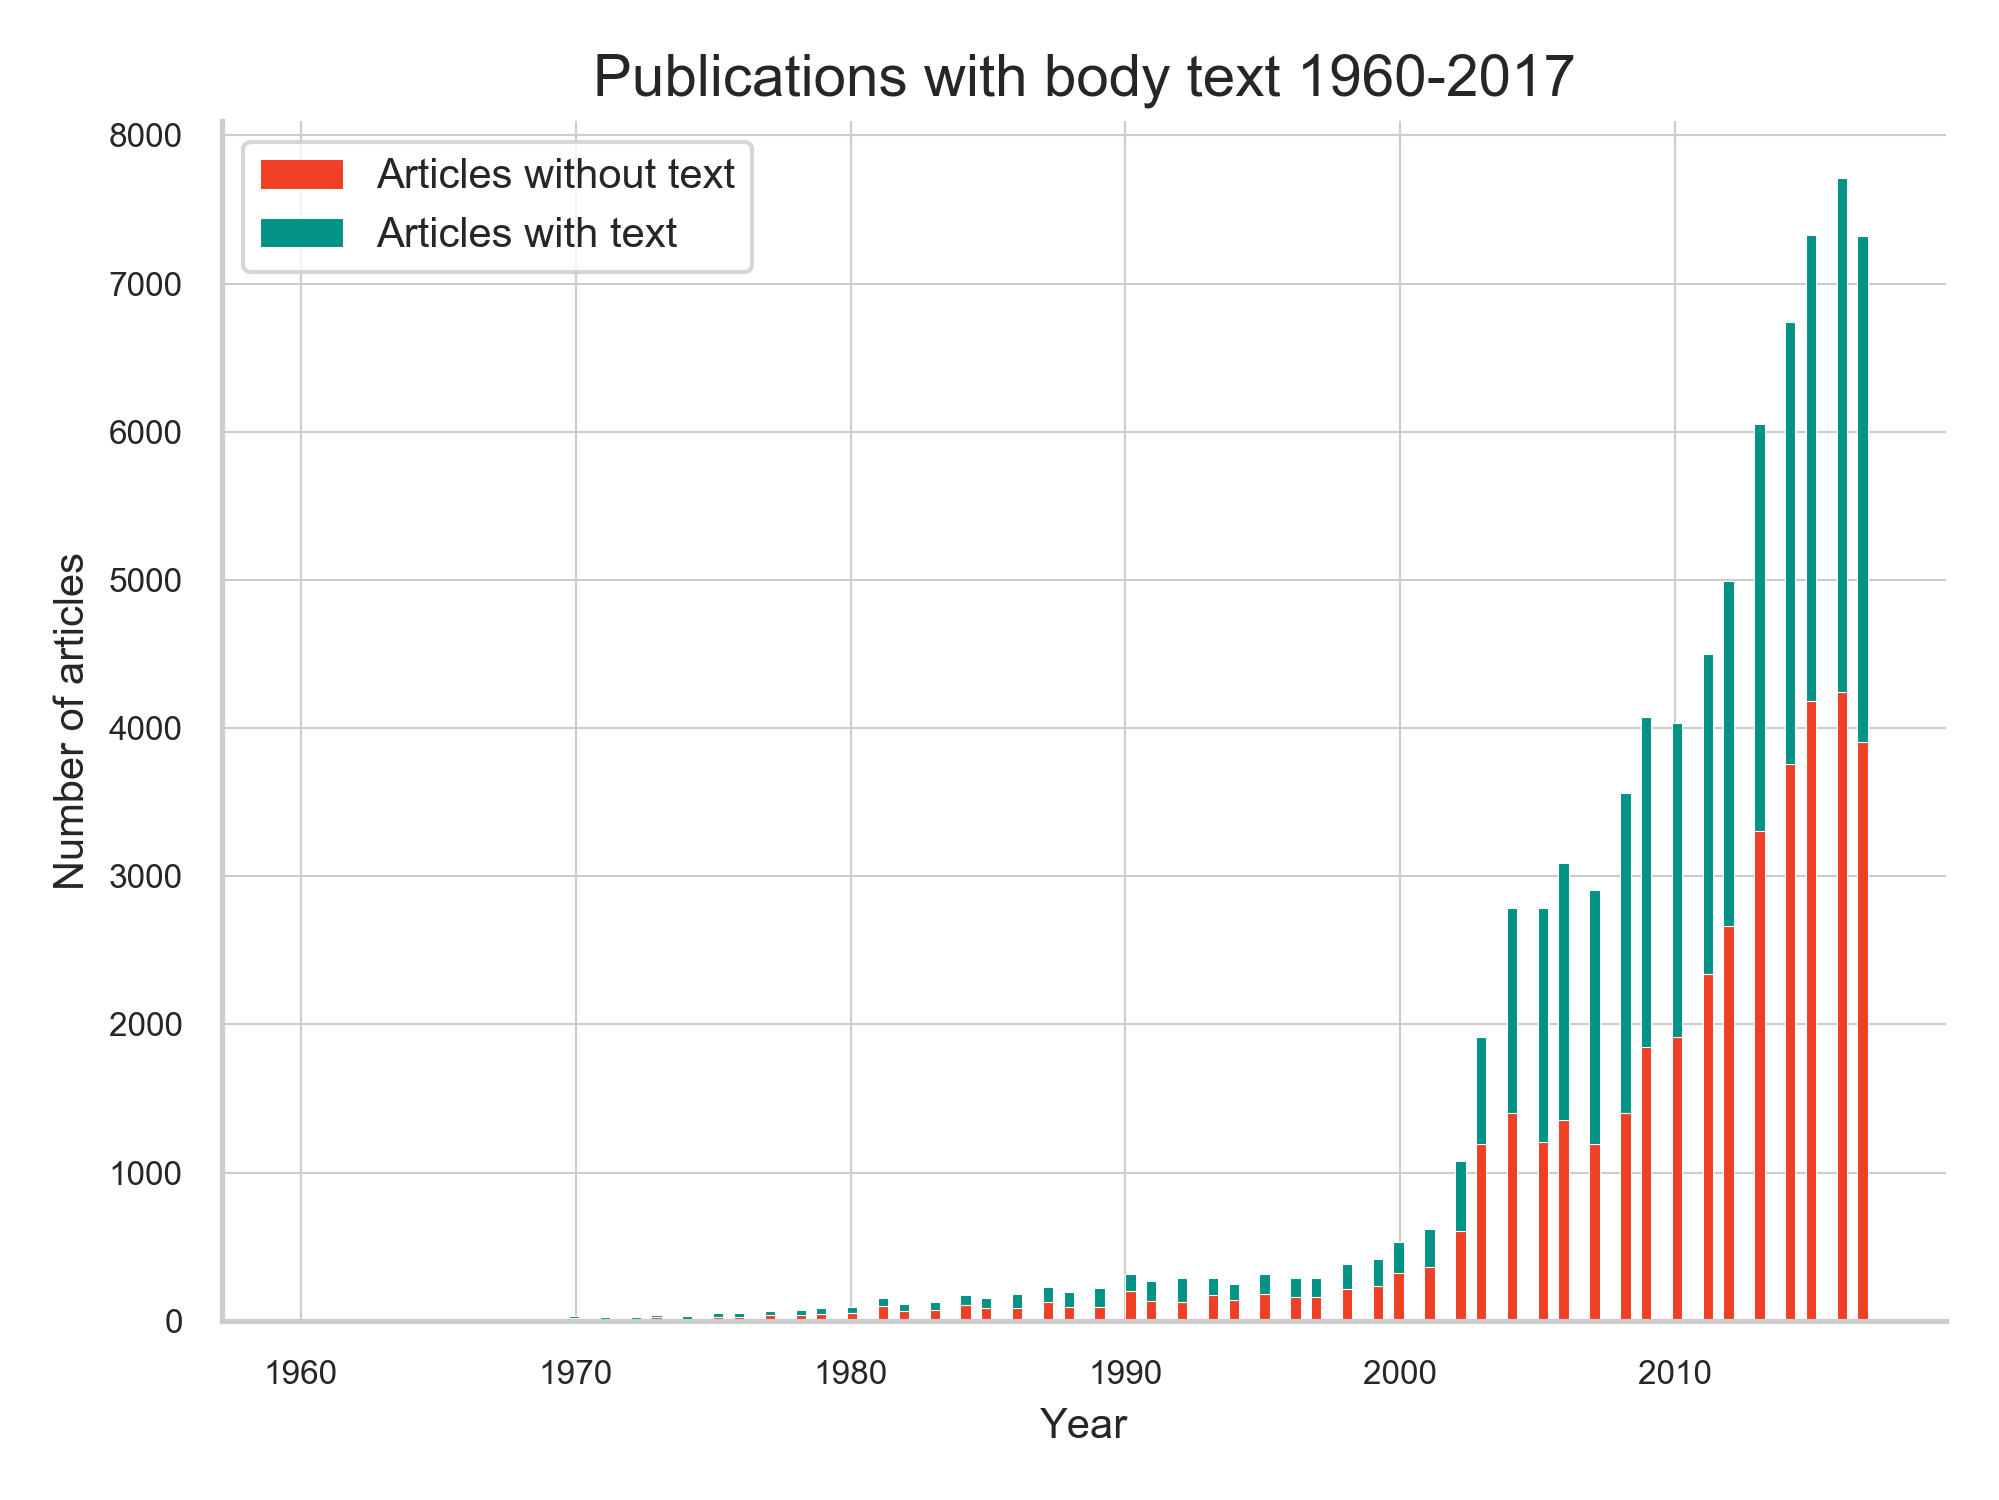

In [42]:
%%time
%%python

bodyTextDF_1960_2017_PY = spark.sql("select has_body_text, publish_time from bodyTextDF_1960_2017_PY").toPandas()
bodyTextDF_2018_2021_PY = spark.sql("select has_body_text, publish_time from bodyTextDF_2018_2021_PY").toPandas()

bodyTextDF_2018_2021_PY['publish_time'] = bodyTextDF_2018_2021_PY['publish_time'].apply(str)


plot_figure(bodyTextDF_1960_2017_PY,
            'publish_time',
            'has_body_text',
            'Publications with body text 1960-2017',
            'Year',
            'Number of articles',
            'Availability_of_the_body_text_1960-2017', 
            ['steck_text'], 
            1., 0.7, 0)

with tempfile.NamedTemporaryFile(suffix=".png") as tempImage:
        plt.savefig(tempImage.name)
        retval = Image(filename=tempImage.name)

Saving figure Availability_of_the_body_text_2018_2021
Time: 1.2576401233673096 seconds.



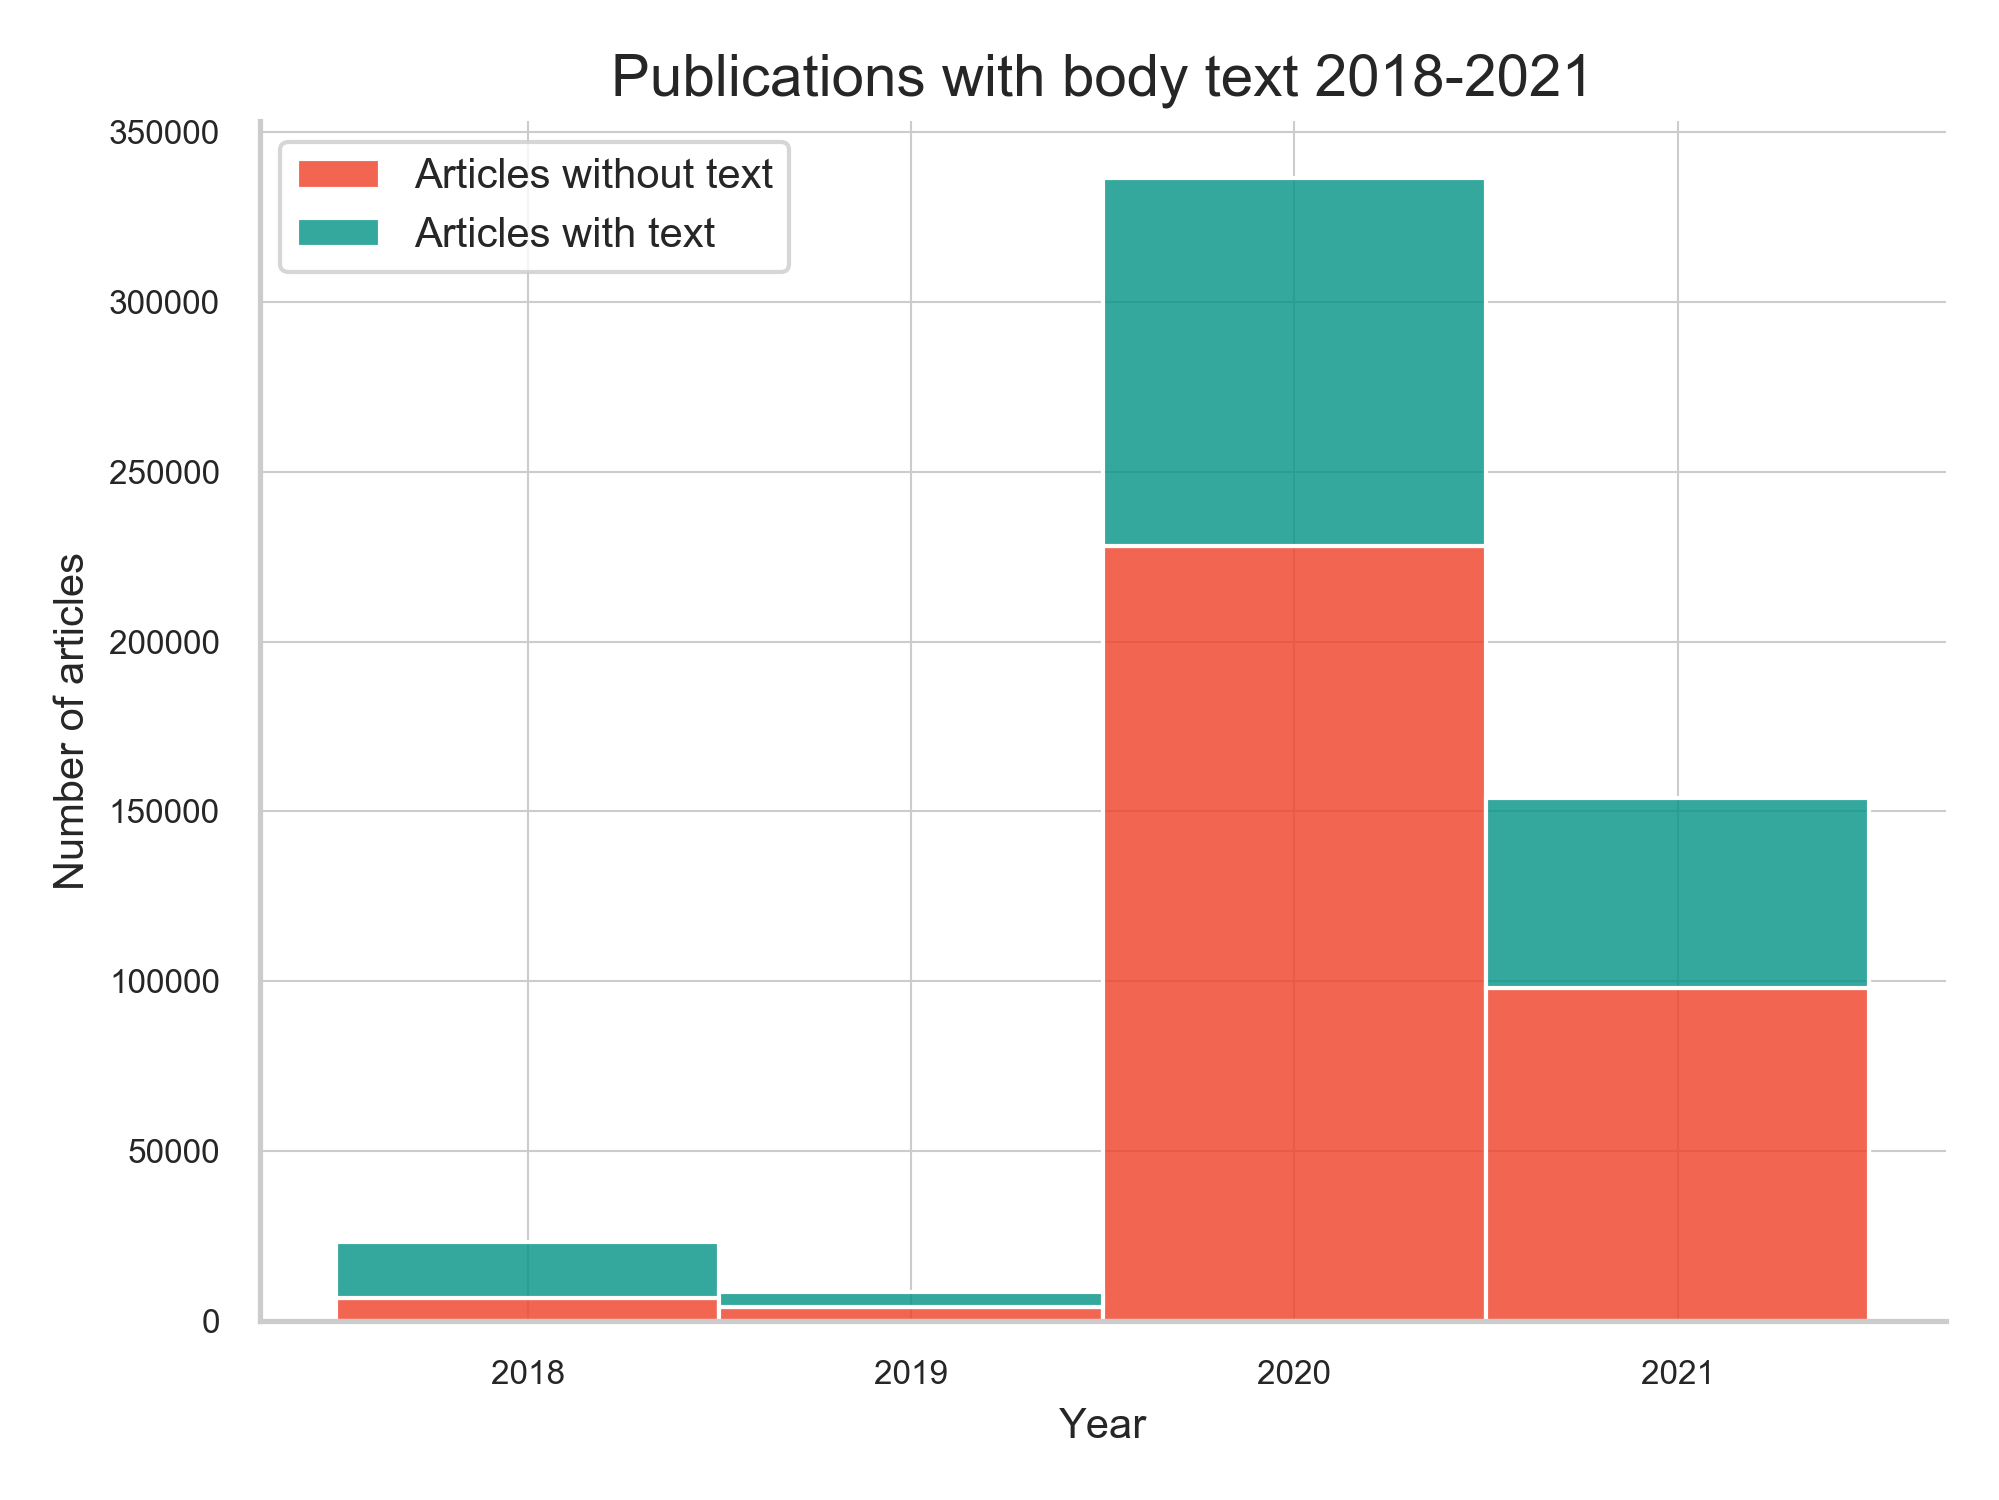

In [43]:
%%time
%%python
plot_figure(bodyTextDF_2018_2021_PY,
            'publish_time',
            'has_body_text',
            'Publications with body text 2018-2021',
            'Year',
            'Number of articles',
            'Availability_of_the_body_text_2018_2021', 
            ['steck_text'], 
            0.8, 0.7, 0)

with tempfile.NamedTemporaryFile(suffix=".png") as tempImage:
        plt.savefig(tempImage.name)
        retval = Image(filename=tempImage.name)

## <span style='color:Blue' id='3.5'> 3.5. Analysis of Abstract content

In [44]:
%%time
val abstractDF = metadataDF
                       .withColumn("group_year", when(col("publish_time") >= 2012,"2012-2021")
                                                .when(col("publish_time") < 2012,"1452-2011")
                                                .otherwise("-"))
                       .withColumn("has_abstract", when(col("abstract").isNull,"No")
                                                .otherwise("Yes"))


val hasAbstractDF = abstractDF
                       .groupBy("has_abstract", "group_year")
                       .pivot("group_year")
                       .count()
                       .groupBy("has_abstract")
                       .agg(sum("2012-2021").as("2012-2021"),
                            sum("1452-2011").as("1452-2011"))

hasAbstractDF.printSchema()
hasAbstractDF.show()

root
 |-- has_abstract: string (nullable = false)
 |-- 2012-2021: long (nullable = true)
 |-- 1452-2011: long (nullable = true)

+------------+---------+---------+
|has_abstract|2012-2021|1452-2011|
+------------+---------+---------+
|          No|   152029|     8081|
|         Yes|   410329|    29177|
+------------+---------+---------+

Time: 7.98022198677063 seconds.



abstractDF: org.apache.spark.sql.DataFrame = [cord_uid: string, title: string ... 8 more fields]
hasAbstractDF: org.apache.spark.sql.DataFrame = [has_abstract: string, 2012-2021: bigint ... 1 more field]


In [45]:
// Using Python and Pandas Library for better visibility of tables and for plotting 
abstractDF.toDF.createOrReplaceTempView("abstractDF_Py")

Saving figure Availability_of_the_text_in_abstract


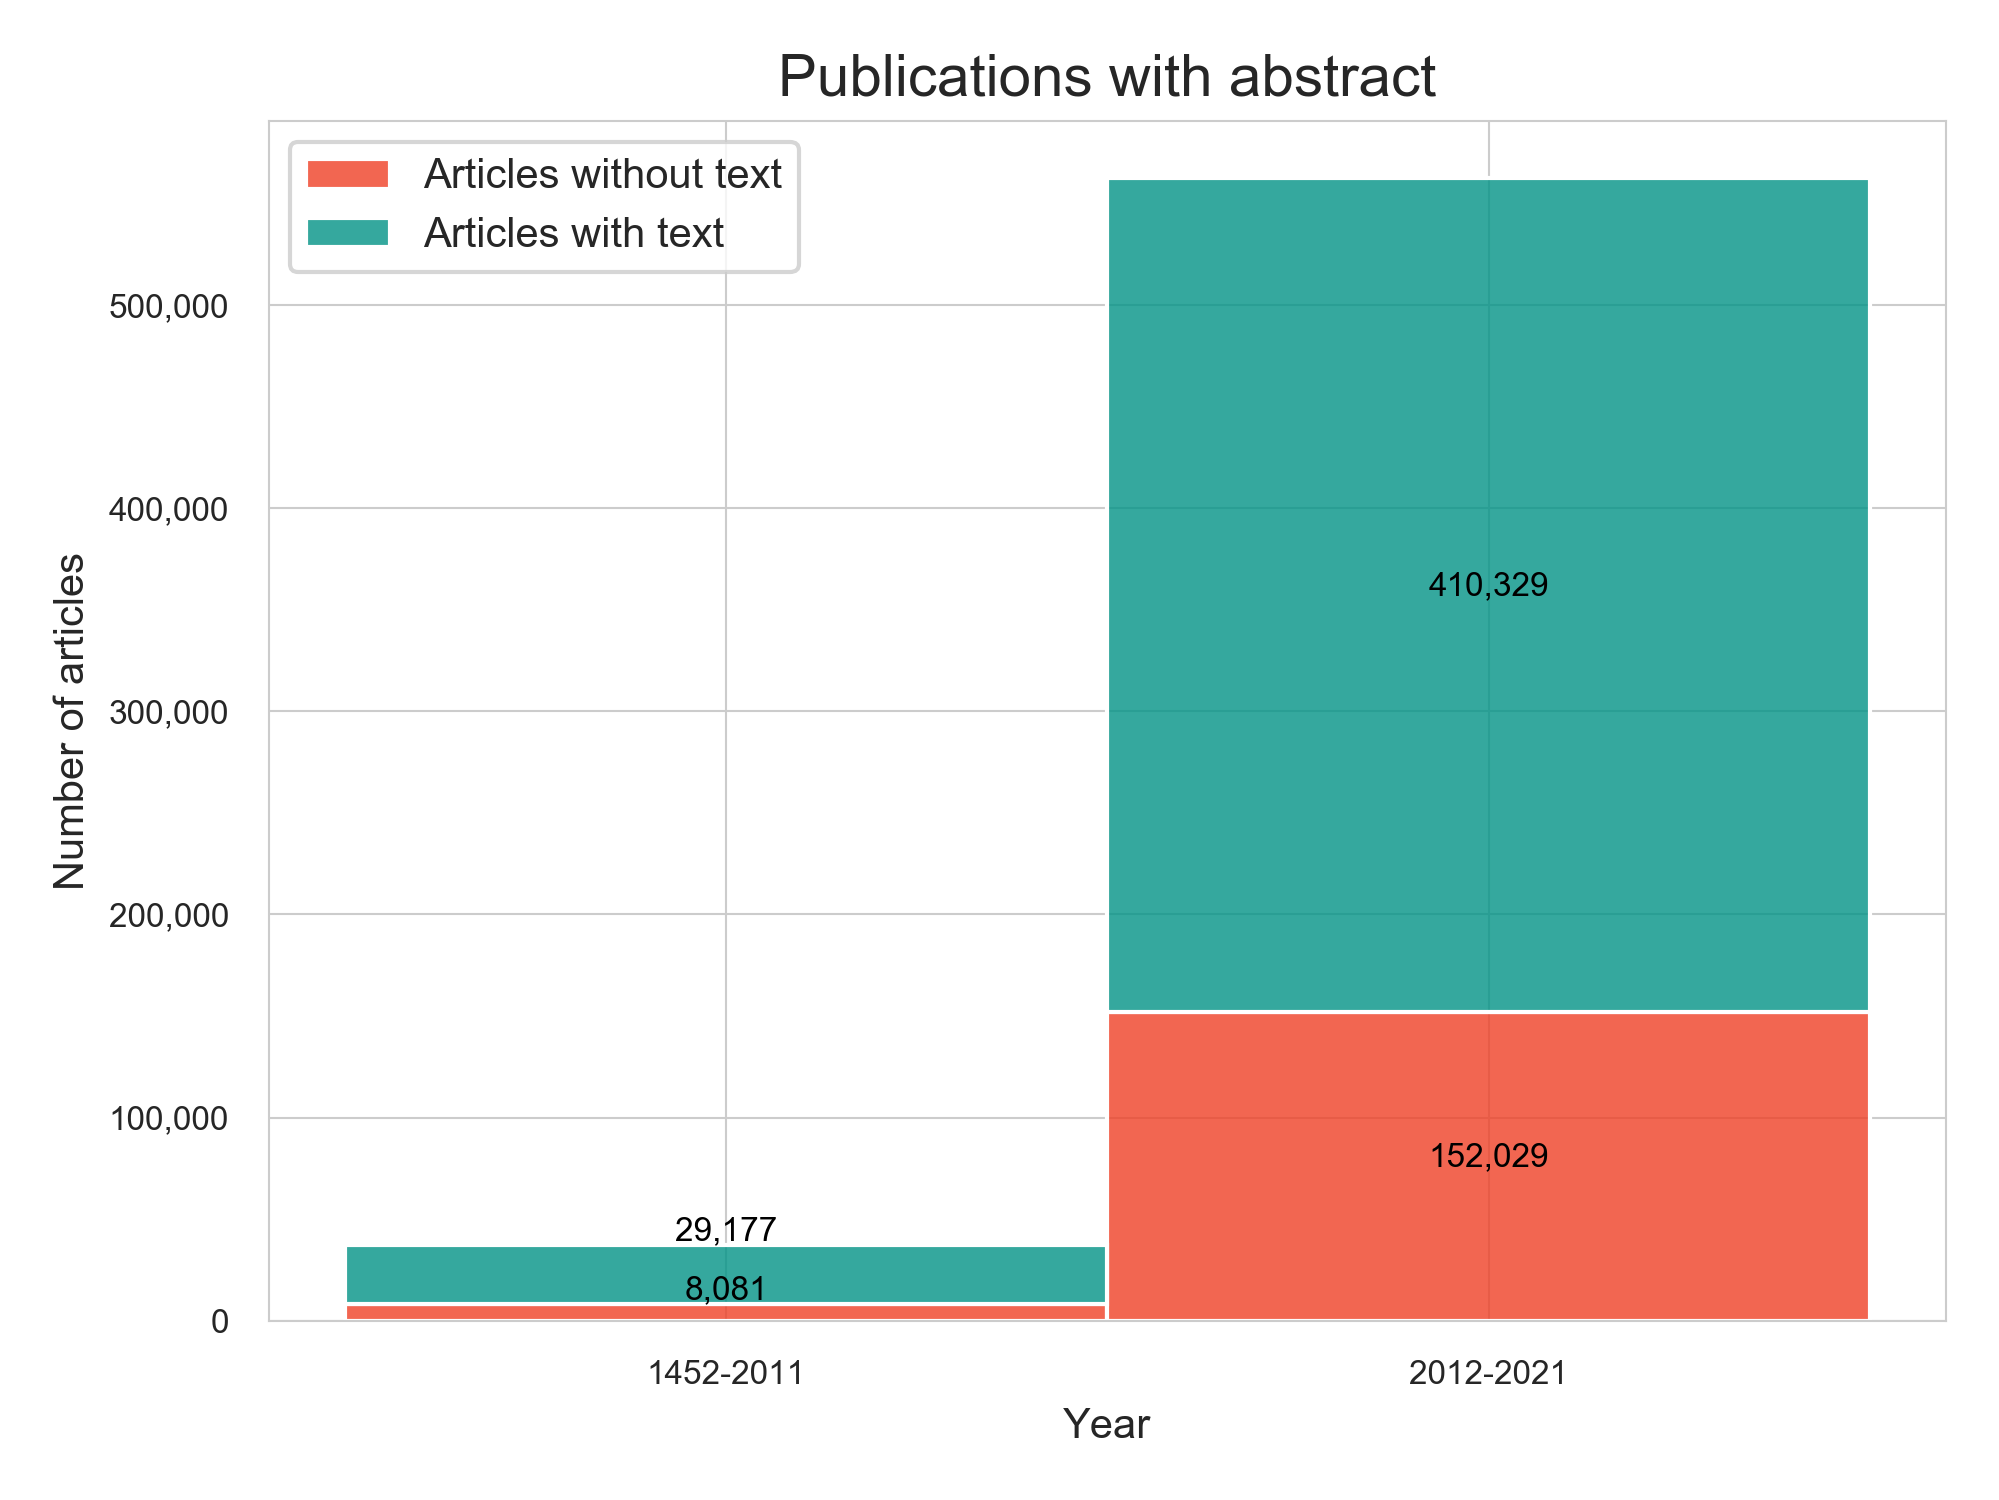

In [46]:
%%python

abstractDF_Py = spark.sql("select has_abstract, group_year from abstractDF_Py").toPandas()

plot_figure(abstractDF_Py,
            'group_year',
            'has_abstract',
            'Publications with abstract',
            'Year',
            'Number of articles',
            'Availability_of_the_text_in_abstract', 
            ['steck'], 
            0.8, 0.7, 0)

with tempfile.NamedTemporaryFile(suffix=".png") as tempImage:
        plt.savefig(tempImage.name)
        retval = Image(filename=tempImage.name)

In [47]:
%%time
var wordsMetadataDF = metadataDF.withColumn("words_in_abstract", size(split(col("abstract")," ")).cast("Integer"))
                       .withColumn("unique_words_in_abstract", size(array_distinct(split(col("abstract")," "))).cast("Integer"))
                       .withColumn("group_word", when(col("words_in_abstract") <= 0,"Empty")
                                                .when(col("words_in_abstract") >0 && col("words_in_abstract") <=50,"1-50")
                                                .when(col("words_in_abstract") >50 && col("words_in_abstract") <=100,"51-100")
                                                .when(col("words_in_abstract") >100 && col("words_in_abstract") <=200,"101-200")
                                                .when(col("words_in_abstract") >200 && col("words_in_abstract") <=300,"201-300")
                                                .when(col("words_in_abstract") >300 && col("words_in_abstract") <=400,"301-400")
                                                .otherwise(">400"))
                      .withColumn("group_unique_word", when(col("unique_words_in_abstract") <= 0,"Empty")
                                                .when(col("unique_words_in_abstract") >0 && col("unique_words_in_abstract") <=50,"1-50")
                                                .when(col("unique_words_in_abstract") >50 && col("unique_words_in_abstract") <=100,"51-100")
                                                .when(col("unique_words_in_abstract") >100 && col("unique_words_in_abstract") <=200,"101-200")
                                                .when(col("unique_words_in_abstract") >200 && col("unique_words_in_abstract") <=300,"201-300")
                                                .when(col("unique_words_in_abstract") >300 && col("unique_words_in_abstract") <=400,"301-400")
                                                .otherwise(">400"))

var wordsDF = wordsMetadataDF.groupBy($"group_word")
                    .count
                    .withColumn("group", lit("Words in article"))

var uniqueWordsDF = wordsMetadataDF.groupBy($"group_unique_word")
                              .count
                              .withColumn("group", lit("Unique words in article"))

val wordsUnion = wordsDF.union(uniqueWordsDF)

Time: 0.24545621871948242 seconds.



wordsMetadataDF: org.apache.spark.sql.DataFrame = [cord_uid: string, title: string ... 10 more fields]
wordsDF: org.apache.spark.sql.DataFrame = [group_word: string, count: bigint ... 1 more field]
uniqueWordsDF: org.apache.spark.sql.DataFrame = [group_unique_word: string, count: bigint ... 1 more field]
wordsUnion: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [group_word: string, count: bigint ... 1 more field]


In [48]:
// Using Python and Pandas Library for better visibility of tables and for plotting 
wordsUnion.toDF.createOrReplaceTempView("wordsDF_Py")

Saving figure Words_in_Article_(1452-2022)
Time: 52.629724740982056 seconds.



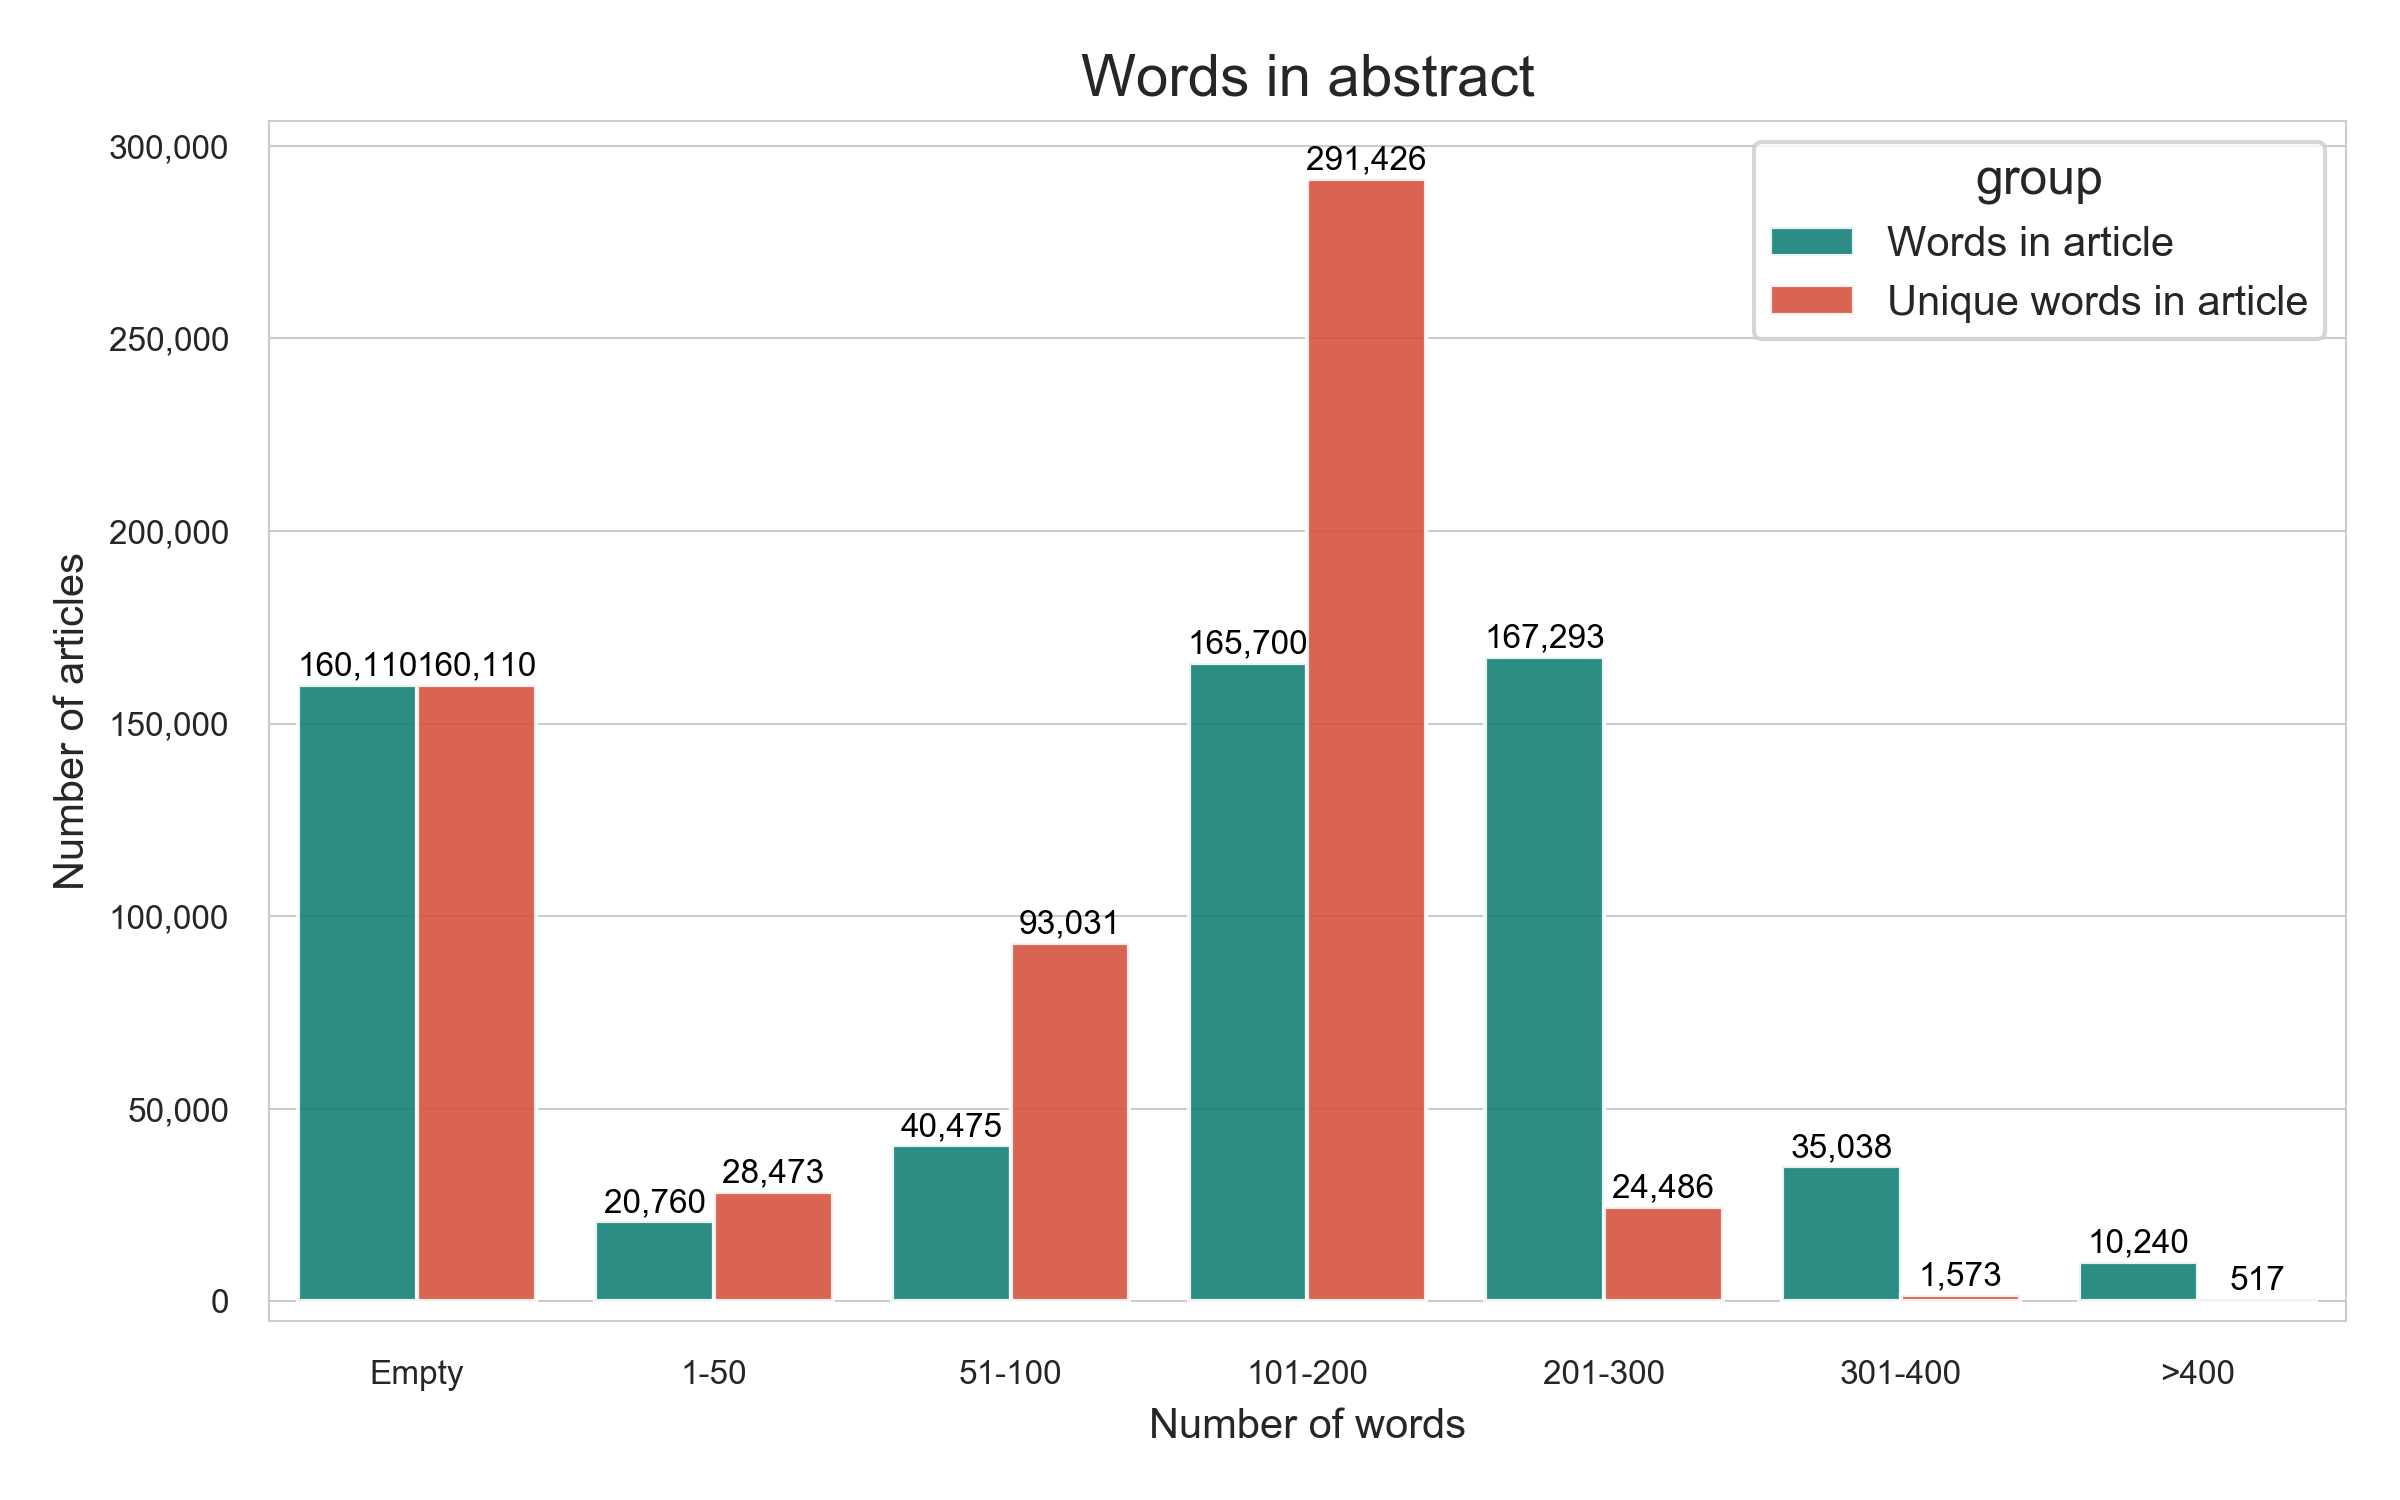

In [49]:
%%time
%%python

wordsDF_Py = spark.sql("select * from wordsDF_Py").toPandas().reindex([5,4,6,2,1,0,3,7,8,9,10,11,12,13])

plot_figure(wordsDF_Py, 
            'group_word', 
            'count',
            'Words in abstract', 
            'Number of words',
            'Number of articles',
            'Words_in_Article_(1452-2022)',
            ['catplot_group'], 
            0.9, 0.5, 0)

with tempfile.NamedTemporaryFile(suffix=".png") as tempImage:
        plt.savefig(tempImage.name)
        retval = Image(filename=tempImage.name)

## <span style='color:Blue' id='3.6'> 3.6. Language analysis

In [50]:
%%time
import com.github.pemistahl.lingua.api._
import com.github.pemistahl.lingua.api.Language._
import spark.implicits._


metadataDF = metadataDF
                        .select("cord_uid", "title", "abstract", "publish_time", "pdf_json_files")
                        .as[(String, String, String, Int, String)]
                        .map { case (id, title, abstr, year, pdf_path) => {
                                 val detector: LanguageDetector = LanguageDetectorBuilder.fromLanguages(ENGLISH, FRENCH, GERMAN, SPANISH).build()
                                 var language = ""
                                 try { language = detector.detectLanguageOf(abstr).name } 
                                catch{ case _: Throwable => language = "EMPTY" }
                                (id, title, abstr, language, year, pdf_path) 
                                 }
                              }.toDF("id", "title", "abstract", "language", "year", "pdf_path")
                        

metadataDF.show()

+--------+--------------------+--------------------+--------+----+--------------------+
|      id|               title|            abstract|language|year|            pdf_path|
+--------+--------------------+--------------------+--------+----+--------------------+
|ug7v899j|Clinical features...|OBJECTIVE: This r...| ENGLISH|2001|document_parses/p...|
|02tnwd4m|Nitric oxide: a p...|Inflammatory dise...| ENGLISH|2000|document_parses/p...|
|ejv2xln0|Surfactant protei...|Surfactant protei...| ENGLISH|2000|document_parses/p...|
|2b73a28n|Role of endotheli...|Endothelin-1 (ET-...| ENGLISH|2001|document_parses/p...|
|9785vg6d|Gene expression i...|Respiratory syncy...| ENGLISH|2001|document_parses/p...|
|zjufx4fo|Sequence requirem...|Nidovirus subgeno...| ENGLISH|2001|document_parses/p...|
|5yhe786e|Debate: Transfusi...|Recent evidence s...| ENGLISH|2001|document_parses/p...|
|8zchiykl|The 21st Internat...|The 21st Internat...| ENGLISH|2001|document_parses/p...|
|8qnrcgnk|Heme oxygenase-1 ...|H

import com.github.pemistahl.lingua.api._
import com.github.pemistahl.lingua.api.Language._
import spark.implicits._
metadataDF: org.apache.spark.sql.DataFrame = [id: string, title: string ... 4 more fields]


In [51]:
val statisticLngDF = metadataDF.groupBy("language").count()

statisticLngDF: org.apache.spark.sql.DataFrame = [language: string, count: bigint]


In [52]:
// Using Python and Pandas Library for better visibility of tables and for plotting 
statisticLngDF.toDF.createOrReplaceTempView("statisticLng_Py")

Saving figure Text_Language_without_empty
Time: 175.16652703285217 seconds.



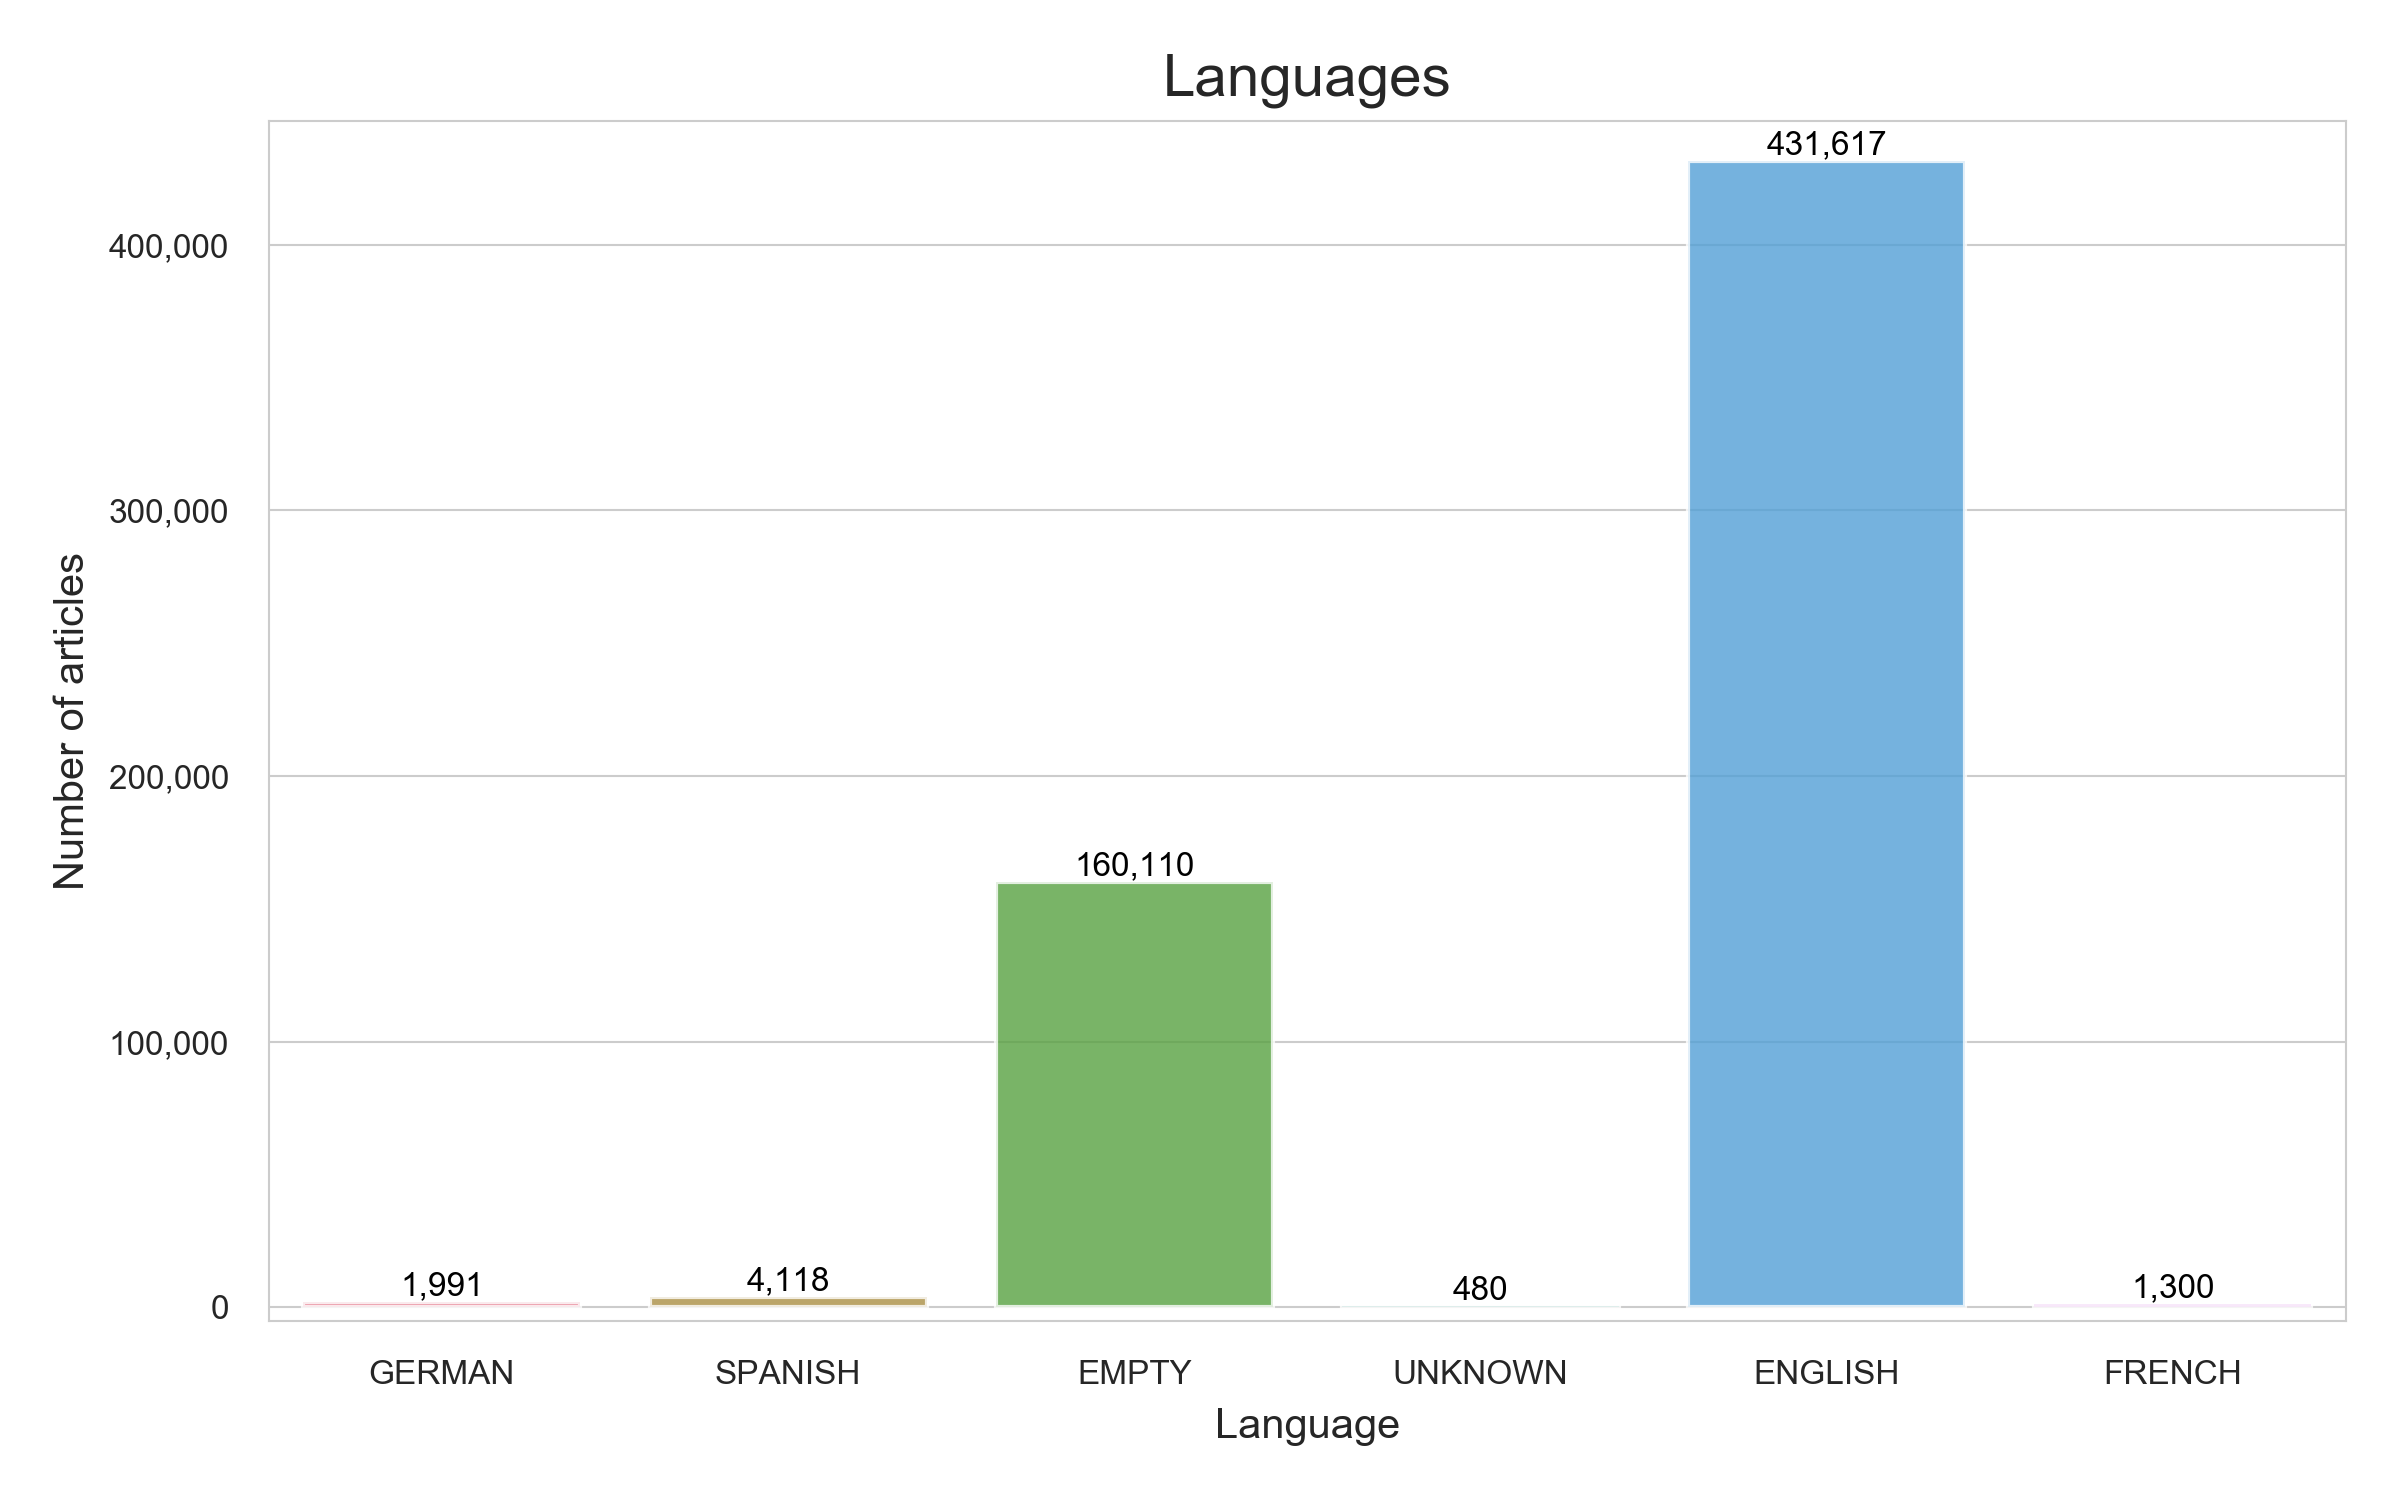

In [53]:
%%time
%%python

statisticLng_Py = spark.sql("select * from statisticLng_Py").toPandas()

plot_figure(statisticLng_Py,
            'language',
            'count',
            'Languages',
            'Language',
            'Number of articles',
            'Text_Language_without_empty', 
            ['catplot'], 
            0.8, 0.0, 0)

with tempfile.NamedTemporaryFile(suffix=".png") as tempImage:
        plt.savefig(tempImage.name)
        retval = Image(filename=tempImage.name)

# <span style='color:Blue' id='4'> 4. Data Reductiction and Fetch Body Text

In [54]:
metadataDF.show(5)

+--------+--------------------+--------------------+--------+----+--------------------+
|      id|               title|            abstract|language|year|            pdf_path|
+--------+--------------------+--------------------+--------+----+--------------------+
|ug7v899j|Clinical features...|OBJECTIVE: This r...| ENGLISH|2001|document_parses/p...|
|02tnwd4m|Nitric oxide: a p...|Inflammatory dise...| ENGLISH|2000|document_parses/p...|
|ejv2xln0|Surfactant protei...|Surfactant protei...| ENGLISH|2000|document_parses/p...|
|2b73a28n|Role of endotheli...|Endothelin-1 (ET-...| ENGLISH|2001|document_parses/p...|
|9785vg6d|Gene expression i...|Respiratory syncy...| ENGLISH|2001|document_parses/p...|
+--------+--------------------+--------------------+--------+----+--------------------+
only showing top 5 rows



## <span style='color:Blue' id='4.1'> 4.1. Body Text Fetching with Scala

In [55]:
%%time

//function to fetch body text from pdf_json

def fetchText2021Scala(df: DataFrame): DataFrame = {
    
    //filter out all publiatins published not in 2021
    val df2021 = df.filter(col("publish_time")===2021)

    val paths =  df.select("cord_uid", "title","pdf_path")
                         .map(r => (r(0).asInstanceOf[String], r(1).asInstanceOf[String], r(2).asInstanceOf[String]))
                         .collect.toSeq.toList.take(30000)
    
    var resultDF = paths.map(x => {
        var body_text = ""
        try {
            var json = spark.read.json(spark.sparkContext.wholeTextFiles(x._3).values)
            body_text = json.toDF.select("body_text.text").as[Array[String]].collectAsList.asScala.flatten.mkString(" ")
            } catch { case _: Throwable => { body_text = ""} }
        (x._1, x._2, body_text)
    }).toDF("id", "title", "text")
   
    resultDF
  }


//Attantion!!! It takes 2,43 hours for 30.000 publications! We dont't use this method!
//var text2021Df = fetchText2021Scala(metadataDF)

Time: 0.3904850482940674 seconds.



fetchText2021Scala: (df: org.apache.spark.sql.DataFrame)org.apache.spark.sql.DataFrame


<span style='color:Red'> Attantion!!! It takes 2,43 hours for 30.000 publications! 

<img src="help_images/textFetchScala.png">

## <span style='color:Blue' id='4.2'> 4.2. Fetch Body Text with Python

In [29]:
%%python
import glob #Unix style pathname pattern expansion
import json
import tarfile
import urllib.request
import time
import csv
from collections import defaultdict
import pandas as pd

# fetch all body text from pdf for publications in 2021 and export new metadata with text to path_metadata_expor
# idea from https://github.com/allenai/cord19

def fetchText2021 (path_metadata_import, path_metadata_export):
    cord_uid_list = defaultdict(list)
    reader_size = 0
    not_matched = 0
    
    with open(path_metadata_import) as file_in:
        start_time = time.time()
        reader = csv.DictReader(file_in)
        
        for row in reader:
            #analyse only articles for 2021
            if row['publish_time'].startswith('2021'): 
                # access some metadata
                cord_uid = row['cord_uid']
                title = row['title']
                abstract = row['abstract']
                publish_time = row['publish_time']
                
                #access the full text (if available)
                body_text=""
                if row['pdf_json_files']:
                    for json_path in row['pdf_json_files'].split('; '):
                        with open(os.path.join('datasets/2021-05-31',json_path)) as file_json:
                            full_text_dict = json.load(file_json)
                            
                            for paragraph_dict in full_text_dict['body_text']:
                                paragraph_text = paragraph_dict['text']
                                body_text += paragraph_text
                                
                #save full article for later
                cord_uid_list[cord_uid].append({
                    'title': title,
                    'publish_time': publish_time,
                    'abstract': abstract,
                    'body_text': body_text,})
                
                reader_size += 1
                
    end_time = time.time()                        
    print("Matched ", reader_size, " articles from methadata")
    print(" Time: {:.2f} minutes!".format((end_time - start_time)/60))
    print("Not matched:", not_matched)
    
    #export metadata as csv File
    result = pd.DataFrame([(k, v[0]['title'], v[0]['publish_time'], v[0]['abstract'],v[0]['body_text']) for k, v in cord_uid_list.items()], 
                   columns=['cord_uid', 'title', 'publish_time', 'abstract', 'body_text']) 
    result.to_csv(os.path.join(path_metadata_export,'metadata_2021_text.csv'), encoding='utf-8', index=False)
                
        

## <span style='color:Red'> To fetch all body texts for 2021, uncomment line 4 bellow (fetchText2021 (METADATA_PATH_IMPORT, METADATA_PATH_EXPORT)). It takes 2.13 minutes and need 1,59 Gb free space.


## <span style='color:Blue' id='4.3'> 4.3. Data Reductiction

**Original metadata** <br>
599.616 articels <br>
 <br>
**FILTER OUT:**
    1. Artikels published not in 2021
    2. Artikels with one or less words in body text
    2. not english Artikels
    
**Result**: 54.166<br>
       



Use data, obtained in chapter 4.2 Python.

In [58]:
%%time

//load metadata, that was received with Pyton in chapter 4.2 
val METADATA_TEXT_PATH = "datasets_text/metadata_2021_text.csv"

val schemaText = new StructType()
        .add("cord_uid",StringType,true)
        .add("title",StringType,true)
        .add("publish_time",DataTypes.DateType,true)
        .add("abstract",StringType,true)   
        .add("body_text",StringType,true)

var textDF = spark.read.format("csv")
                        .option("sep", ",")
                        .option("header", "true")
                        .option("dateFormat", "yyyy-MM-dd")
                        .schema(schemaText)
                        .load(METADATA_TEXT_PATH)
                        .toDF


Time: 0.18430399894714355 seconds.



METADATA_TEXT_PATH: String = datasets_text/metadata_2021_text.csv
schemaText: org.apache.spark.sql.types.StructType = StructType(StructField(cord_uid,StringType,true), StructField(title,StringType,true), StructField(publish_time,DateType,true), StructField(abstract,StringType,true), StructField(body_text,StringType,true))
textDF: org.apache.spark.sql.DataFrame = [cord_uid: string, title: string ... 3 more fields]


In [59]:
textDF.show(5)

+--------+--------------------+------------+--------------------+--------------------+
|cord_uid|               title|publish_time|            abstract|           body_text|
+--------+--------------------+------------+--------------------+--------------------+
|aoiambb8|Etiology of Sever...|  2021-01-31|In April 2017, su...|I n April 2017, t...|
|embv1el9|Accuracy of a bat...|  2021-01-01|Carbon dioxide me...|Measurement of ca...|
|8dcgzyst|The influence of ...|  2021-01-01|BACKGROUND: Diabe...|"Twenty percent o...|
|sgtvecj8|In vivo delivery ...|  2021-01-01|OBJECTIVES: A pot...|Since the onset o...|
|3vtq6d8f|Relationship Betw...|  2021-01-02|This research was...|"Nurses are the l...|
+--------+--------------------+------------+--------------------+--------------------+
only showing top 5 rows



In [60]:
%%time
textDF = textDF.withColumn("words_in_body", size(split(col("body_text")," ")).cast("Integer"))
                .filter($"words_in_body" > 1)

print("Articles in 2021 with more then 1 word in body text: ")
println(textDF.count)
textDF.orderBy(desc("words_in_body")).show(5)
textDF.describe("words_in_body").show()

Articles in 2021 with more then 1 word in body text: 55705
+--------+--------------------+------------+--------------------+--------------------+-------------+
|cord_uid|               title|publish_time|            abstract|           body_text|words_in_body|
+--------+--------------------+------------+--------------------+--------------------+-------------+
|ep12ix8n|Group testing as ...|  2021-03-04|We propose an ana...|Testing aims at r...|        67162|
|3m41r5ou|The European Unio...|  2021-02-27|This report of th...|List of Tables   ...|        65843|
|b15a5gza|Technical assista...|  2021-04-29|This report asses...|Article 1 point 2...|        49567|
|zdwfe61u|United States of ...|  2021-01-01|It is believed th...|"It is believed t...|        41694|
|9m8xsggr|Abstracts present...|  2021-02-22|                null|Craigavon Area Ho...|        40126|
+--------+--------------------+------------+--------------------+--------------------+-------------+
only showing top 5 rows

+------

textDF: org.apache.spark.sql.DataFrame = [cord_uid: string, title: string ... 4 more fields]


In [61]:
// Using Python and Pandas Library for better visibility of tables and for plotting 
textDF.toDF.createOrReplaceTempView("textDF_Py")

Saving figure Words_body_text_2021


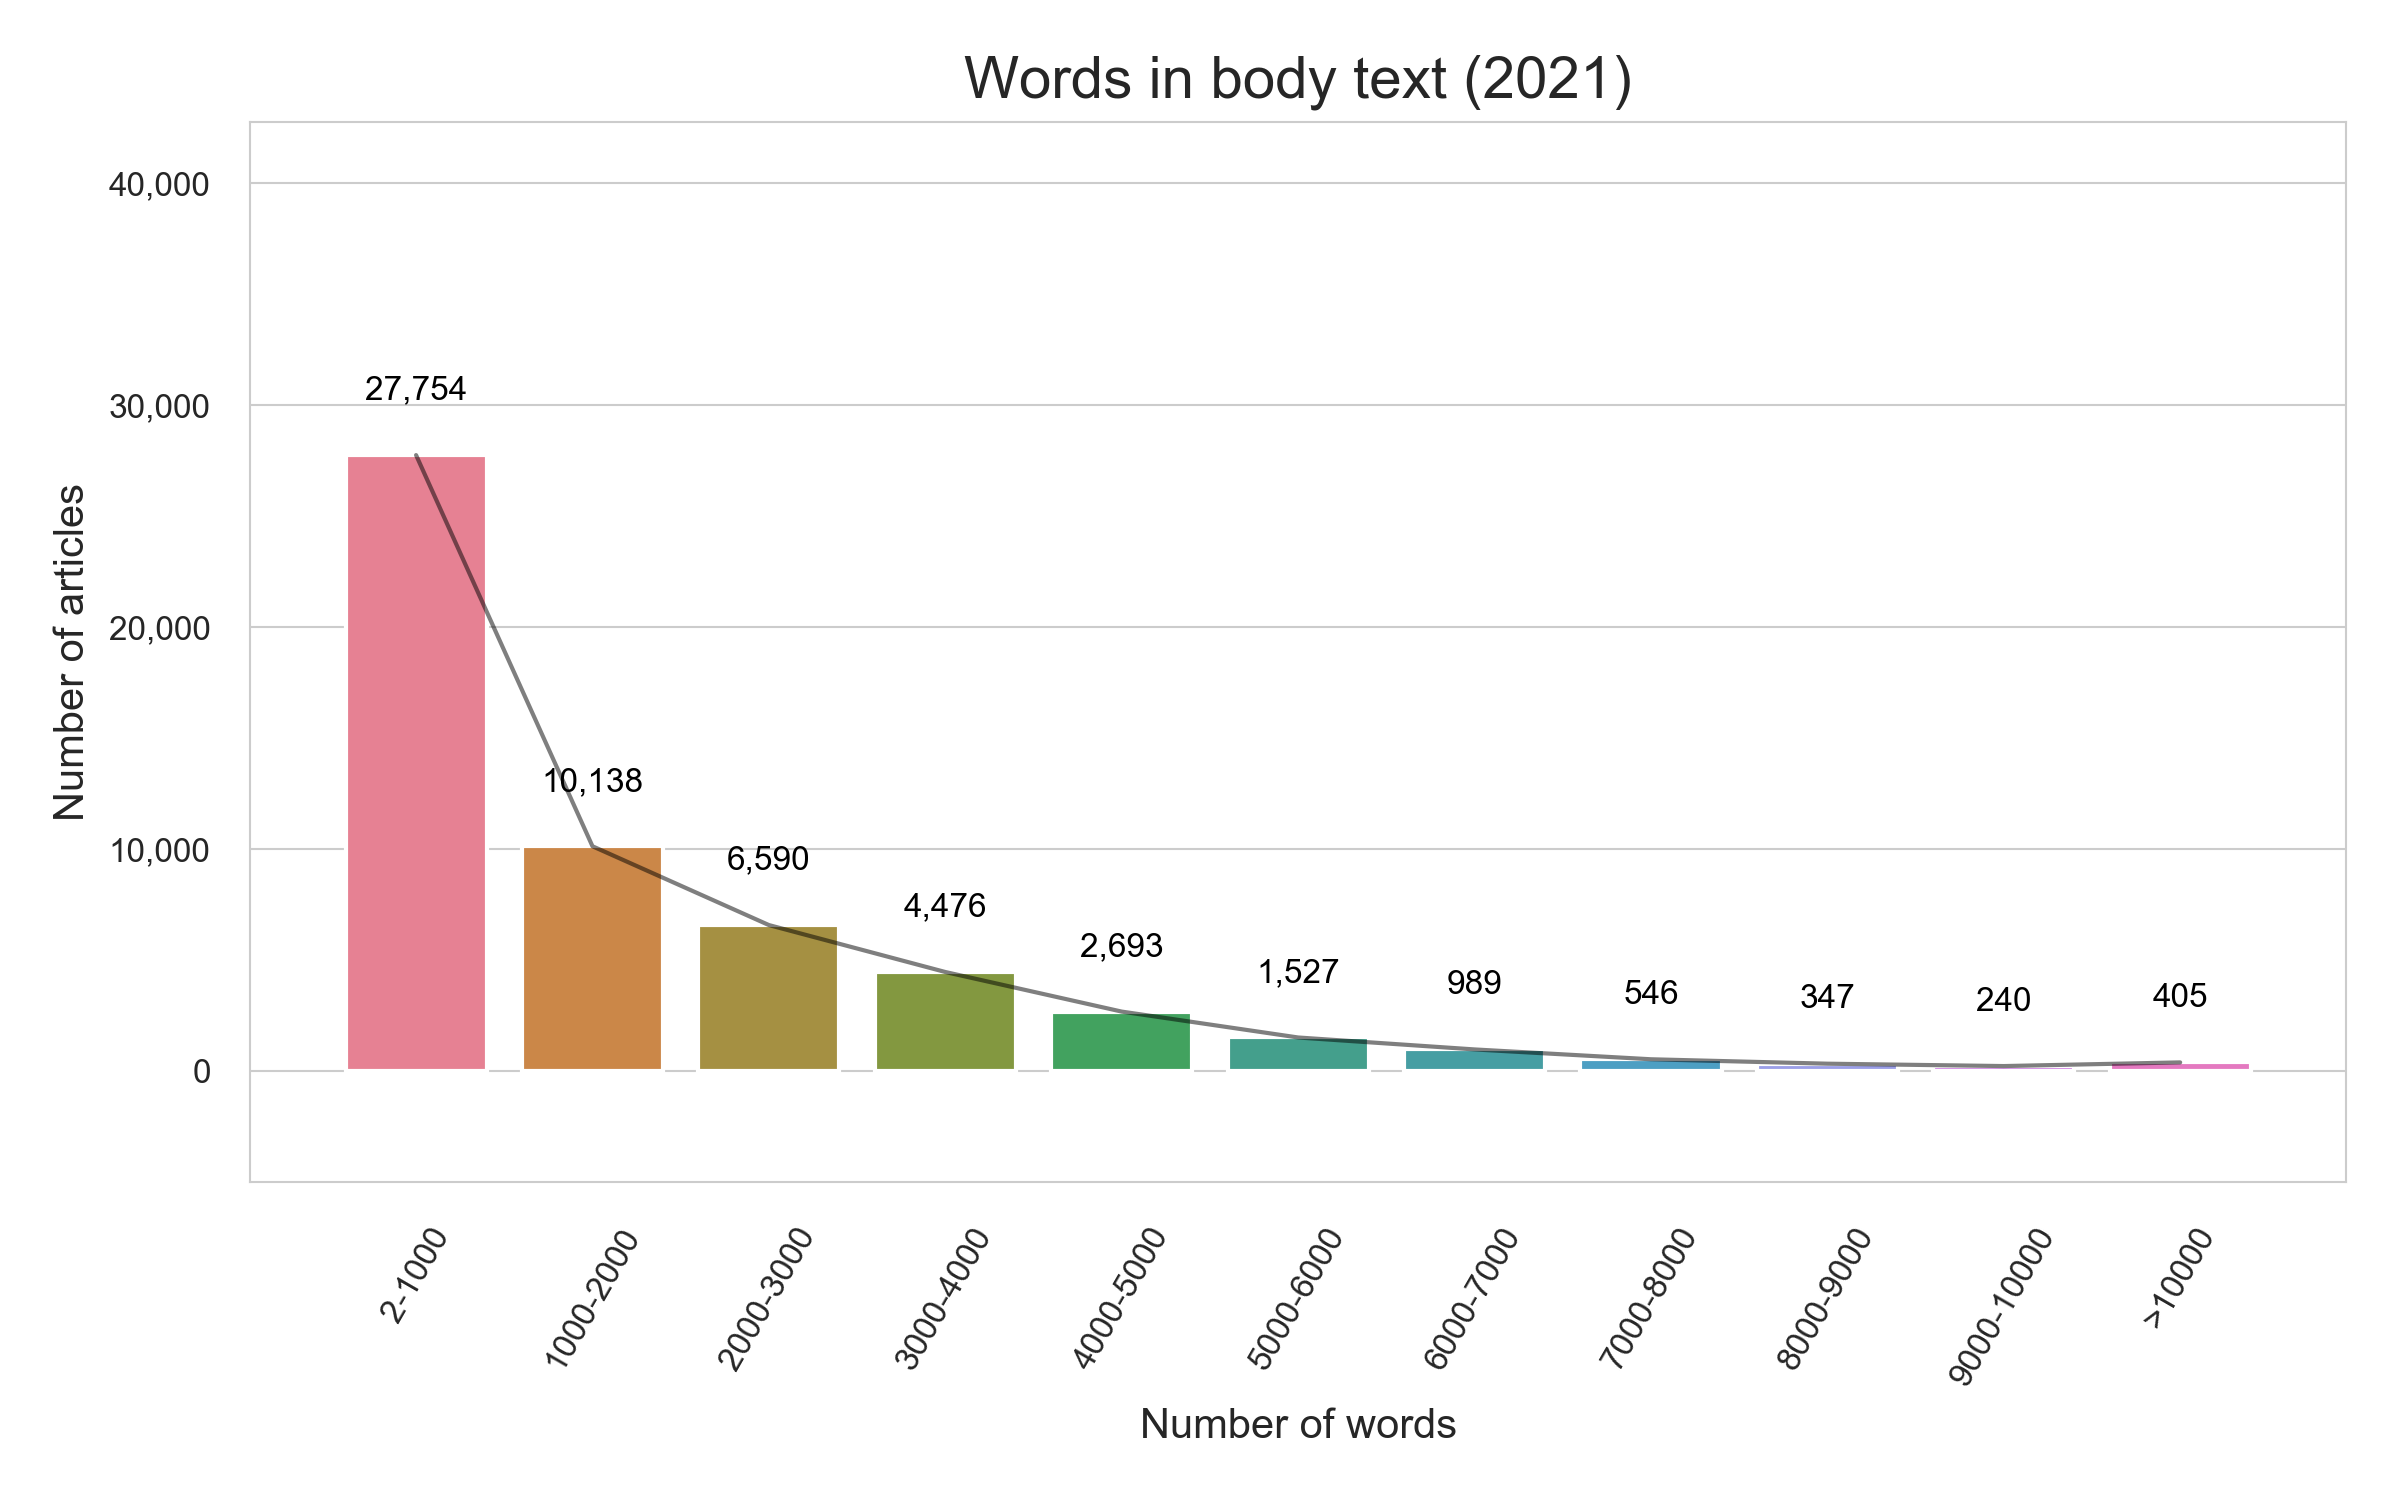

In [62]:
%%python

textDF_Py = spark.sql("select cord_uid, words_in_body from textDF_Py").toPandas()
count_labels = ['2-1000','1000-2000', '2000-3000', '3000-4000', '4000-5000','5000-6000', '6000-7000', '7000-8000', '8000-9000','9000-10000', '>10000']
textDF_Py = textDF_Py['words_in_body'].value_counts(bins = [0,1000, 2000, 3000,4000,5000,6000,7000,8000,9000,10000,67162]).sort_index().reset_index(name='count').drop(columns=['index'])
textDF_Py['count_words']=count_labels

plot_figure(textDF_Py,
            'count_words',
            'count',      
            'Words in body text (2021)',
            'Number of words',
            'Number of articles',
            'Words_body_text_2021', 
            ['catplot', 'lineplot'], 
            1., 0.5, 60)

with tempfile.NamedTemporaryFile(suffix=".png") as tempImage:
        plt.savefig(tempImage.name)
        retval = Image(filename=tempImage.name)

In [63]:
%%time
import com.github.pemistahl.lingua.api._
import com.github.pemistahl.lingua.api.Language._
import spark.implicits._

// Filter out all articles with not English body text

textDF = textDF.select("cord_uid","title","body_text","words_in_body").as[(String, String, String, Int)]
               .map { case (id, title, text, words) => {
                          val detector: LanguageDetector = LanguageDetectorBuilder.fromLanguages(ENGLISH, FRENCH, GERMAN, SPANISH).build()
                          var language = ""
                          try { language = detector.detectLanguageOf(text).name } 
                          catch{ case _: Throwable => language = "OTHER" }
                          (id, title, text, words, language) 
                       }
                    }.toDF("id", "title", "text", "words_in_body","language")
              .filter(col("language") === "ENGLISH")
              .drop(col("language"))

println("Detaset size: " + textDF.count)



Detaset size: 54167
Time: 170.50321102142334 seconds.



import com.github.pemistahl.lingua.api._
import com.github.pemistahl.lingua.api.Language._
import spark.implicits._
textDF: org.apache.spark.sql.DataFrame = [id: string, title: string ... 2 more fields]


# <span style='color:Blue' id='5'> 5. Pre-Processing

In [64]:
textDF.show(5)

+--------+--------------------+--------------------+-------------+
|      id|               title|                text|words_in_body|
+--------+--------------------+--------------------+-------------+
|aoiambb8|Etiology of Sever...|I n April 2017, t...|          867|
|embv1el9|Accuracy of a bat...|Measurement of ca...|         1641|
|8dcgzyst|The influence of ...|"Twenty percent o...|          352|
|sgtvecj8|In vivo delivery ...|Since the onset o...|         4054|
|3vtq6d8f|Relationship Betw...|"Nurses are the l...|          715|
+--------+--------------------+--------------------+-------------+
only showing top 5 rows



## <span style='color:Blue' id='5.1'> 5.1. Tokenization with Apache Spark MLlib

MLib is Spark’s machine learning (ML) library. For tokenization were used **Transformers** RegexTokenizer() and StopWordsRemover()

In [65]:
%%time
import org.apache.spark.ml.feature.{RegexTokenizer, Tokenizer}
import org.apache.spark.ml.feature.StopWordsRemover
import org.apache.hadoop.io._

var termDF = textDF.toDF()

//Size of articles to analyse:  54.166(ENGLISH PDFs in 2021)
println("Size of articles to analyse: " + termDF.count())

// Stopwords list  (https://github.com/igorbrigadir/stopwords)
val ATIRE_NCBI_Medline = scala.io.Source.fromFile(MED_STOP_WORDS_PATH).getLines
val stopWordsList: Array[String] = StopWordsRemover.loadDefaultStopWords("english") ++ ATIRE_NCBI_Medline
 
// Tokenization Redex (//https://regexr.com/3b0ik)
val textTokenizer = new RegexTokenizer() 
  .setInputCol("text")
  .setOutputCol("term_noisy")
  .setPattern("([\\u0000-\\u0040\\u005B-\\u0060\\u007B-\\u00BF\\u02B0-\\u036F\\u00D7\\u00F7\\u2000-\\u2BFF])+")  

//Stop Words Remover
val remover = new StopWordsRemover()
  .setInputCol("term_noisy")
  .setOutputCol("term")
  .setStopWords(stopWordsList)

//Pipeline
val pipeline = new Pipeline().
    setStages(Array(
        textTokenizer,
        remover
    ))

Size of articles to analyse: 54167
Time: 172.26623630523682 seconds.



import org.apache.spark.ml.feature.{RegexTokenizer, Tokenizer}
import org.apache.spark.ml.feature.StopWordsRemover
import org.apache.hadoop.io._
termDF: org.apache.spark.sql.DataFrame = [id: string, title: string ... 2 more fields]
ATIRE_NCBI_Medline: Iterator[String] = <iterator>
stopWordsList: Array[String] = Array(i, me, my, myself, we, our, ours, ourselves, you, your, yours, yourself, yourselves, he, him, his, himself, she, her, hers, herself, it, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, be...


In [66]:
stopWordsList.length

res30: Int = 494


In [67]:
%%time

termDF = pipeline.fit(termDF)
                 .transform(termDF)
                 .withColumn("term_count", size(col("term")).cast("Integer"))

Time: 0.3039400577545166 seconds.



termDF: org.apache.spark.sql.DataFrame = [id: string, title: string ... 5 more fields]


In [68]:
// Using Python and Pandas Library for better visibility of tables and for plotting 
termDF.limit(5).toDF.createOrReplaceTempView("termsMLib_Py")

In [69]:
%%python
termsMLib_Py = spark.sql("select * from termsMLib_Py")
termsMLib_Py.toPandas().head()

,id,title,text,words_in_body,term_noisy,term,term_count
0,aoiambb8,Etiology of Severe Acute Respiratory Infection...,"I n April 2017, the Institute of Epidemiology ...",867,"[i, n, april, the, institute, of, epidemiology...","[n, april, institute, epidemiology, disease, c...",501
1,embv1el9,Accuracy of a battery-powered portable capnome...,Measurement of carbon dioxide (CO 2 ) using a ...,1641,"[measurement, of, carbon, dioxide, co, using, ...","[measurement, carbon, dioxide, co, co, detecto...",854
2,8dcgzyst,The influence of diabetes on postoperative com...,"""Twenty percent of surgical patients have diab...",352,"[twenty, percent, of, surgical, patients, have...","[twenty, percent, surgical, patients, diabetes...",208
3,sgtvecj8,In vivo delivery of a multiepitope peptide and...,"Since the onset of the AIDS epidemic, 75 milli...",4054,"[since, the, onset, of, the, aids, epidemic, m...","[onset, aids, epidemic, million, people, infec...",2645
4,3vtq6d8f,Relationship Between Compassion Fatigue in Nur...,"""Nurses are the largest and the most significa...",715,"[nurses, are, the, largest, and, the, most, si...","[nurses, largest, significant, professional, g...",352


In [70]:
%%time
//6 min
var termStatisticMLib = termDF
                            .agg(sum("words_in_body") - sum("term_count") as "stop_words",
                                    sum("term_count") as "not_stop_words")
                            .withColumn("term_type", lit("count"))

termStatisticMLib = transposeDataFrame(termStatisticMLib, Seq("stop_words", "not_stop_words"), "term_type")
                                      .withColumn("count", col("count").cast("Long"))
                                      
termStatisticMLib.show()

+--------------+--------+
|     term_type|   count|
+--------------+--------+
|    stop_words|42246717|
|not_stop_words|54649742|
+--------------+--------+

Time: 387.2931523323059 seconds.



termStatisticMLib: org.apache.spark.sql.DataFrame = [term_type: string, count: bigint]
termStatisticMLib: org.apache.spark.sql.DataFrame = [term_type: string, count: bigint]


In [71]:
// Using Python and Pandas Library for better visibility of tables and for plotting 
termStatisticMLib.toDF.createOrReplaceTempView("termStatistic_Py")

Saving figure Words_VS_Stop_Words_2021_MLib_Spark
Time: 196.08369708061218 seconds.



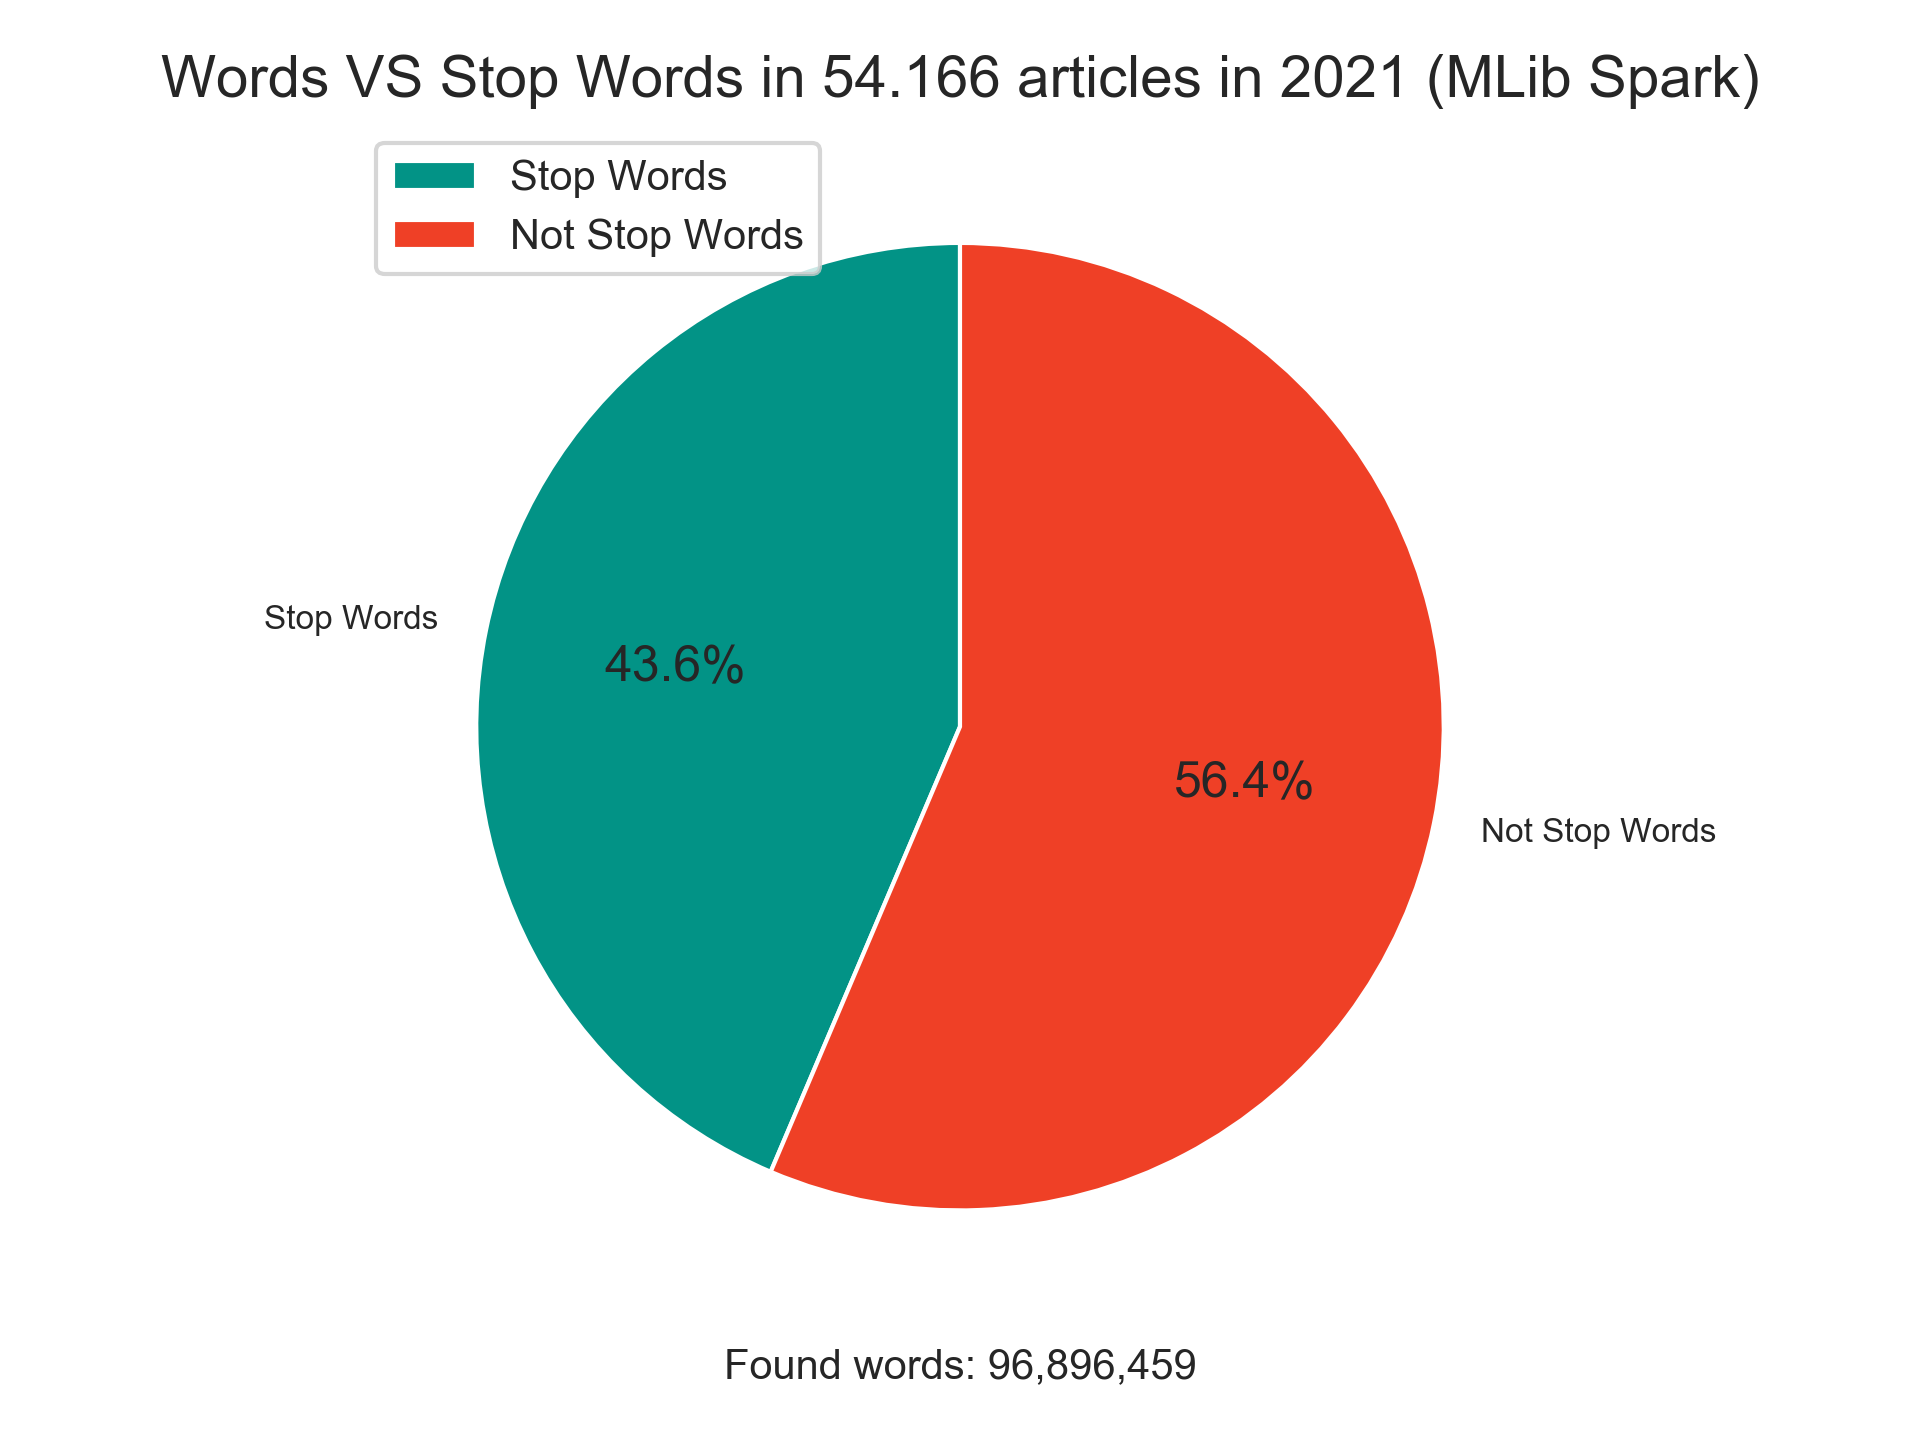

In [72]:
%%time
%%python   

termStatistic_Py = spark.sql("select * from termStatistic_Py").toPandas()

text = "Found words: {:,}".format(termStatistic_Py['count'].sum())

plot_figure(termStatistic_Py, 
            '', 
            'count',
            'Words VS Stop Words in 54.166 articles in 2021 (MLib Spark)',
             text,
            '',
            'Words_VS_Stop_Words_2021_MLib_Spark',
            ['pie'], 
            0.9, 0.5, 0)

with tempfile.NamedTemporaryFile(suffix=".png") as tempImage:
        plt.savefig(tempImage.name)
        retval = Image(filename=tempImage.name)

## <span style='color:Blue' id='5.2'> 5.2. Tokenization and Lemmatization with Stanford CoreNLP

In [73]:
var lemmaDF = textDF

lemmaDF: org.apache.spark.sql.DataFrame = [id: string, title: string ... 2 more fields]


In [74]:
%%time

import edu.stanford.nlp.pipeline._
import edu.stanford.nlp.ling.CoreAnnotations._
import scala.collection.JavaConversions._
import java.util.Properties
import scala.collection.mutable.ArrayBuffer

def plainTextToLemmas(text: String, stopWords: Set[String]): Seq[String] = {
    val properties = new Properties()
    properties.put("annotators", "tokenize, ssplit, pos, lemma")
    val pipeline = new StanfordCoreNLP(properties)
    val doc = new Annotation(text)
    pipeline.annotate(doc)
    val lemmas = new ArrayBuffer[String]()
    val sentences = doc.get(classOf[SentencesAnnotation])
    for (sentence <- sentences; token <- sentence.get(classOf[TokensAnnotation])) {
        
      val lemma = token.get(classOf[LemmaAnnotation])
        
      val DigitPattern = """.*\d.*""".r  
      val isDigit = lemma match { case DigitPattern() => true case _ => false }
        
      if (lemma.length > 2 && !stopWords.contains(lemma) && !isDigit) {
        lemmas += lemma.toLowerCase
      }
        
    }
    lemmas
}


val parentheses = Array("-lrb-","-rrb-","-lsb-","-rsb-") // Symbols for '(', ')', '[', ']'
val stopWordsSet: Set[String] = (StopWordsRemover.loadDefaultStopWords("english") ++ ATIRE_NCBI_Medline ++ parentheses).toSet





// lemma for body text
val lemmaRDD = lemmaDF.rdd.mapPartitions{
   iter => iter.map(
       row => (row.getString(0), 
               row.getString(1),
               plainTextToLemmas(row.getString(2), stopWordsSet), 
               row.getInt(3))
   )
}

lemmaDF = spark.createDataFrame(lemmaRDD).toDF("id", "title", "lemma", "words_in_body")
lemmaDF.cache()
lemmaDF.show(5)

+--------+--------------------+--------------------+-------------+
|      id|               title|               lemma|words_in_body|
+--------+--------------------+--------------------+-------------+
|aoiambb8|Etiology of Sever...|[april, institute...|          867|
|embv1el9|Accuracy of a bat...|[measurement, car...|         1641|
|8dcgzyst|The influence of ...|[twenty, percent,...|          352|
|sgtvecj8|In vivo delivery ...|[since, onset, ai...|         4054|
|3vtq6d8f|Relationship Betw...|[nurse, largest, ...|          715|
+--------+--------------------+--------------------+-------------+
only showing top 5 rows

Time: 306.92932891845703 seconds.



import edu.stanford.nlp.pipeline._
import edu.stanford.nlp.ling.CoreAnnotations._
import scala.collection.JavaConversions._
import java.util.Properties
import scala.collection.mutable.ArrayBuffer
plainTextToLemmas: (text: String, stopWords: Set[String])Seq[String]
parentheses: Array[String] = Array(-lrb-, -rrb-, -lsb-, -rsb-)
stopWordsSet: Set[String] = Set(down, it's, ourselves, that's, for, s, further, she'll, any, there's, this, haven't, in, ought, myself, have, your, off, once, i'll, are, is, his, why, too, why's, am, than, isn't, didn't, himself, but, you're, below, what, would, i'd, if, you'll, own, they'll, up, we're, they'd, so, our, t, do, all, him, had, -lrb-, -rsb-, nor, before, just, it, a, she's, as, hadn't, because, has, she, yours, or, above, yourself, herself, she'd, suc...


In [75]:
lemmaDF = lemmaDF.withColumn("lemma_count", size(col("lemma")).cast("Integer"))
lemmaDF.show(5)

+--------+--------------------+--------------------+-------------+-----------+
|      id|               title|               lemma|words_in_body|lemma_count|
+--------+--------------------+--------------------+-------------+-----------+
|aoiambb8|Etiology of Sever...|[april, institute...|          867|        467|
|embv1el9|Accuracy of a bat...|[measurement, car...|         1641|        883|
|8dcgzyst|The influence of ...|[twenty, percent,...|          352|        205|
|sgtvecj8|In vivo delivery ...|[since, onset, ai...|         4054|       2160|
|3vtq6d8f|Relationship Betw...|[nurse, largest, ...|          715|        369|
+--------+--------------------+--------------------+-------------+-----------+
only showing top 5 rows



lemmaDF: org.apache.spark.sql.DataFrame = [id: string, title: string ... 3 more fields]


In [76]:
lemmaDF = lemmaDF.withColumn("stop_words",(col("words_in_body") - col("lemma_count")).cast("Integer"))
lemmaDF.show(3)

+--------+--------------------+--------------------+-------------+-----------+----------+
|      id|               title|               lemma|words_in_body|lemma_count|stop_words|
+--------+--------------------+--------------------+-------------+-----------+----------+
|aoiambb8|Etiology of Sever...|[april, institute...|          867|        467|       400|
|embv1el9|Accuracy of a bat...|[measurement, car...|         1641|        883|       758|
|8dcgzyst|The influence of ...|[twenty, percent,...|          352|        205|       147|
+--------+--------------------+--------------------+-------------+-----------+----------+
only showing top 3 rows



lemmaDF: org.apache.spark.sql.DataFrame = [id: string, title: string ... 4 more fields]


In [77]:
//  It takes 1 hour!!!! Please, don’t uncomment code before chapter 6.TF-IDF
/*
var statisticLemma = lemmaDF.agg(sum("lemma_count") as "not_stop_words",
                                 sum("stop_words") as "stop_words")
statisticLemma.show()
statisticLemma.cache()
*/

+--------------+----------+
|not_stop_words|stop_words|
+--------------+----------+
|      52008679|  44887780|
+--------------+----------+



statisticLemma: org.apache.spark.sql.DataFrame = [not_stop_words: bigint, stop_words: bigint]
res37: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [not_stop_words: bigint, stop_words: bigint]


In [78]:
/*
val non_stop =  statisticLemma.first.get(0).asInstanceOf[Long]
val stop_word =  statisticLemma.first.get(1).asInstanceOf[Long]

statisticLemma =List(("stop_words", stop_word), 
                     ("not_stop_words", non_stop)).toDF("term_type","count")
                   
statisticLemma.show()
*/

+--------------+--------+
|     term_type|   count|
+--------------+--------+
|    stop_words|44887780|
|not_stop_words|52008679|
+--------------+--------+



non_stop: Long = 52008679
stop_word: Long = 44887780
statisticLemma: org.apache.spark.sql.DataFrame = [term_type: string, count: bigint]


In [79]:
// Using Python and Pandas Library for better visibility of tables and for plotting 
/*
statisticLemma.toDF.createOrReplaceTempView("termStat_Py")
*/

Saving figure Words_VS_Stop_Words_2021_CoreNLP


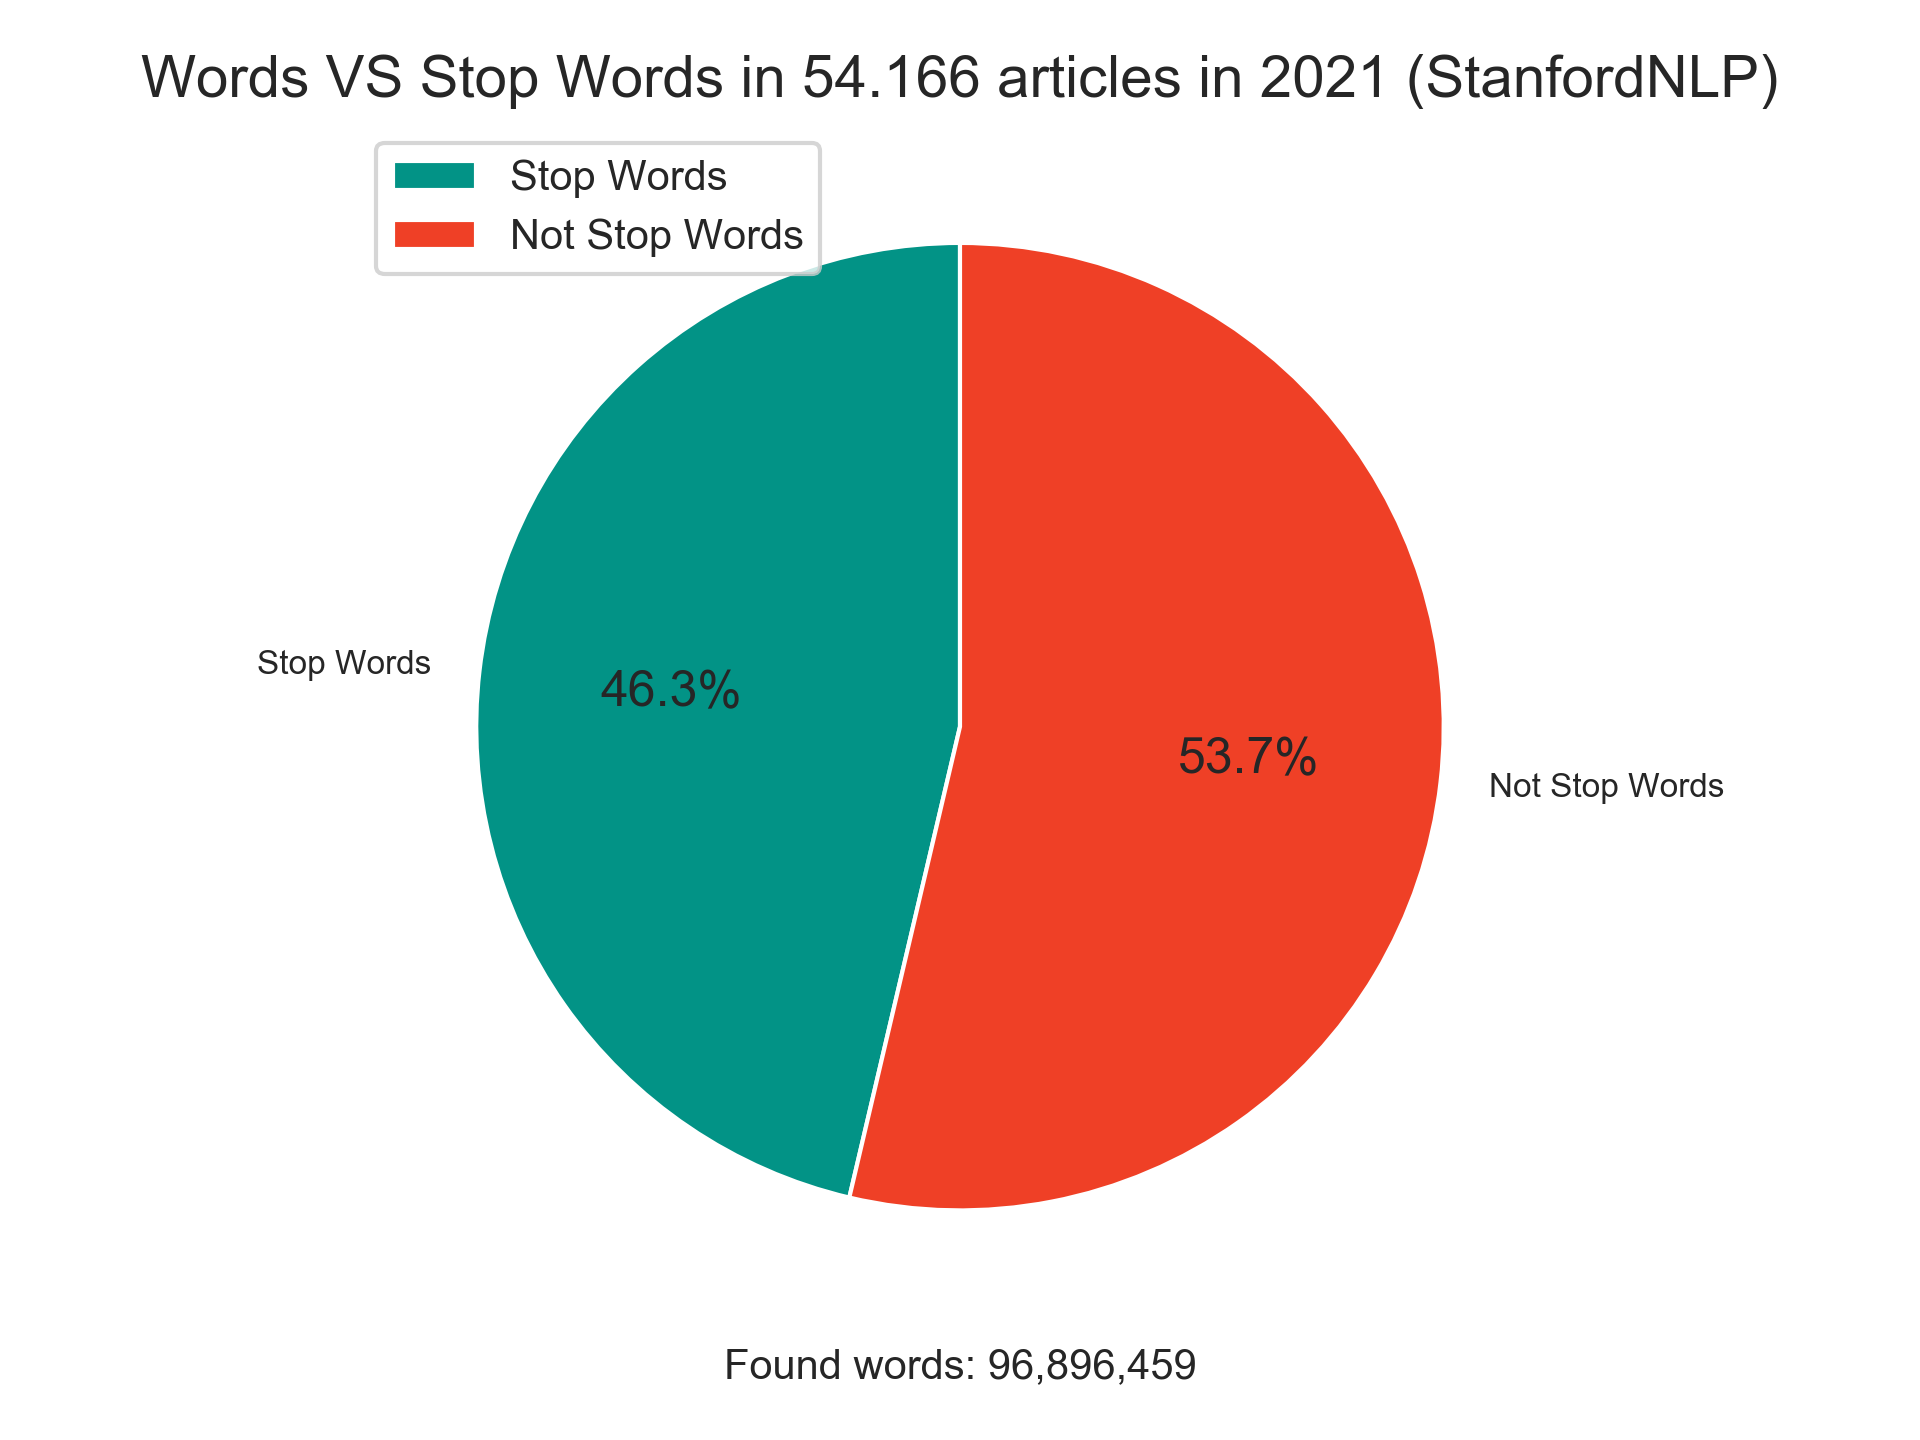

In [80]:
"""
%%python

lemmaStatistic_Py = spark.sql("select * from termStat_Py").toPandas()

text = "Found words: {:,}".format(lemmaStatistic_Py['count'].sum())

plot_figure(lemmaStatistic_Py, 
            '', 
            'count',
            'Words VS Stop Words in 54.166 articles in 2021 (StanfordNLP)',
             text,
            '',
            'Words_VS_Stop_Words_2021_CoreNLP',
            ['pie'], 
            0.9, 0.5, 0)

with tempfile.NamedTemporaryFile(suffix=".png") as tempImage:
        plt.savefig(tempImage.name)
        retval = Image(filename=tempImage.name)
        
"""

# <span style='color:Blue' id='6'> 6. TF-IDF

## <span style='color:Blue' id='6.1'> 6.1. Computing the TF and IDFs

In [81]:
lemmaDF.show(5)

+--------+--------------------+--------------------+-------------+-----------+----------+
|      id|               title|               lemma|words_in_body|lemma_count|stop_words|
+--------+--------------------+--------------------+-------------+-----------+----------+
|aoiambb8|Etiology of Sever...|[april, institute...|          867|        467|       400|
|embv1el9|Accuracy of a bat...|[measurement, car...|         1641|        883|       758|
|8dcgzyst|The influence of ...|[twenty, percent,...|          352|        205|       147|
|sgtvecj8|In vivo delivery ...|[since, onset, ai...|         4054|       2160|      1894|
|3vtq6d8f|Relationship Betw...|[nurse, largest, ...|          715|        369|       346|
+--------+--------------------+--------------------+-------------+-----------+----------+
only showing top 5 rows



For computing the TF-IDFs was used **lemmaDF** DataFrame.

In [82]:
%%time
//Filter out all documents with zero or one term

lemmaDF =  lemmaDF.where(size(col("lemma")).cast("Integer") > 1)
                         .select("id", "title", "lemma")
                         .withColumnRenamed("lemma","term")

println(lemmaDF.count)
lemmaDF.show(5)



53752
+--------+--------------------+--------------------+
|      id|               title|                term|
+--------+--------------------+--------------------+
|aoiambb8|Etiology of Sever...|[april, institute...|
|embv1el9|Accuracy of a bat...|[measurement, car...|
|8dcgzyst|The influence of ...|[twenty, percent,...|
|sgtvecj8|In vivo delivery ...|[since, onset, ai...|
|3vtq6d8f|Relationship Betw...|[nurse, largest, ...|
+--------+--------------------+--------------------+
only showing top 5 rows

Time: 2.652674913406372 seconds.



lemmaDF: org.apache.spark.sql.DataFrame = [id: string, title: string ... 1 more field]


### <span style='color:Blue' id='6.1.1'> 6.1.1 Computing TF with Spark MLlib

The classifier **Estimator** CountVectorizer() is fit with a DataFrame and Returns a PredictionModel, wich is the kind of Transformer.
**CountVectorizer** - extract the vocabulary
**CountVectorizerModel** - produces sparse representations for the documents over the vocabulary

In [83]:
%%time
import org.apache.spark.ml.feature.{CountVectorizer, CountVectorizerModel}

val NUM_TERMS = 5000 // Filtering out less frequent terms can both improve performance and remove noise. (5000)

val cvModel: CountVectorizerModel = new CountVectorizer()
  .setInputCol("term")
  .setOutputCol("termFreqs")
  .setVocabSize(NUM_TERMS)
  .fit(lemmaDF)

val docTermFreqsDF = cvModel.transform(lemmaDF)


Time: 9.654193878173828 seconds.



import org.apache.spark.ml.feature.{CountVectorizer, CountVectorizerModel}
NUM_TERMS: Int = 5000
cvModel: org.apache.spark.ml.feature.CountVectorizerModel = CountVectorizerModel: uid=cntVec_ea331c488990, vocabularySize=5000
docTermFreqsDF: org.apache.spark.sql.DataFrame = [id: string, title: string ... 2 more fields]


In [84]:
%%time
docTermFreqsDF.cache()
docTermFreqsDF.show(5)

+--------+--------------------+--------------------+--------------------+
|      id|               title|                term|           termFreqs|
+--------+--------------------+--------------------+--------------------+
|aoiambb8|Etiology of Sever...|[april, institute...|(5000,[0,1,2,5,6,...|
|embv1el9|Accuracy of a bat...|[measurement, car...|(5000,[0,1,2,5,6,...|
|8dcgzyst|The influence of ...|[twenty, percent,...|(5000,[0,2,8,10,1...|
|sgtvecj8|In vivo delivery ...|[since, onset, ai...|(5000,[1,2,3,4,5,...|
|3vtq6d8f|Relationship Betw...|[nurse, largest, ...|(5000,[0,1,2,3,5,...|
+--------+--------------------+--------------------+--------------------+
only showing top 5 rows

Time: 3.882673978805542 seconds.



<img src="help_images/termFreqs.png">

In [85]:
// Vocabulary consists of the 5000 most frequent terms
val vocabulary: Array[String] = cvModel.vocabulary

val topWords = vocabulary.take(50)
topWords.foreach(println)

patient
use
study
al.
cell
also
datum
show
include
disease
infection
result
case
increase
model
report
may
health
time
group
level
test
number
protein
virus
figure
analysis
one
pandemic
risk
sample
rate
two
day
system
however
effect
different
clinical
response
compare
treatment
table
first
find
follow
provide
viral
control
present


vocabulary: Array[String] = Array(patient, use, study, al., cell, also, datum, show, include, disease, infection, result, case, increase, model, report, may, health, time, group, level, test, number, protein, virus, figure, analysis, one, pandemic, risk, sample, rate, two, day, system, however, effect, different, clinical, response, compare, treatment, table, first, find, follow, provide, viral, control, present, population, individual, high, value, base, higher, due, factor, care, change, measure, associate, severe, fig., human, perform, method, among, vaccine, symptom, year, need, reduce, consider, activity, significant, identify, research, respiratory, positive, well, antibody, observe, country, make, age, work, hospital, cause, develop, suggest, participant, new, people, lead, socia...


### <span style='color:Blue' id='6.1.2'> 6.1.2 Computing IDF with MLlib

The classifier **Estimator** IDF() computes the Inverse Document Frequency (IDF). 

In [86]:
%%time
import org.apache.spark.ml.feature.{IDF, IDFModel}

val idf:IDF  = new IDF().setInputCol("termFreqs").setOutputCol("idfVec") //"idfVec" or "features"

val idfModel: IDFModel = idf.fit(docTermFreqsDF)
val docTermMatrixDF = idfModel.transform(docTermFreqsDF).select("id", "title", "idfVec")


Time: 14.695359945297241 seconds.



import org.apache.spark.ml.feature.{IDF, IDFModel}
idf: org.apache.spark.ml.feature.IDF = idf_c503426b168c
idfModel: org.apache.spark.ml.feature.IDFModel = IDFModel: uid=idf_c503426b168c, numDocs=53752, numFeatures=5000
docTermMatrixDF: org.apache.spark.sql.DataFrame = [id: string, title: string ... 1 more field]


In [87]:
docTermMatrixDF.show(10)

+--------+--------------------+--------------------+
|      id|               title|              idfVec|
+--------+--------------------+--------------------+
|aoiambb8|Etiology of Sever...|(5000,[0,1,2,5,6,...|
|embv1el9|Accuracy of a bat...|(5000,[0,1,2,5,6,...|
|8dcgzyst|The influence of ...|(5000,[0,2,8,10,1...|
|sgtvecj8|In vivo delivery ...|(5000,[1,2,3,4,5,...|
|3vtq6d8f|Relationship Betw...|(5000,[0,1,2,3,5,...|
|ydom2p6r|Adverse events re...|(5000,[0,1,2,5,6,...|
|1h4fis9b|Upregulation of e...|(5000,[0,1,2,3,4,...|
|ceiml0ir|Central Nervous S...|(5000,[0,1,2,3,4,...|
|yjap0mkg|Clostridium perfr...|(5000,[0,1,2,4,5,...|
|dnld2lvf|Maternal and feta...|(5000,[0,1,2,4,5,...|
+--------+--------------------+--------------------+
only showing top 10 rows



<img src="help_images/IDF.png">

Save the positions in the matrix to the terms and document titles in original corpus. Positions in the term vectors are equivalent to columns in the document-term matrix.

In [88]:
// MAP [n->(id, title)] for every article

val docIds = docTermFreqsDF.rdd.map(x => (x.getString(0),x.getString(1)) )
                         .zipWithUniqueId()
                         .map(_.swap)
                         .collect().toMap

println(docIds.size)

53752


docIds: scala.collection.immutable.Map[Long,(String, String)] = Map(53767 -> (hkzssk3m,Emerging Perspectives of RNA N(6)-methyladenosine (m(6)A) Modification on Immunity and Autoimmune Diseases), 32571 -> (v812ioeh,Prioritizing COVID-19 vaccinations for individuals with intellectual and developmental disabilities), 42890 -> (sr5sd5h2,Why does SARS-CoV-2 hit in different ways? Host genetic factors can influence the acquisition or the course of COVID-19), 46805 -> (y9eistq4,Localized mid face miliaria in a healthcare worker due to N95 respirator use: A case report and management strategies), 37159 -> (ieqq8b30,Physical activity and exercise in adults diagnosed with primary brain cancer: a systematic review), 29176 -> (lecyxkhp,Autoimmune and Rheumatic Manifestations Associated With COVID-...


In [89]:
val termIds = cvModel.vocabulary

termIds: Array[String] = Array(patient, use, study, al., cell, also, datum, show, include, disease, infection, result, case, increase, model, report, may, health, time, group, level, test, number, protein, virus, figure, analysis, one, pandemic, risk, sample, rate, two, day, system, however, effect, different, clinical, response, compare, treatment, table, first, find, follow, provide, viral, control, present, population, individual, high, value, base, higher, due, factor, care, change, measure, associate, severe, fig., human, perform, method, among, vaccine, symptom, year, need, reduce, consider, activity, significant, identify, research, respiratory, positive, well, antibody, observe, country, make, age, work, hospital, cause, develop, suggest, participant, new, people, lead, social, ...


# <span style='color:Blue' id='7'> 7. Singular Value Decomposition (SVD)

<img src="help_images/SVD_spark.png">

In [90]:
%%time
import org.apache.spark.mllib.linalg.{Vectors, Vector => MLLibVector}
import org.apache.spark.ml.linalg.{Vector => MLVector}
import org.apache.spark.mllib.linalg.distributed.RowMatrix

val vecRdd = docTermMatrixDF.select("idfVec")
                          .rdd.map { row => Vectors.fromML(row.getAs[MLVector]("idfVec")) }

// (5000,[0,2,4,5,7,...], [1.9369075463179657,0.6426707220549751,4.778102749113502, ...]

vecRdd.cache()

//To find the singular value decomposition, we simply wrap an RDD of row vectors in a RowMatrix and call computeSVD:
val docTexmRowMatrix = new RowMatrix(vecRdd)

// 53752 x 5000


Time: 0.49758219718933105 seconds.



import org.apache.spark.mllib.linalg.{Vectors, Vector=>MLLibVector}
import org.apache.spark.ml.linalg.{Vector=>MLVector}
import org.apache.spark.mllib.linalg.distributed.RowMatrix
vecRdd: org.apache.spark.rdd.RDD[org.apache.spark.mllib.linalg.Vector] = MapPartitionsRDD[504] at map at <console>:80
docTexmRowMatrix: org.apache.spark.mllib.linalg.distributed.RowMatrix = org.apache.spark.mllib.linalg.distributed.RowMatrix@624a3b1c


In [91]:
%%time

//create svd models for 5, 20, 100 Clusters

val k5=5
val k20=20
val k100=100

val svd5 = docTexmRowMatrix.computeSVD(k5, computeU=true)
val svd20 = docTexmRowMatrix.computeSVD(k20, computeU=true)
val svd100 = docTexmRowMatrix.computeSVD(k100, computeU=true)

Time: 32.37122082710266 seconds.



k5: Int = 5
k20: Int = 20
k100: Int = 100
svd5: org.apache.spark.mllib.linalg.SingularValueDecomposition[org.apache.spark.mllib.linalg.distributed.RowMatrix,org.apache.spark.mllib.linalg.Matrix] =
SingularValueDecomposition(org.apache.spark.mllib.linalg.distributed.RowMatrix@27395b4f,[12349.488125984217,7642.664303150096,6480.336167481406,5754.883888210931,5293.156931388475],0.10970534661694803   -0.05075847242049306    ... (5 total)
0.07572240936900193   -0.02926239682067003    ...
0.06334547447630168   -0.0299901773550535     ...
0.18104140217253611   0.006649774442254495    ...
0.27652180176365      0.44731369891621714     ...
0.04408464900314837   -0.009707894090658916   ...
0.060262041316298746  -0.060423828411173365   ...
0.061842849890588796  6.639342685694042E-4    ...
0.0331081...


Example of U,V,S for SVD with 5 Clusters

<img src="help_images/U_svd.png">

<img src="help_images/V_svd.png">

<img src="help_images/S.png">


# <span style='color:Blue' id='8'> 8. Documents clustering

In [92]:
%%time
import org.apache.spark.mllib.linalg.{Matrix, SingularValueDecomposition}
import org.apache.spark.mllib.linalg.distributed.RowMatrix

// k - number of clusters
// m - number of terms
// n - number of documents
def topTermsDocsInTopClusters(svd: SingularValueDecomposition[RowMatrix, Matrix], 
                          k: Int,
                          m: Int,
                          n: Int,
                          termIds: Array[String],
                          docIds: Map[Long, (String, String)]):
                    (Seq[Seq[(String, Double)]], Seq[Seq[((String, String), Double)]]) = {
                        
    val V = svd.V
    val U = svd.U
                        
    val topTerms = new ArrayBuffer[Seq[(String, Double)]] ()
    val topDocs = new ArrayBuffer[Seq[((String, String), Double)]]() 
                        
    val termClusterArr = V.toArray
    val docClusterArr = U.rows
    
    for (i <- 0 until k) {
        val terms = termClusterArr.slice (i*k, i*k + V.numRows)
                                    .zipWithIndex
                                    .sortBy(-_._1).take(m)
        topTerms += terms.map { x => (termIds(x._2), x._1) } 
        
        val docs = docClusterArr.map(x => x.toArray(i)).zipWithUniqueId()    
        topDocs += docs.top(n).map {
            x => (docIds(x._2), x._1)
        }
    }
    
    (topTerms, topDocs)
}

Time: 0.5918102264404297 seconds.



import org.apache.spark.mllib.linalg.{Matrix, SingularValueDecomposition}
import org.apache.spark.mllib.linalg.distributed.RowMatrix
topTermsDocsInTopClusters: (svd: org.apache.spark.mllib.linalg.SingularValueDecomposition[org.apache.spark.mllib.linalg.distributed.RowMatrix,org.apache.spark.mllib.linalg.Matrix], k: Int, m: Int, n: Int, termIds: Array[String], docIds: Map[Long,(String, String)])(Seq[Seq[(String, Double)]], Seq[Seq[((String, String), Double)]])


In [93]:
def printTermDocs (cluster: (Seq[Seq[(String, Double)]], Seq[Seq[((String, String), Double)]]), name: String) = {
    cluster._2.zipWithIndex.foreach{ 
    case(a, b) => {
        println()
        print("CLUSTER #")
        print(b)
        println(name)
        println()
        println(cluster._1.zipWithIndex.get(b)._1.map(_._1).mkString(" ; "))
        println()
        a.map (y => {
                    //println(y._2)  //Häufigkeit
                    println("- " + y._1._2)
                    })
        }
    }    
}


def printTerms (cluster: (Seq[Seq[(String, Double)]], Seq[Seq[((String, String), Double)]]), name: String) = {
    cluster._1.zipWithIndex.foreach{ 
    case(a, b) => {
        println()
        print("CLUSTER #")
        print(b)
        println(name)
        a.map (y => {
                    print("'"+y._1+"'")
                    print(":")
                    print(y._2)
                    println()
                    })
    }
}   
}

printTermDocs: (cluster: (Seq[Seq[(String, Double)]], Seq[Seq[((String, String), Double)]]), name: String)Unit
printTerms: (cluster: (Seq[Seq[(String, Double)]], Seq[Seq[((String, String), Double)]]), name: String)Unit


In [94]:
%%time
val clusters5 = topTermsDocsInTopClusters(svd5, 5, 20, 10, termIds, docIds)
val clusters20 = topTermsDocsInTopClusters(svd20, 20, 20, 10, termIds, docIds)
val clusters100 = topTermsDocsInTopClusters(svd100, 10, 20, 10, termIds, docIds)

Time: 10.83069396018982 seconds.



clusters5: (Seq[Seq[(String, Double)]], Seq[Seq[((String, String), Double)]]) = (ArrayBuffer(ArraySeq((cell,0.27652180176365), (al.,0.18104140217253611), (protein,0.1367614607848535), (patient,0.10970534661694803), (figure,0.10339470797008934), (model,0.100326362563256), (mouse,0.09923873767766397), (antibody,0.09203329850538199), (expression,0.08967780768682265), (gene,0.08527728666360782), (vaccine,0.07803941590903413), (viral,0.07803536207145623), (fig.,0.07801903969940747), (use,0.07572240936900193), (virus,0.07208376365734713), (infection,0.06962006901129378), (sample,0.06924787877468339), (preprint,0.06775468284252813), (study,0.06334547447630168), (response,0.062179157478457765)), ArraySeq((post-traumatic,0.44731369891621714), (time,0.1367614607848535), (level,0.10339470797008934...


## <span style='color:Blue'> 5 clusters:

In [95]:
printTermDocs(clusters5, "(5 clusters)")


CLUSTER #0(5 clusters)

cell ; al. ; protein ; patient ; figure ; model ; mouse ; antibody ; expression ; gene ; vaccine ; viral ; fig. ; use ; virus ; infection ; sample ; preprint ; study ; response

- The European Union One Health 2019 Zoonoses Report
- Technical assistance in the field of risk communication
- Fab-dimerized glycan-reactive antibodies are a structural category of natural antibodies
- Aging-dependent mitochondrial dysfunction mediated by ceramide signaling inhibits antitumor T cell response
- METTL3 regulates viral m6A RNA modification and host cell innate immune responses during SARS-CoV-2 infection
- Dynamics of B cell repertoires and emergence of cross-reactive responses in patients with different severities of COVID-19
- Notch4 signaling limits regulatory T-cell-mediated tissue repair and promotes severe lung inflammation in viral infections
- Abstracts presented at the 14th European Colorectal Congress (#ECCStGallen), 29.11.2020–2.12.2020, St.Gallen, Switzerland

In [96]:
printTerms(clusters5, "(5 clusters)")


CLUSTER #0(5 clusters)
'cell':0.27652180176365
'al.':0.18104140217253611
'protein':0.1367614607848535
'patient':0.10970534661694803
'figure':0.10339470797008934
'model':0.100326362563256
'mouse':0.09923873767766397
'antibody':0.09203329850538199
'expression':0.08967780768682265
'gene':0.08527728666360782
'vaccine':0.07803941590903413
'viral':0.07803536207145623
'fig.':0.07801903969940747
'use':0.07572240936900193
'virus':0.07208376365734713
'infection':0.06962006901129378
'sample':0.06924787877468339
'preprint':0.06775468284252813
'study':0.06334547447630168
'response':0.062179157478457765

CLUSTER #1(5 clusters)
'post-traumatic':0.44731369891621714
'time':0.1367614607848535
'level':0.10339470797008934
'disease':0.100326362563256
'student':0.09923873767766397
'identify':0.09203329850538199
'approach':0.08967780768682265
'mortality':0.08527728666360782
'fig.':0.07803941590903413
'table':0.07803536207145623
'care':0.07801903969940747
'group':0.07208376365734713
'also':0.0696200690112937

## <span style='color:Blue'> 20 clusters:

In [97]:
printTermDocs(clusters20, "(20 clusters)")


CLUSTER #0(20 clusters)

post-traumatic ; editor ; waive ; deny ; residency ; tachycardia ; ventilatory ; bedside ; endotracheal ; extremity ; angiography ; multisystem ; overwhelm ; suicidal ; love ; non-hispanic ; editorial ; refuse ; u/l ; consciousness

- SARS-CoV-2 inactivation by human defensin HNP1 and retrocyclin RC-101
- Toward a “thoughtful lightness”: Education in viral times
- Taking the Long View: COVID-19 Priorities for the Biden Administration.
- Macrofungi as a Nutraceutical Source: Promising Bioactive Compounds and Market Value
- Taking the Long View: COVID-19 Priorities for the Biden Administration
- """Like Pieces in a Puzzle"": Online Sacred Harp Singing During the COVID-19 Pandemic"
- Expressive Flamenco ©: An Emerging Expressive Arts-Based Practice
- Feasibility and Preliminary Efficacy of a Community-Based Addiction Rehabilitation Electronic System in Substance Use Disorder: Pilot Randomized Controlled Trial
- Oculofacial plastic surgery-related online search tr

- Melatonin in Cancer Treatment: Current Knowledge and Future Opportunities
- The soil crisis: the need to treat as a global health problem and the pivotal role of microbes in prophylaxis and therapy
- Hydrogen sulfide (H(2)S) signaling in plant development and stress responses
- A comprehensive and critical overview of schistosomiasis vaccine candidates
- Broad cross-reactivity across sarbecoviruses exhibited by a subset of COVID-19 donor-derived neutralizing antibodies
- Neutrophil and Eosinophil DNA Extracellular Trap Formation: Lessons From Pathogenic Fungi
- A Comprehensive Review of Image Analysis Methods for Microorganism Counting: From Classical Image Processing to Deep Learning Approaches
- CCN2 (Cellular Communication Network factor 2) in the bone marrow microenvironment, normal and malignant hematopoiesis

CLUSTER #12(20 clusters)

interventional ; varied ; mutational ; topical ; employer ; age-related ; wet ; gm-csf ; toll-like ; speaker ; mildly ; excitation ; emphasise ; 

In [98]:
printTerms(clusters20, "(20 clusters)")


CLUSTER #0(20 clusters)
'post-traumatic':-0.0011263151671202457
'editor':-0.001153067666627438
'waive':-0.0011987548943226086
'deny':-0.0012451273674725146
'residency':-0.0012770946231072306
'tachycardia':-0.0012865878064229435
'ventilatory':-0.0013203881685174019
'bedside':-0.0013585727927996672
'endotracheal':-0.0013661198431732377
'extremity':-0.0013718919650539314
'angiography':-0.0013923653281888884
'multisystem':-0.0013948895501816958
'overwhelm':-0.0013976437125976938
'suicidal':-0.0014058439689662626
'love':-0.0014246224101494992
'non-hispanic':-0.001431455703245731
'editorial':-0.001433374940209555
'refuse':-0.0014518032746627585
'u/l':-0.001475484517096643
'consciousness':-0.0014810773325451708

CLUSTER #1(20 clusters)
'encapsulate':0.1155345093004932
'metadata':0.06042382841117343
'wet':0.05349240779714087
'encouraging':0.05284592146747963
'custom':0.05075847242049304
'bandwidth':0.03768177201865202
'turnover':0.029990177355053493
'adenosine':0.029262396820670007
'disclosur

'histogram':0.05075847242049304
'love':0.04790737116676436
'thematic':0.04778548297591474
'counteract':0.04750070074187818

CLUSTER #16(20 clusters)
'reversible':0.1155345093004932
'court':0.08670984153736928
'scheduling':0.0759299819702127
'gm-csf':0.07202651373017835
'jurisdiction':0.07090837775032482
'stemi':0.06908421714077834
'wet':0.06644239145126715
'suboptimal':0.06373397712732277
'generalization':0.06305996901324717
'well-established':0.06042382841117343
'holiday':0.056338820901050815
'asc':0.05424391691580617
'costly':0.05349240779714087
'sponsor':0.05309211911114415
'breakdown':0.05284592146747963
'internalization':0.051517883807758874
'wherein':0.05099954761636914
'self-isolation':0.05075847242049304
'uncover':0.04790737116676436
'street':0.04778548297591474

CLUSTER #17(20 clusters)
'wean':0.1155345093004932
'jump':0.08670984153736928
'u/ml':0.0759299819702127
'instrumental':0.07202651373017835
'hydrolysis':0.07090837775032482
'club':0.06908421714077834
'roll':0.0664423914

## <span style='color:Blue'> 100 clusters:

In [99]:
printTermDocs(clusters100, "(100 clusters)")


CLUSTER #0(100 clusters)

post-traumatic ; editor ; waive ; deny ; residency ; tachycardia ; ventilatory ; bedside ; endotracheal ; extremity ; angiography ; multisystem ; overwhelm ; suicidal ; love ; non-hispanic ; editorial ; refuse ; u/l ; consciousness

- SARS-CoV-2 inactivation by human defensin HNP1 and retrocyclin RC-101
- Toward a “thoughtful lightness”: Education in viral times
- Taking the Long View: COVID-19 Priorities for the Biden Administration.
- Macrofungi as a Nutraceutical Source: Promising Bioactive Compounds and Market Value
- Taking the Long View: COVID-19 Priorities for the Biden Administration
- """Like Pieces in a Puzzle"": Online Sacred Harp Singing During the COVID-19 Pandemic"
- Expressive Flamenco ©: An Emerging Expressive Arts-Based Practice
- Feasibility and Preliminary Efficacy of a Community-Based Addiction Rehabilitation Electronic System in Substance Use Disorder: Pilot Randomized Controlled Trial
- Oculofacial plastic surgery-related online search t

dropout ; parametric ; dynamical ; age-related ; ordinal ; topical ; stir ; hair ; consciousness ; enrolment ; semester ; afterwards ; intent ; encouraging ; viscosity ; time-consuming ; randomise ; suboptimal ; bandwidth ; pci

- Fab-dimerized glycan-reactive antibodies are a structural category of natural antibodies
- Neutralization potency of monoclonal antibodies recognizing dominant and subdominant epitopes on SARS-CoV-2 Spike is impacted by the B.1.1.7 variant
- A Comprehensive Review of Image Analysis Methods for Microorganism Counting: From Classical Image Processing to Deep Learning Approaches
- Broad cross-reactivity across sarbecoviruses exhibited by a subset of COVID-19 donor-derived neutralizing antibodies
- Diverse immunoglobulin gene usage and convergent epitope targeting in neutralizing antibody responses to SARS-CoV-2
- Dynamics of B cell repertoires and emergence of cross-reactive responses in patients with different severities of COVID-19
- Cotton Wastes Functionaliz

In [100]:
printTerms(clusters100, "(100 clusters)")


CLUSTER #0(100 clusters)
'post-traumatic':-0.0011263151671202446
'editor':-0.0011530676666274338
'waive':-0.0011987548943226095
'deny':-0.0012451273674725196
'residency':-0.0012770946231072376
'tachycardia':-0.0012865878064229333
'ventilatory':-0.001320388168517391
'bedside':-0.0013585727927996633
'endotracheal':-0.0013661198431732511
'extremity':-0.0013718919650539357
'angiography':-0.0013923653281888758
'multisystem':-0.0013948895501816883
'overwhelm':-0.0013976437125977018
'suicidal':-0.00140584396896628
'love':-0.0014246224101494994
'non-hispanic':-0.0014314557032457376
'editorial':-0.0014333749402095498
'refuse':-0.00145180327466277
'u/l':-0.0014754845170966307
'consciousness':-0.0014810773325451658

CLUSTER #1(100 clusters)
'encapsulate':0.44731369891621603
'api':0.0066497744422540465
'wet':6.639342685694346E-4
'aspirin':-0.0011263151671202446
'alternate':-0.0011530676666274338
'drink':-0.0011987548943226095
'gram-negative':-0.0012451273674725196
'southeast':-0.00127709462310723